# Project 4 - West Nile Virus Prediction (Team CJE)

## Load libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler


## Load data

In [3]:
# !git clone https://github.com/kl503/DSI-SG-24-projects.git

In [4]:
# Do not load unless you want groupmates to enter authorization code
# from google.colab import drive
# drive.mount('drive')

In [5]:
# !ls

In [6]:
# Activate only when running CoLab
# train = pd.read_csv("DSI-SG-24-projects/project_4/data/train.csv")
# test = pd.read_csv("DSI-SG-24-projects/project_4/data/test.csv")
# spray = pd.read_csv("DSI-SG-24-projects/project_4/data/spray.csv")
# weather = pd.read_csv("DSI-SG-24-projects/project_4/data/weather.csv")
# kaggle = pd.read_csv("DSI-SG-24-projects/project_4/data/sampleSubmission.csv")

In [7]:
# Activate only when running on local desktop
train = pd.read_csv("../data/train.csv")
test = pd.read_csv("../data/test.csv")
spray = pd.read_csv("../data/spray.csv")
weather = pd.read_csv("../data/weather.csv")
kaggle = pd.read_csv("../data/sampleSubmission.csv")

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10506 entries, 0 to 10505
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Date                    10506 non-null  object 
 1   Address                 10506 non-null  object 
 2   Species                 10506 non-null  object 
 3   Block                   10506 non-null  int64  
 4   Street                  10506 non-null  object 
 5   Trap                    10506 non-null  object 
 6   AddressNumberAndStreet  10506 non-null  object 
 7   Latitude                10506 non-null  float64
 8   Longitude               10506 non-null  float64
 9   AddressAccuracy         10506 non-null  int64  
 10  NumMosquitos            10506 non-null  int64  
 11  WnvPresent              10506 non-null  int64  
dtypes: float64(2), int64(4), object(6)
memory usage: 985.1+ KB


Train does not have null entries

In [9]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116293 entries, 0 to 116292
Data columns (total 11 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Id                      116293 non-null  int64  
 1   Date                    116293 non-null  object 
 2   Address                 116293 non-null  object 
 3   Species                 116293 non-null  object 
 4   Block                   116293 non-null  int64  
 5   Street                  116293 non-null  object 
 6   Trap                    116293 non-null  object 
 7   AddressNumberAndStreet  116293 non-null  object 
 8   Latitude                116293 non-null  float64
 9   Longitude               116293 non-null  float64
 10  AddressAccuracy         116293 non-null  int64  
dtypes: float64(2), int64(3), object(6)
memory usage: 9.8+ MB


Test does not have null entries. How come it has so many more rows than Train set?

In [10]:
spray.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14835 entries, 0 to 14834
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       14835 non-null  object 
 1   Time       14251 non-null  object 
 2   Latitude   14835 non-null  float64
 3   Longitude  14835 non-null  float64
dtypes: float64(2), object(2)
memory usage: 463.7+ KB


Spray's time column has 500+ null entries

In [11]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 22 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Station      2944 non-null   int64  
 1   Date         2944 non-null   object 
 2   Tmax         2944 non-null   int64  
 3   Tmin         2944 non-null   int64  
 4   Tavg         2944 non-null   object 
 5   Depart       2944 non-null   object 
 6   DewPoint     2944 non-null   int64  
 7   WetBulb      2944 non-null   object 
 8   Heat         2944 non-null   object 
 9   Cool         2944 non-null   object 
 10  Sunrise      2944 non-null   object 
 11  Sunset       2944 non-null   object 
 12  CodeSum      2944 non-null   object 
 13  Depth        2944 non-null   object 
 14  Water1       2944 non-null   object 
 15  SnowFall     2944 non-null   object 
 16  PrecipTotal  2944 non-null   object 
 17  StnPressure  2944 non-null   object 
 18  SeaLevel     2944 non-null   object 
 19  Result

Weather has no null entries

## Baseline score

In [12]:
train['WnvPresent'].value_counts(normalize=True)

0    0.947554
1    0.052446
Name: WnvPresent, dtype: float64

Baseline score to beat is **0.948**...!

## Train dataset

### Plot Chicago map and trap locations

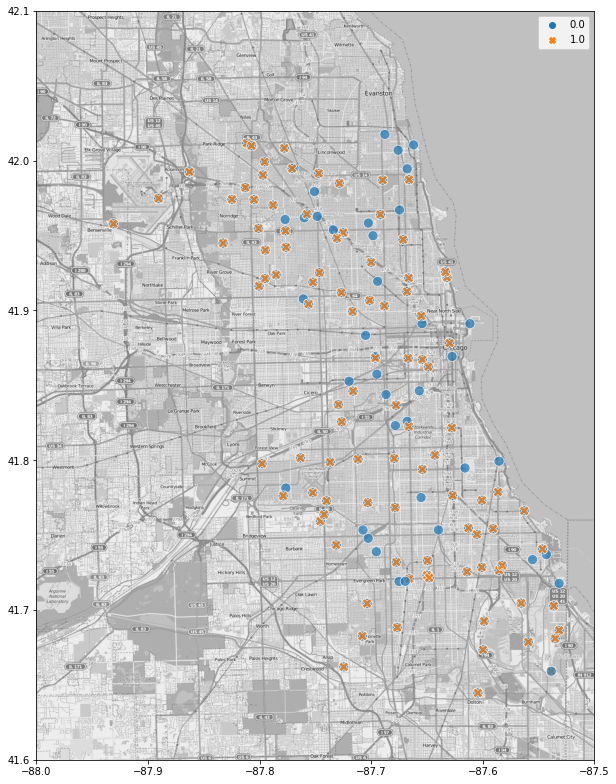

In [13]:
# Map Code copied from Kaggle website...
# mapdata = np.loadtxt("DSI-SG-24-projects/project_4/data/west_nile/input/mapdata_copyright_openstreetmap_contributors.txt")
mapdata = np.loadtxt("../data/west_nile/input/mapdata_copyright_openstreetmap_contributors.txt")


traps = train[['Date', 'Trap','Longitude', 'Latitude', 'WnvPresent']]

aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]
lon_lat_box = (-88, -87.5, 41.6, 42.1)

plt.figure(figsize=(10,14))
plt.imshow(mapdata, 
           cmap=plt.get_cmap('gray'), 
           extent=lon_lat_box, 
           aspect=aspect)

locations = traps[['Longitude', 'Latitude', 'WnvPresent']].drop_duplicates().values

sns.scatterplot(
    x = locations[:,0], 
    y = locations[:,1],
    hue = locations[:,2],
    style = locations[:,2],
    s = 100,
    alpha = 0.7
);


Looks like all or most of the traps are concentrated in the eastern half of Chicago city, perhaps this is the most built-up part of Chicago.

Visually, over half of the traps have come across contaminated mosquitoes, and most of the infected traps are towards the western part of the city. Seems to suggest that mosquitoes don't like the airy / windy part of the city that is closer to the sea??

### Describe dataset


In [14]:
# Force description for all columns
train.describe(include = 'all')

Date                                            Address  \
count        10506                                              10506   
unique          95                                                138   
top     2007-08-01  ORD Terminal 5, O'Hare International Airport, ...   
freq           551                                                750   
mean           NaN                                                NaN   
std            NaN                                                NaN   
min            NaN                                                NaN   
25%            NaN                                                NaN   
50%            NaN                                                NaN   
75%            NaN                                                NaN   
max            NaN                                                NaN   

                       Species         Block            Street   Trap  \
count                    10506  10506.000000             10506  10506   
unique                       7           NaN               128    136   
top     CULEX PIPIENS/RESTUANS           NaN   W OHARE AIRPORT   T900   
freq                      4752           NaN               750    750   
mean                       NaN     35.687797               NaN    NaN   
std                        NaN     24.339468               NaN    NaN   
min                        NaN     10.000000               NaN    NaN   
25%                        NaN     12.000000               NaN    NaN   
50%                        NaN     33.000000               NaN    NaN   
75%                        NaN     52.000000               NaN    NaN   
max                        NaN     98.000000               NaN    NaN   

                    AddressNumberAndStreet      Latitude     Longitude  \
count                                10506  10506.000000  10506.000000   
unique                                 138           NaN           NaN   
top     1000  W OHARE AIRPORT, Chicago, IL           NaN           NaN   
freq                                   750           NaN           NaN   
mean                                   NaN     41.841139    -87.699908   
std                                    NaN      0.112742      0.096514   
min                                    NaN     41.644612    -87.930995   
25%                                    NaN     41.732984    -87.760070   
50%                                    NaN     41.846283    -87.694991   
75%                                    NaN     41.954690    -87.627796   
max                                    NaN     42.017430    -87.531635   

        AddressAccuracy  NumMosquitos    WnvPresent  
count      10506.000000  10506.000000  10506.000000  
unique              NaN           NaN           NaN  
top                 NaN           NaN           NaN  
freq                NaN           NaN           NaN  
mean           7.819532     12.853512      0.052446  
std            1.452921     16.133816      0.222936  
min            3.000000      1.000000      0.000000  
25%            8.000000      2.000000      0.000000  
50%            8.000000      5.000000      0.000000  
75%            9.000000     17.000000      0.000000  
max            9.000000     50.000000      1.000000

Observations:


*   There are 138 unique locations for the mosquito traps (spread across 128 streets)
*   There are 7 unique species of mosquitoes 
* The traps are placed over 95 unique dates






### Check dates

In [15]:
# Convert to datetime
train['Date'] = pd.to_datetime(train['Date'])

In [16]:
# Check conversion
train.Date

0       2007-05-29
1       2007-05-29
2       2007-05-29
3       2007-05-29
4       2007-05-29
           ...    
10501   2013-09-26
10502   2013-09-26
10503   2013-09-26
10504   2013-09-26
10505   2013-09-26
Name: Date, Length: 10506, dtype: datetime64[ns]

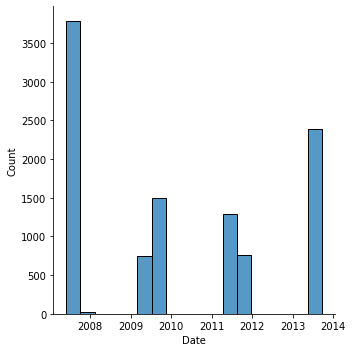

In [17]:
# Plot dates
sns.displot(data = train, x = "Date");

Most number of WNV tests are conducted in 2007, followed by 2013

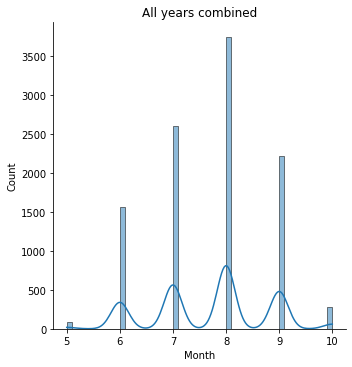

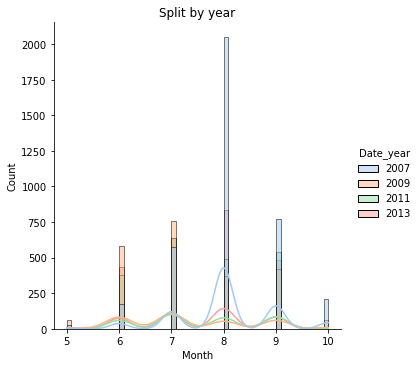

In [18]:
# Plot months
train['Date_month'] = train['Date'].map(lambda x: x.month)
train['Date_year'] = train['Date'].map(lambda x: x.year)

# All years combined
ax1 = sns.displot(
    data = train, 
    x = "Date_month", 
    kde = True
)
ax1.set(xlabel="Month", ylabel = "Count", title = "All years combined")

# Split by years
ax2 = sns.displot(
    data = train, 
    x = "Date_month", 
    kde = True, 
    hue = "Date_year", 
    palette = "pastel"
)
ax2.set(xlabel="Month", ylabel = "Count", title = "Split by year");

Mosquito traps are not set between November to April every year. The peak period is August, followed by July, the September. 

2007 is the most busy year.

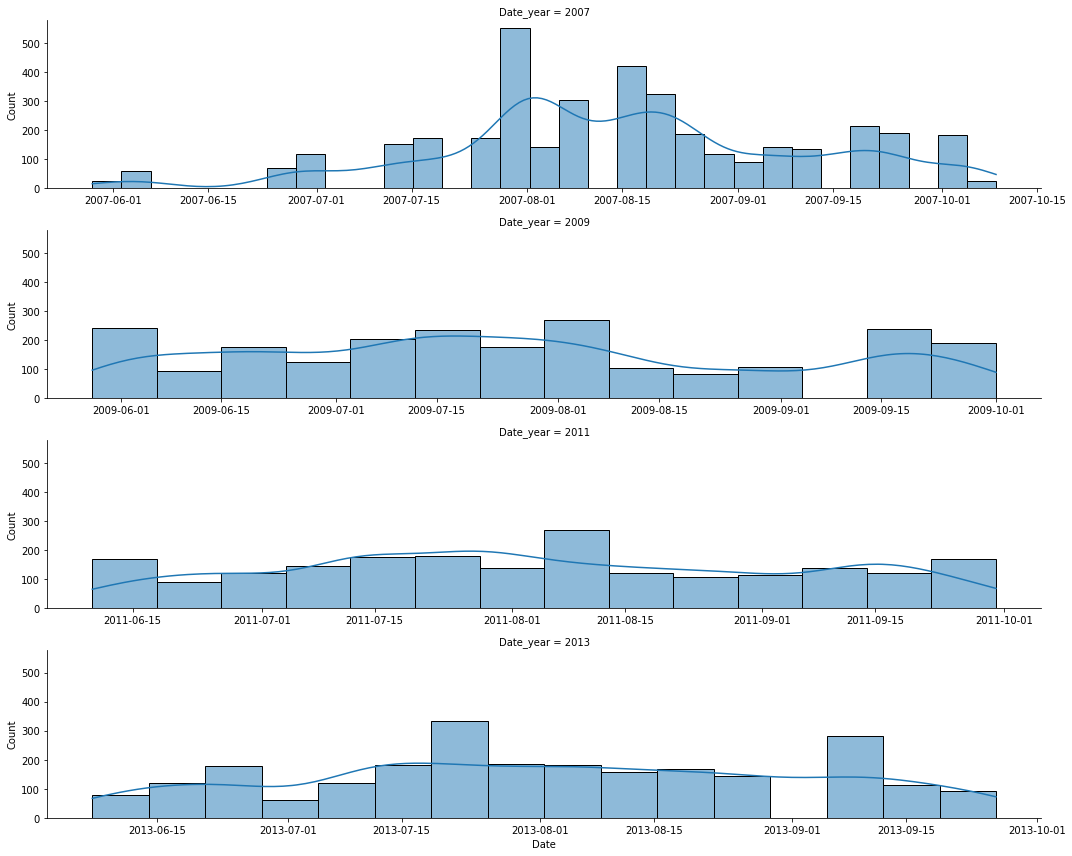

In [19]:
# Look at records for each individual year
g = sns.FacetGrid(train, col = "Date_year", 
                  height = 3, aspect = 5, 
                  col_wrap = 1, 
                  sharex = False, sharey = True)
g.map(sns.histplot, 'Date', kde = True);

### Check addresses

In [20]:
train

Date                                            Address  \
0     2007-05-29  4100 North Oak Park Avenue, Chicago, IL 60634,...   
1     2007-05-29  4100 North Oak Park Avenue, Chicago, IL 60634,...   
2     2007-05-29  6200 North Mandell Avenue, Chicago, IL 60646, USA   
3     2007-05-29    7900 West Foster Avenue, Chicago, IL 60656, USA   
4     2007-05-29    7900 West Foster Avenue, Chicago, IL 60656, USA   
...          ...                                                ...   
10501 2013-09-26      5100 West 72nd Street, Chicago, IL 60638, USA   
10502 2013-09-26    5800 North Ridge Avenue, Chicago, IL 60660, USA   
10503 2013-09-26  1700 North Ashland Avenue, Chicago, IL 60622, USA   
10504 2013-09-26   7100 North Harlem Avenue, Chicago, IL 60631, USA   
10505 2013-09-26      4200 West 65th Street, Chicago, IL 60621, USA   

                      Species  Block           Street  Trap  \
0      CULEX PIPIENS/RESTUANS     41   N OAK PARK AVE  T002   
1              CULEX RESTUANS     41   N OAK PARK AVE  T002   
2              CULEX RESTUANS     62    N MANDELL AVE  T007   
3      CULEX PIPIENS/RESTUANS     79     W FOSTER AVE  T015   
4              CULEX RESTUANS     79     W FOSTER AVE  T015   
...                       ...    ...              ...   ...   
10501  CULEX PIPIENS/RESTUANS     51        W 72ND ST  T035   
10502  CULEX PIPIENS/RESTUANS     58      N RIDGE AVE  T231   
10503  CULEX PIPIENS/RESTUANS     17    N ASHLAND AVE  T232   
10504  CULEX PIPIENS/RESTUANS     71     N HARLEM AVE  T233   
10505  CULEX PIPIENS/RESTUANS     42        W 65TH ST  T235   

                  AddressNumberAndStreet   Latitude  Longitude  \
0      4100  N OAK PARK AVE, Chicago, IL  41.954690 -87.800991   
1      4100  N OAK PARK AVE, Chicago, IL  41.954690 -87.800991   
2       6200  N MANDELL AVE, Chicago, IL  41.994991 -87.769279   
3        7900  W FOSTER AVE, Chicago, IL  41.974089 -87.824812   
4        7900  W FOSTER AVE, Chicago, IL  41.974089 -87.824812   
...                                  ...        ...        ...   
10501       5100  W 72ND ST, Chicago, IL  41.763733 -87.742302   
10502     5800  N RIDGE AVE, Chicago, IL  41.987280 -87.666066   
10503   1700  N ASHLAND AVE, Chicago, IL  41.912563 -87.668055   
10504    7100  N HARLEM AVE, Chicago, IL  42.009876 -87.807277   
10505       4200  W 65TH ST, Chicago, IL  41.776428 -87.627096   

       AddressAccuracy  NumMosquitos  WnvPresent  Date_month  Date_year  
0                    9             1           0           5       2007  
1                    9             1           0           5       2007  
2                    9             1           0           5       2007  
3                    8             1           0           5       2007  
4                    8             4           0           5       2007  
...                ...           ...         ...         ...        ...  
10501                8             6           1           9       2013  
10502                8             5           0           9       2013  
10503                9             1           0           9       2013  
10504                9             5           0           9       2013  
10505                8             1           0           9       2013  

[10506 rows x 14 columns]

In [21]:
# Check count of top repeating addresses
## Note: An address is repeated if number of mosquitos exceed 50, 
## they are split into another record (another row in the dataset)

train.groupby(["Address","Date_year"]).NumMosquitos.agg({'count','sum'}).sort_values('sum', ascending = False).head(20)

sum  count
Address                                            Date_year              
South Doty Avenue, Chicago, IL, USA                2007       19134    408
South Stony Island Avenue, Chicago, IL, USA        2007        9321    232
ORD Terminal 5, O'Hare International Airport, C... 2013        5689    238
                                                   2009        5488    273
                                                   2011        4209    239
South Avenue L, Chicago, IL 60617, USA             2007        2988     83
2400 East 105th Street, Chicago, IL 60617, USA     2007        2532     68
4100 North Oak Park Avenue, Chicago, IL 60634, USA 2013        1792     60
3700 118th Street, Chicago, IL 60617, USA          2007        1785     61
1000 North Central Park Avenue, Chicago, IL 606... 2013        1355     45
5200 South Kolmar Avenue, Chicago, IL 60632, USA   2011        1313     51
2200 West 113th Street, Chicago, IL 60643, USA     2007        1312     86
4200 West 127th Street, Alsip, IL 60803, USA       2007        1235     59
                                                   2009        1178     59
7000 North Moselle Avenue, Chicago, IL 60646, USA  2013        1162     41
3500 West 116th Street, Chicago, IL 60655, USA     2013        1140     44
South Doty Avenue, Chicago, IL, USA                2013        1134     45
9100 West Higgins Road, Rosemont, IL 60018, USA    2013        1085     41
Ohare Court, Bensenville, IL 60106, USA            2009        1079     59
8200 South Kostner Avenue, Chicago, IL 60652, USA  2009        1060     44

Chicago Airport is the champion year after year, with most number of mosquitoes tested for WNV. 

South Doty Ave, South Stony Island hold the all-time record for number of mosquitoes tested but they dropped off after 2007.

However, most number of mosquitoes caught and tested does not mean high presence of WNV. Let's check for addresses with highest presence of WNV next...

In [22]:
# Check count of top repeating addresses with virus present
train.groupby(["Address","Date_year"]).WnvPresent.agg({'count','mean'}).sort_values('mean', ascending = False).head(20)

mean  count
Address                                            Date_year                 
4600 Milwaukee Avenue, Chicago, IL 60630, USA      2013       0.259259     27
6100 West Fullerton Avenue, Chicago, IL 60639, USA 2013       0.242424     33
8200 South Kostner Avenue, Chicago, IL 60652, USA  2013       0.228571     35
4200 West 65th Street, Chicago, IL 60621, USA      2013       0.225806     31
4000 East 130th Street, Chicago, IL 60633, USA     2007       0.208333     24
7100 North Harlem Avenue, Chicago, IL 60631, USA   2013       0.205882     34
5000 South Union Avenue, Chicago, IL 60609, USA    2007       0.200000     30
3600 North Pittsburgh Avenue, Chicago, IL 60634... 2007       0.200000     35
5800 North Pulaski Road, Chicago, IL 60646, USA    2013       0.193548     31
6500 North Oak Park Avenue, Chicago, IL 60631, USA 2007       0.193548     31
5800 North Western Avenue, Chicago, IL 60659, USA  2013       0.193548     31
ORD Terminal 5, O'Hare International Airport, C... 2013       0.193277    238
7200 North Oketo Avenue, Chicago, IL 60631, USA    2007       0.179487     39
1000 North Central Park Avenue, Chicago, IL 606... 2013       0.177778     45
6000 North Avondale Avenue, Chicago, IL 60631, USA 2007       0.166667     24
2800 North Francisco Avenue, Chicago, IL 60618,... 2013       0.166667     24
4100 North Oak Park Avenue, Chicago, IL 60634, USA 2007       0.163265     49
1300 North Laramie Avenue, Chicago, IL 60651, USA  2013       0.161290     31
5100 North Mont Clare Avenue, Chicago, IL 60656... 2013       0.148148     27
6000 West Roscoe Street, Chicago, IL 60634, USA    2007       0.142857     14

4600 Milwaukee Ave is the champion --> 25.9% of the counts having WNV. Chicago airport is reasonably high up there too, ranked 12th.

### Check mosquito types


In [23]:
# Check unique species
train['Species'].unique()

array(['CULEX PIPIENS/RESTUANS', 'CULEX RESTUANS', 'CULEX PIPIENS',
       'CULEX SALINARIUS', 'CULEX TERRITANS', 'CULEX TARSALIS',
       'CULEX ERRATICUS'], dtype=object)

In [24]:
# Count of test samples by species by year
train.groupby(['Species','Date_year']).size()

Species                 Date_year
CULEX ERRATICUS         2013            1
CULEX PIPIENS           2007         1603
                        2009          371
                        2011          261
                        2013          464
CULEX PIPIENS/RESTUANS  2007         1553
                        2009         1123
                        2011          962
                        2013         1114
CULEX RESTUANS          2007          505
                        2009          716
                        2011          717
                        2013          802
CULEX SALINARIUS        2007           41
                        2009           18
                        2011           24
                        2013            3
CULEX TARSALIS          2009            2
                        2011            4
CULEX TERRITANS         2007          109
                        2009           19
                        2011           86
                        2013            8




*   CULEX ERRATICUS not important, only appeared in 2013
*   Top 3 champions by count are PIPIENS, PIPENS/RESTUANS, RESTUANS



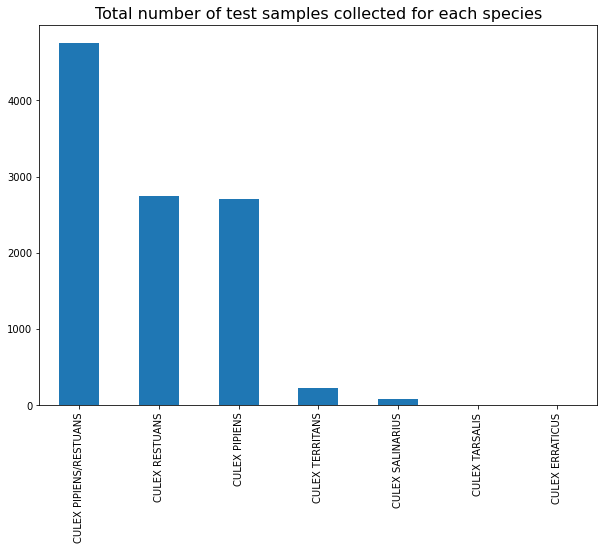

In [25]:
# Plot bar chart
plt.figure(figsize = (10,7))
train.Species.value_counts().plot(kind = 'bar')
plt.title('Total number of test samples collected for each species', fontsize=16);

In [26]:
# Count of infected test samples by species 
train.groupby(['Species', 'WnvPresent']).size()

Species                 WnvPresent
CULEX ERRATICUS         0                1
CULEX PIPIENS           0             2459
                        1              240
CULEX PIPIENS/RESTUANS  0             4490
                        1              262
CULEX RESTUANS          0             2691
                        1               49
CULEX SALINARIUS        0               86
CULEX TARSALIS          0                6
CULEX TERRITANS         0              222
dtype: int64

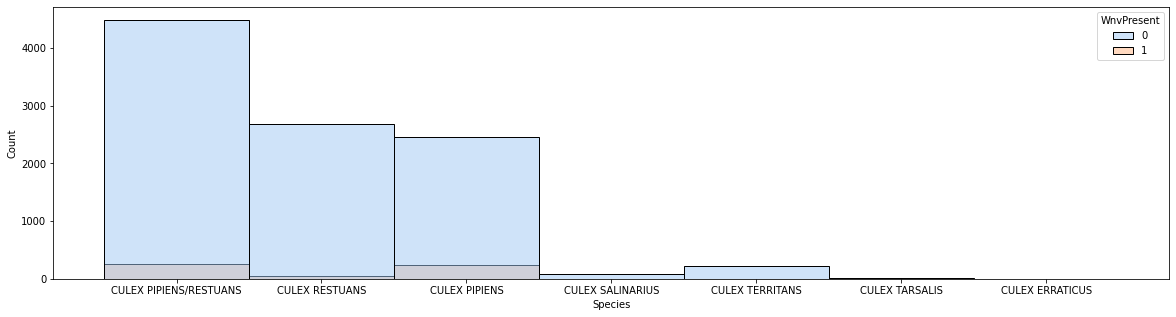

In [27]:
# Plot bar chart
plt.figure(figsize=(20,5))
sns.histplot(data=train, x="Species", hue = "WnvPresent", palette = "pastel");

Looks like only 3 species can spread WNV? PIPIENS, PIPENS/RESTUANS, RESTUANS

### Check mosquito traps

In [28]:
# Number of traps across years
train.Trap.nunique()

136

There are 136 unique traps in the city.

In [29]:
train.duplicated(subset=['Trap','Date','Species']).value_counts(normalize = True)

False    0.806682
True     0.193318
dtype: float64

There are many duplicated rows for traps because the maximum number of mosquitoes is 50 per data row. 
About 19% are duplicated. We need to combine rows (i.e. add NumMosquitoes).

In [30]:
train.shape, train.columns

((10506, 14),
 Index(['Date', 'Address', 'Species', 'Block', 'Street', 'Trap',
        'AddressNumberAndStreet', 'Latitude', 'Longitude', 'AddressAccuracy',
        'NumMosquitos', 'WnvPresent', 'Date_month', 'Date_year'],
       dtype='object'))

In [31]:
train.groupby(['Trap','Date']).NumMosquitos.agg({'sum','count'}).sort_values('sum')

sum  count
Trap Date                   
T001 2007-06-26     1      1
T070 2007-09-04     1      1
T069 2013-06-21     1      1
     2011-09-16     1      1
     2011-09-01     1      1
...               ...    ...
T138 2007-08-08  1892     40
T115 2007-08-28  2476     51
     2007-08-01  2479     54
     2007-08-16  2636     54
     2007-07-25  3002     64

[4616 rows x 2 columns]

In [32]:
# Zoom into Trap 115 
train.loc[((train['Trap'] == 'T115') & (train['Date'] == '2007-07-25'))].sort_values('NumMosquitos')

Date                              Address                 Species  \
664 2007-07-25  South Doty Avenue, Chicago, IL, USA         CULEX TERRITANS   
663 2007-07-25  South Doty Avenue, Chicago, IL, USA        CULEX SALINARIUS   
633 2007-07-25  South Doty Avenue, Chicago, IL, USA           CULEX PIPIENS   
632 2007-07-25  South Doty Avenue, Chicago, IL, USA           CULEX PIPIENS   
625 2007-07-25  South Doty Avenue, Chicago, IL, USA           CULEX PIPIENS   
..         ...                                  ...                     ...   
631 2007-07-25  South Doty Avenue, Chicago, IL, USA           CULEX PIPIENS   
603 2007-07-25  South Doty Avenue, Chicago, IL, USA  CULEX PIPIENS/RESTUANS   
602 2007-07-25  South Doty Avenue, Chicago, IL, USA  CULEX PIPIENS/RESTUANS   
620 2007-07-25  South Doty Avenue, Chicago, IL, USA           CULEX PIPIENS   
601 2007-07-25  South Doty Avenue, Chicago, IL, USA  CULEX PIPIENS/RESTUANS   

     Block       Street  Trap         AddressNumberAndStreet   Latitude  \
664     12   S DOTY AVE  T115  1200  S DOTY AVE, Chicago, IL  41.673408   
663     12   S DOTY AVE  T115  1200  S DOTY AVE, Chicago, IL  41.673408   
633     12   S DOTY AVE  T115  1200  S DOTY AVE, Chicago, IL  41.673408   
632     12   S DOTY AVE  T115  1200  S DOTY AVE, Chicago, IL  41.673408   
625     12   S DOTY AVE  T115  1200  S DOTY AVE, Chicago, IL  41.673408   
..     ...          ...   ...                            ...        ...   
631     12   S DOTY AVE  T115  1200  S DOTY AVE, Chicago, IL  41.673408   
603     12   S DOTY AVE  T115  1200  S DOTY AVE, Chicago, IL  41.673408   
602     12   S DOTY AVE  T115  1200  S DOTY AVE, Chicago, IL  41.673408   
620     12   S DOTY AVE  T115  1200  S DOTY AVE, Chicago, IL  41.673408   
601     12   S DOTY AVE  T115  1200  S DOTY AVE, Chicago, IL  41.673408   

     Longitude  AddressAccuracy  NumMosquitos  WnvPresent  Date_month  \
664 -87.599862                5             1           0           7   
663 -87.599862                5             1           0           7   
633 -87.599862                5            13           0           7   
632 -87.599862                5            20           0           7   
625 -87.599862                5            23           0           7   
..         ...              ...           ...         ...         ...   
631 -87.599862                5            50           0           7   
603 -87.599862                5            50           1           7   
602 -87.599862                5            50           0           7   
620 -87.599862                5            50           0           7   
601 -87.599862                5            50           0           7   

     Date_year  
664       2007  
663       2007  
633       2007  
632       2007  
625       2007  
..         ...  
631       2007  
603       2007  
602       2007  
620       2007  
601       2007  

[64 rows x 14 columns]

I observe that out of the 64 test samples obtained from T115 on 2007-07-25, some have the max of 50 mosquitoes while some have less (e.g. 13 / 20 / 23 mosquitoes). 

Also, some samples have virus detected while some sample do not, even though they are tested on the same day from the same Trap No. 115. 

In combining the mosquito counts, I shall take the conservative route and set WnvPresent == 1 as long as one out of the many consolidated test samples is positive, i.e. i will not use mean().

I also notice different mosquito species from the same trap, so I will not differentiate them when I combine rows.

In [33]:
# Add NumMosquitos and WnvPresent for duplicated rows
train = train.groupby(
    [_ for _ in train.columns if _ not in ['NumMosquitos', 'WnvPresent']]
).sum(
).reset_index()

In [34]:
# Check
train.shape

(8475, 14)

In [35]:
8475/10506-1

-0.19331810394060533

Correctly done: 19% of rows eliminated

In [36]:
train.WnvPresent.describe()

count    8475.000000
mean        0.065015
std         0.337489
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max        10.000000
Name: WnvPresent, dtype: float64

In [37]:
# Fix WnvPresent by resetting it = 1 if mosquitoes are infected
train['WnvPresent'] = train['WnvPresent'].map(lambda x: 1 if x > 0 else 0)

# Check again
train.WnvPresent.describe()

count    8475.000000
mean        0.053923
std         0.225880
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: WnvPresent, dtype: float64

In [38]:
# Check Trap 115 on 25/7/2007 again
train.loc[((train['Trap'] == 'T115') & (train['Date'] == '2007-07-25'))]

Date                              Address                 Species  \
569 2007-07-25  South Doty Avenue, Chicago, IL, USA           CULEX PIPIENS   
570 2007-07-25  South Doty Avenue, Chicago, IL, USA  CULEX PIPIENS/RESTUANS   
571 2007-07-25  South Doty Avenue, Chicago, IL, USA        CULEX SALINARIUS   
572 2007-07-25  South Doty Avenue, Chicago, IL, USA         CULEX TERRITANS   

     Block       Street  Trap         AddressNumberAndStreet   Latitude  \
569     12   S DOTY AVE  T115  1200  S DOTY AVE, Chicago, IL  41.673408   
570     12   S DOTY AVE  T115  1200  S DOTY AVE, Chicago, IL  41.673408   
571     12   S DOTY AVE  T115  1200  S DOTY AVE, Chicago, IL  41.673408   
572     12   S DOTY AVE  T115  1200  S DOTY AVE, Chicago, IL  41.673408   

     Longitude  AddressAccuracy  Date_month  Date_year  NumMosquitos  \
569 -87.599862                5           7       2007          2356   
570 -87.599862                5           7       2007           644   
571 -87.599862                5           7       2007             1   
572 -87.599862                5           7       2007             1   

     WnvPresent  
569           1  
570           1  
571           0  
572           0

Looks good

### Plot mosquito count vs virus presence

<AxesSubplot:xlabel='WnvPresent', ylabel='NumMosquitos'>

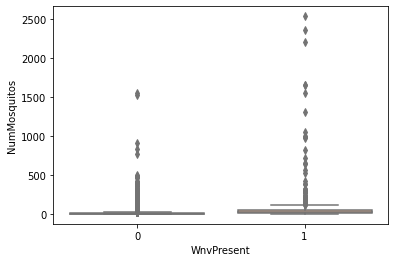

In [39]:
# Plot
sns.boxplot(data = train, y = 'NumMosquitos', x = "WnvPresent", palette = 'pastel')

Can't see nuts. Need to zoom in

(0.0, 300.0)

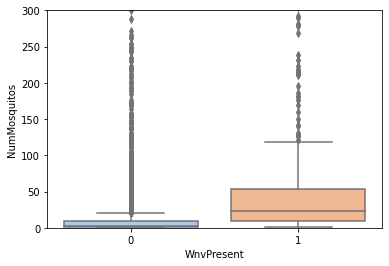

In [40]:
# Plot zoomed in
sns.boxplot(data = train, y = 'NumMosquitos', x = "WnvPresent", palette = 'pastel')
plt.ylim(0,300)

In [41]:
# Describe
train.groupby('WnvPresent').NumMosquitos.agg({'median','mean'})

mean  median
WnvPresent                   
0           11.747817     3.0
1           89.376368    23.0

(0.0, 300.0)

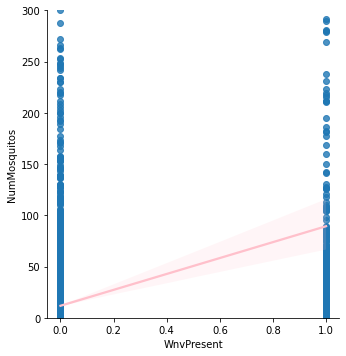

In [42]:
sns.lmplot(data = train, y = 'NumMosquitos', x = "WnvPresent", line_kws={'color': 'pink'})
plt.ylim(0,300)

### Plot mosquito count "heat map"

#### 2007

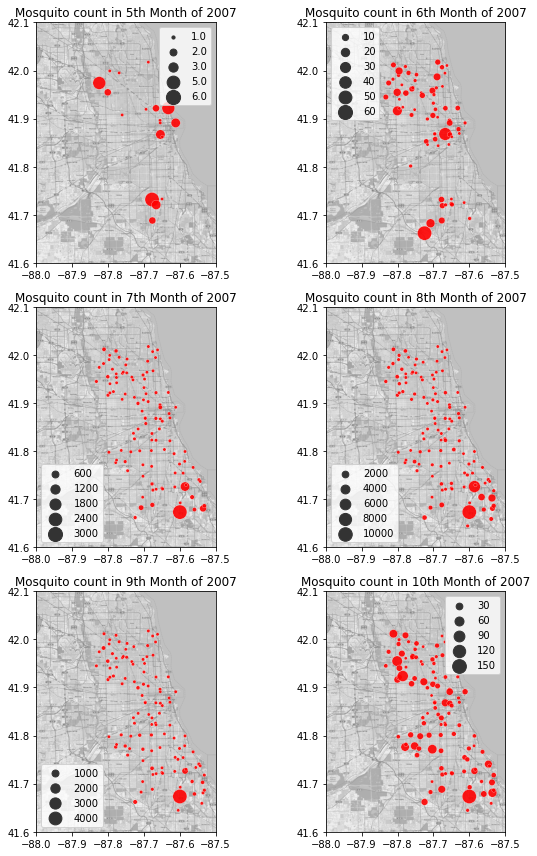

In [43]:
year = 2007

fig, axes = plt.subplots(nrows = 3, ncols = 2, figsize=(10,12))

months = train.loc[train['Date_year'] == year]['Date_month'].unique()

for month, axes in zip(months, axes.flat):
  locations = train.loc[
      ((train['Date_year'] == year) & (train['Date_month'] == month))].groupby(
      ['Longitude', 'Latitude']
  )['NumMosquitos'].sum(
  ).reset_index().values
  axes.imshow(mapdata, 
              cmap=plt.get_cmap('gray'), 
              extent=lon_lat_box, 
              aspect=aspect)
  sns.scatterplot(
      x = locations[:,0], 
      y = locations[:,1],
      size = locations[:,2],
      sizes = (10, 200),
      color = 'red',
      alpha = 0.9,
      ax = axes,
      )
  plt.tight_layout()
  axes.title.set_text(f'Mosquito count in {month}th Month of {year}')

Observations:
1. Mosquito count is not evenly distributed  -- see size of bubbles is different throughout the city
2. Mosquito count can grow expotentially over months -- see bubble value for the smallest bubble size in August vs value for the smallest bubble size in May

#### 2009

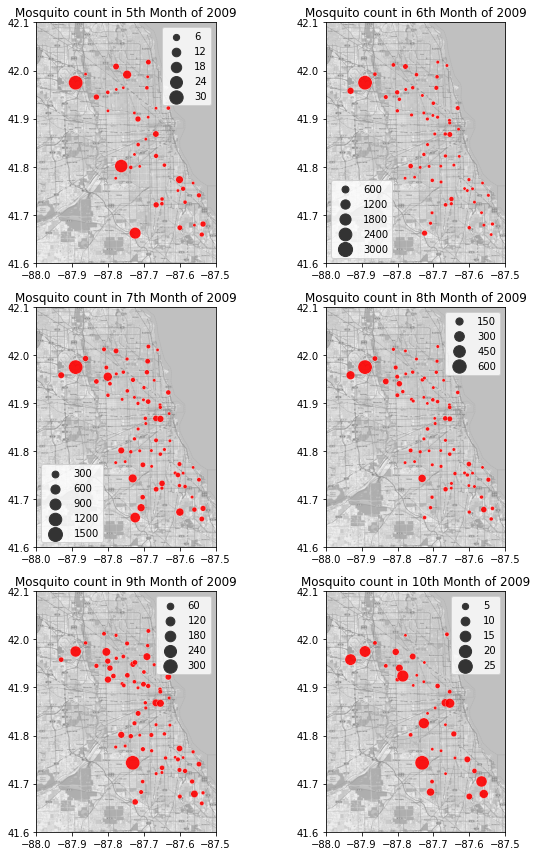

In [44]:
year = 2009

fig, axes = plt.subplots(nrows = 3, ncols = 2, figsize=(10,12))

months = train.loc[train['Date_year'] == year]['Date_month'].unique()

for month, axes in zip(months, axes.flat):
  locations = train.loc[
      ((train['Date_year'] == year) & (train['Date_month'] == month))].groupby(
      ['Longitude', 'Latitude']
  )['NumMosquitos'].sum(
  ).reset_index().values
  axes.imshow(mapdata, 
              cmap=plt.get_cmap('gray'), 
              extent=lon_lat_box, 
              aspect=aspect)
  sns.scatterplot(
      x = locations[:,0], 
      y = locations[:,1],
      size = locations[:,2],
      sizes = (10, 200),
      color = 'red',
      alpha = 0.9,
      ax = axes,
      )
  plt.tight_layout()
  axes.title.set_text(f'Mosquito count in {month}th Month of {year}')

In 2009, it looks like mosquito starts growing in Northwest first, instead of Southeast. So it seems like the Southeast learnt its lesson in 2007.

#### 2011

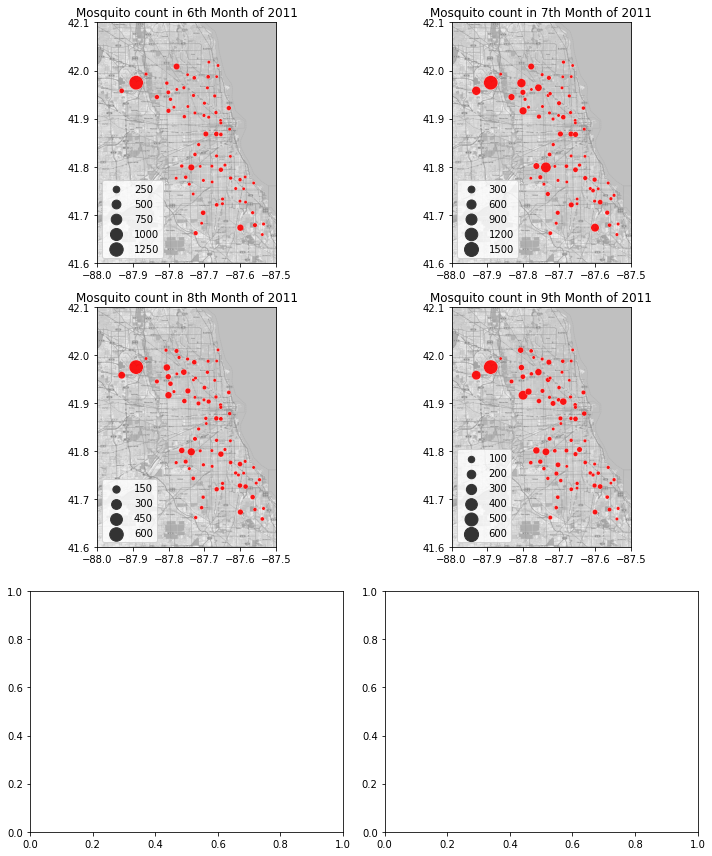

In [45]:
year = 2011

fig, axes = plt.subplots(nrows = 3, ncols = 2, figsize=(10,12))

months = train.loc[train['Date_year'] == year]['Date_month'].unique()

for month, axes in zip(months, axes.flat):
  locations = train.loc[
      ((train['Date_year'] == year) & (train['Date_month'] == month))].groupby(
      ['Longitude', 'Latitude']
  )['NumMosquitos'].sum(
  ).reset_index().values
  axes.imshow(mapdata, 
              cmap=plt.get_cmap('gray'), 
              extent=lon_lat_box, 
              aspect=aspect)
  sns.scatterplot(
      x = locations[:,0], 
      y = locations[:,1],
      size = locations[:,2],
      sizes = (10, 200),
      color = 'red',
      alpha = 0.9,
      ax = axes,
      )
  plt.tight_layout()
  axes.title.set_text(f'Mosquito count in {month}th Month of {year}')

Mosquito count seems to be way lesser than 2007 and 2009, and still seems to be concentrated in Northwestern part of city

#### 2013

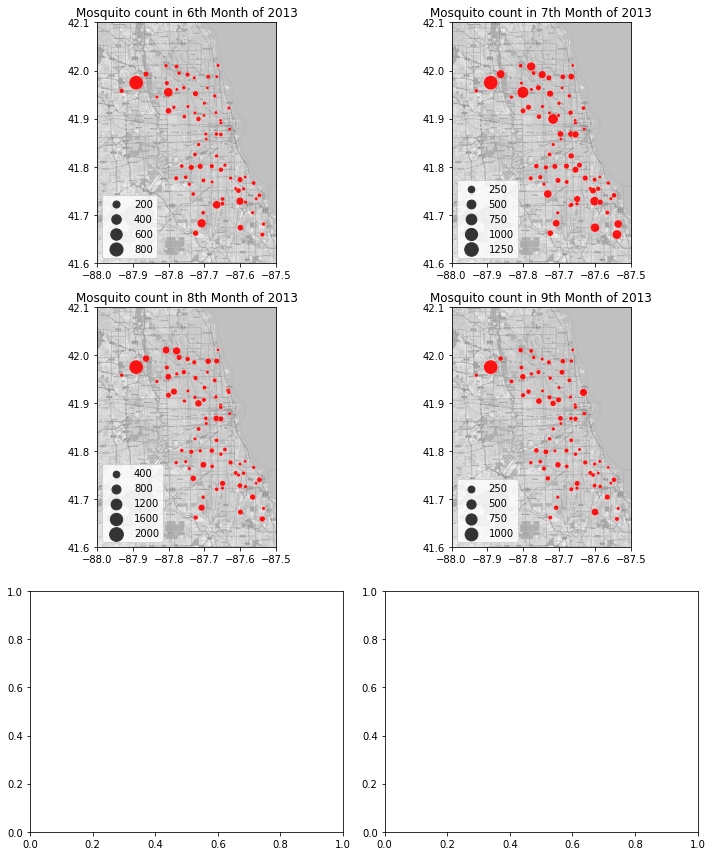

In [46]:
year = 2013

fig, axes = plt.subplots(nrows = 3, ncols = 2, figsize=(10,12))

months = train.loc[train['Date_year'] == year]['Date_month'].unique()

for month, axes in zip(months, axes.flat):
  locations = train.loc[
      ((train['Date_year'] == year) & (train['Date_month'] == month))].groupby(
      ['Longitude', 'Latitude']
  )['NumMosquitos'].sum(
  ).reset_index().values
  axes.imshow(mapdata, 
              cmap=plt.get_cmap('gray'), 
              extent=lon_lat_box, 
              aspect=aspect)
  sns.scatterplot(
      x = locations[:,0], 
      y = locations[:,1],
      size = locations[:,2],
      sizes = (10, 200),
      color = 'red',
      alpha = 0.9,
      ax = axes,
      )
  plt.tight_layout()
  axes.title.set_text(f'Mosquito count in {month}th Month of {year}')

### Plot time evolution of virus infections

#### 2007

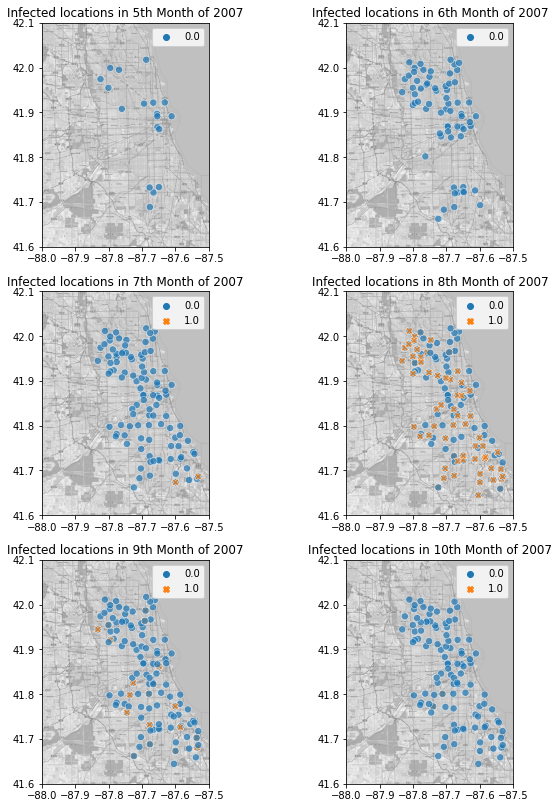

In [47]:
# Plot
year = 2007

fig, axes = plt.subplots(nrows = 3, ncols = 2, figsize=(10,14))

months = train.loc[train['Date_year'] == year]['Date_month'].unique()

for month, axes in zip(months, axes.flat):
  locations = train.loc[((train['Date_year'] == year) & (train['Date_month'] == month)), 
  ['Longitude', 'Latitude', 'WnvPresent']
  ].drop_duplicates().values
  axes.imshow(mapdata, 
              cmap=plt.get_cmap('gray'), 
              extent=lon_lat_box, 
              aspect=aspect)
  sns.scatterplot(
      x = locations[:,0], 
      y = locations[:,1],
      hue = locations[:,2],
      style = locations[:,2],
      s = 50,
      alpha = 0.7,
      ax = axes,
      )
  axes.title.set_text(f'Infected locations in {month}th Month of {year}')

#### 2009

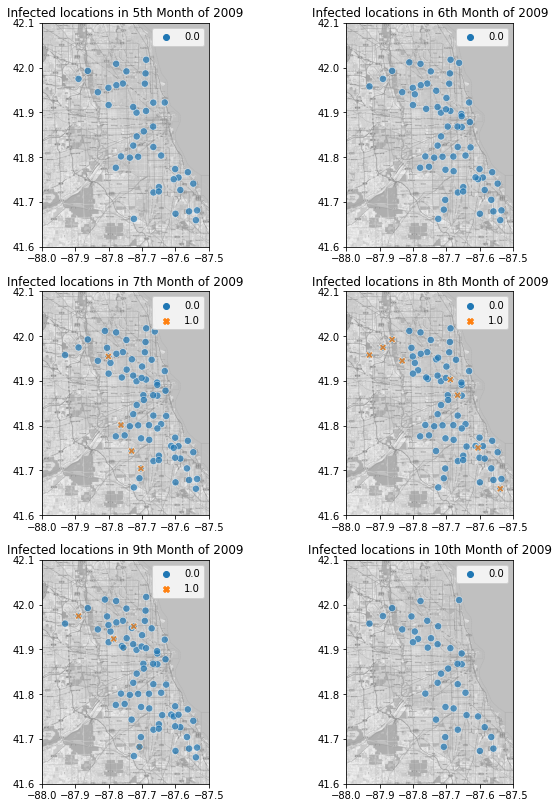

In [48]:
# Plot
year = 2009

fig, axes = plt.subplots(nrows = 3, ncols = 2, figsize=(10,14))

months = train.loc[train['Date_year'] == year]['Date_month'].unique()

for month, axes in zip(months, axes.flat):
  locations = train.loc[((train['Date_year'] == year) & (train['Date_month'] == month)), 
  ['Longitude', 'Latitude', 'WnvPresent']
  ].drop_duplicates().values
  axes.imshow(mapdata, 
              cmap=plt.get_cmap('gray'), 
              extent=lon_lat_box, 
              aspect=aspect)
  sns.scatterplot(
      x = locations[:,0], 
      y = locations[:,1],
      hue = locations[:,2],
      style = locations[:,2],
      s = 50,
      alpha = 0.7,
      ax = axes,
      )
  axes.title.set_text(f'Infected locations in {month}th Month of {year}')

#### 2011

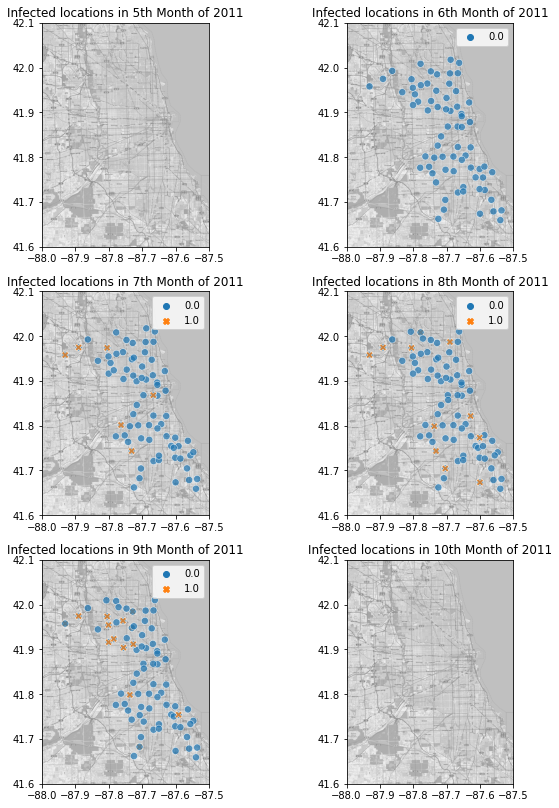

In [49]:
# Plot
year = 2011

fig, axes = plt.subplots(nrows = 3, ncols = 2, figsize=(10,14))

# months = train.loc[train['Date_year'] == year]['Date_month'].unique()
months = [5,6,7,8,9,10]

for month, axes in zip(months, axes.flat):
  locations = train.loc[((train['Date_year'] == year) & (train['Date_month'] == month)), 
  ['Longitude', 'Latitude', 'WnvPresent']
  ].drop_duplicates().values
  axes.imshow(mapdata, 
              cmap=plt.get_cmap('gray'), 
              extent=lon_lat_box, 
              aspect=aspect)
  sns.scatterplot(
      x = locations[:,0], 
      y = locations[:,1],
      hue = locations[:,2],
      style = locations[:,2],
      s = 50,
      alpha = 0.7,
      ax = axes,
      )
  axes.title.set_text(f'Infected locations in {month}th Month of {year}')

#### 2013

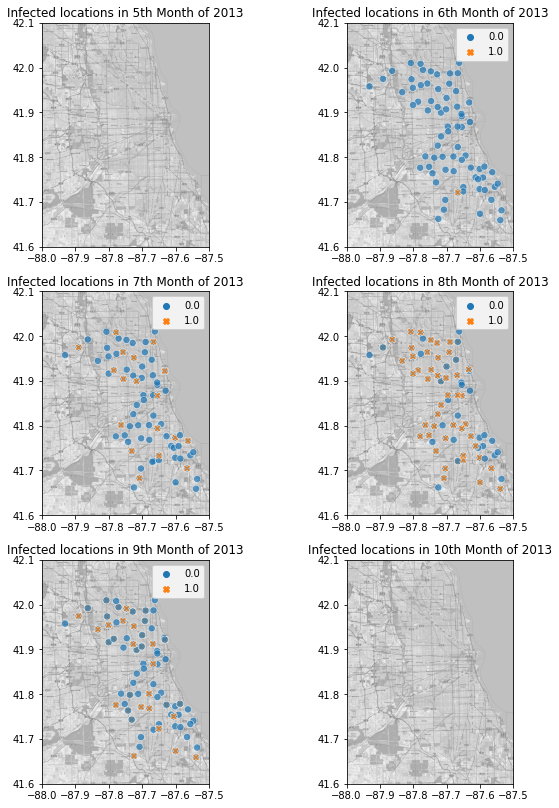

In [50]:
# Plot
year = 2013

fig, axes = plt.subplots(nrows = 3, ncols = 2, figsize=(10,14))

# months = train.loc[train['Date_year'] == year]['Date_month'].unique()
months = [5,6,7,8,9,10]

for month, axes in zip(months, axes.flat):
  locations = train.loc[((train['Date_year'] == year) & (train['Date_month'] == month)), 
  ['Longitude', 'Latitude', 'WnvPresent']
  ].drop_duplicates().values
  axes.imshow(mapdata, 
              cmap=plt.get_cmap('gray'), 
              extent=lon_lat_box, 
              aspect=aspect)
  sns.scatterplot(
      x = locations[:,0], 
      y = locations[:,1],
      hue = locations[:,2],
      style = locations[:,2],
      s = 50,
      alpha = 0.7,
      ax = axes,
      )
  axes.title.set_text(f'Infected locations in {month}th Month of {year}')

Observations:
- In 2007 and 2009, traps were set and analyzed in May and Oct, but in 2011 and 2013, they stopped doing it
- 2007 and 2013 look particularly bad for infections
- August seems to be the peak period when infections set in
- Infections seem to be focused on the western part of Chicago

## Conclusions for Train set

1. Out of 7 species of mosquitoes, 3 are proven to be carriers of the WNV. They also make up majority of the species sampled. One can reasonably infer that WNV is not present in the test set if a particular sample belongs to the other 4 species.
2. Mosquito count is not evenly spread throughout the city. The south eastern part of the city seems to have higher mosquito count.
3. WNV exhibits strong seasonality. It is practically absent in the months of May and June, starts peaking up in July, reach maximum infection in August, then drop in September before disappearing in October. It seems to suggest that the heat of the summer months is correlated with rising infections.


## Test dataset

In [51]:
test.shape

(116293, 11)

In [52]:
# Force full description of Test set
test.describe(include = 'all')

Id        Date  \
count   116293.000000      116293   
unique            NaN          95   
top               NaN  2012-07-09   
freq              NaN        1293   
mean     58147.000000         NaN   
std      33571.041765         NaN   
min          1.000000         NaN   
25%      29074.000000         NaN   
50%      58147.000000         NaN   
75%      87220.000000         NaN   
max     116293.000000         NaN   

                                                  Address  \
count                                              116293   
unique                                                151   
top     ORD Terminal 5, O'Hare International Airport, ...   
freq                                                 1468   
mean                                                  NaN   
std                                                   NaN   
min                                                   NaN   
25%                                                   NaN   
50%                                                   NaN   
75%                                                   NaN   
max                                                   NaN   

                       Species          Block           Street    Trap  \
count                   116293  116293.000000           116293  116293   
unique                       8            NaN              139     149   
top     CULEX PIPIENS/RESTUANS            NaN   N OAK PARK AVE    T009   
freq                     15359            NaN             1617    1528   
mean                       NaN      41.131100              NaN     NaN   
std                        NaN      24.864726              NaN     NaN   
min                        NaN      10.000000              NaN     NaN   
25%                        NaN      18.000000              NaN     NaN   
50%                        NaN      39.000000              NaN     NaN   
75%                        NaN      61.000000              NaN     NaN   
max                        NaN      98.000000              NaN     NaN   

                    AddressNumberAndStreet       Latitude      Longitude  \
count                               116293  116293.000000  116293.000000   
unique                                 151            NaN            NaN   
top     1000  W OHARE AIRPORT, Chicago, IL            NaN            NaN   
freq                                  1468            NaN            NaN   
mean                                   NaN      41.849389     -87.693658   
std                                    NaN       0.106593       0.080699   
min                                    NaN      41.644612     -87.930995   
25%                                    NaN      41.753411     -87.750938   
50%                                    NaN      41.862292     -87.694991   
75%                                    NaN      41.951866     -87.648860   
max                                    NaN      42.017430     -87.531635   

        AddressAccuracy  
count     116293.000000  
unique              NaN  
top                 NaN  
freq                NaN  
mean           7.954357  
std            1.252733  
min            3.000000  
25%            8.000000  
50%            8.000000  
75%            9.000000  
max            9.000000

Bad news:
- There are more unique trap locations in the Test set than Train. Therefore, it is not possible to dummify the trap locations in the Train set by Address, Trap ID, or Street name, as the classification model won't be able to predict on something it hasn't seen in the Train set. May have to use Lat/Long instead.
- I don't know why there are 10 times more row counts in Test than Train...116293 in total!! Need to investigate further.

### Check why so many rows

In [53]:
# Check for duplicates
test.duplicated().sum()

0

There are no duplicates, so that's not the reason for so many rows.

In [54]:
# Multiply date.count * address.count * species.count
test.Date.nunique() * test.Address.nunique() * test.Species.nunique()

114760

In [55]:
116293 - 114760

1533

**KNN** Kaggle seems to have created all possible permutations of location/date/species for the test set. I think i am closer to the answer now. Still need to figure out how the remaining 1533 rows came about...

### Add date columns

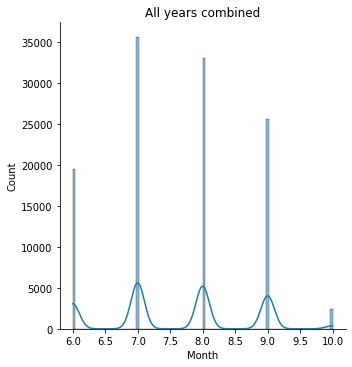

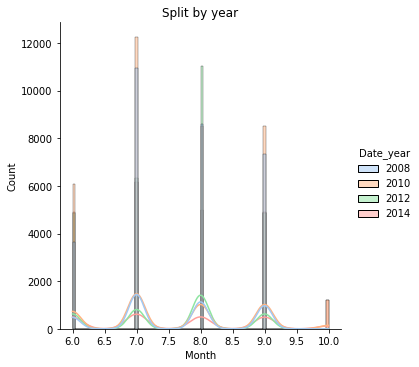

In [56]:
# Convert to datetime
test['Date'] = pd.to_datetime(test['Date'])

# Plot months
test['Date_month'] = test['Date'].map(lambda x: x.month)
test['Date_year'] = test['Date'].map(lambda x: x.year)

# All years combined
ax1 = sns.displot(
    data = test, 
    x = "Date_month", 
    kde = True
)
ax1.set(xlabel="Month", ylabel = "Count", title = "All years combined")

# Split by years
ax2 = sns.displot(
    data = test, 
    x = "Date_month", 
    kde = True, 
    hue = "Date_year", 
    palette = "pastel"
)
ax2.set(xlabel="Month", ylabel = "Count", title = "Split by year");

## Spray dataset

In [57]:
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 10)
spray.loc[spray.duplicated()]

Date        Time   Latitude  Longitude
485   2011-09-07  7:43:40 PM  41.983917 -87.793088
490   2011-09-07  7:44:32 PM  41.986460 -87.794225
491   2011-09-07  7:44:32 PM  41.986460 -87.794225
492   2011-09-07  7:44:32 PM  41.986460 -87.794225
493   2011-09-07  7:44:32 PM  41.986460 -87.794225
...          ...         ...        ...        ...
1025  2011-09-07  7:44:32 PM  41.986460 -87.794225
1026  2011-09-07  7:44:32 PM  41.986460 -87.794225
1027  2011-09-07  7:44:32 PM  41.986460 -87.794225
1028  2011-09-07  7:44:32 PM  41.986460 -87.794225
1029  2011-09-07  7:44:32 PM  41.986460 -87.794225

[541 rows x 4 columns]

In [58]:
spray.loc[spray.Time.isnull()]

Date Time   Latitude  Longitude
1030  2011-09-07  NaN  41.987092 -87.794286
1031  2011-09-07  NaN  41.987620 -87.794382
1032  2011-09-07  NaN  41.988004 -87.794574
1033  2011-09-07  NaN  41.988292 -87.795486
1034  2011-09-07  NaN  41.988100 -87.796014
...          ...  ...        ...        ...
1609  2011-09-07  NaN  41.995876 -87.811615
1610  2011-09-07  NaN  41.995972 -87.810271
1611  2011-09-07  NaN  41.995684 -87.810319
1612  2011-09-07  NaN  41.994724 -87.810415
1613  2011-09-07  NaN  41.993092 -87.810415

[584 rows x 4 columns]

In [59]:
spray['Date'] = pd.to_datetime(spray['Date'])

In [60]:
spray.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14835 entries, 0 to 14834
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       14835 non-null  datetime64[ns]
 1   Time       14251 non-null  object        
 2   Latitude   14835 non-null  float64       
 3   Longitude  14835 non-null  float64       
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 463.7+ KB


## Weather dataset

### Check for differences between the two weather station

In [61]:
weather.groupby("Station").mean()

Tmax       Tmin   DewPoint  ResultSpeed  ResultDir
Station                                                         
1        75.978940  56.730978  53.377717     6.987092   17.65625
2        76.353261  58.889946  53.538043     6.934239   17.33356

First glance shows that no major differences for a few columns. Will revisit this after we clean the data and convert more columns from 'object' to 'float'.

### Fix missing data before merging with Train & Test

In [62]:
pd.set_option('display.max_rows', 22)
weather.isin(["M"]).sum()


Station           0
Date              0
Tmax              0
Tmin              0
Tavg             11
Depart         1472
DewPoint          0
WetBulb           4
Heat             11
Cool             11
Sunrise           0
Sunset            0
CodeSum           0
Depth          1472
Water1         2944
SnowFall       1472
PrecipTotal       2
StnPressure       4
SeaLevel          9
ResultSpeed       0
ResultDir         0
AvgSpeed          3
dtype: int64

Drop:
- Depart
- Depth
- Water1
- SnowFall

as they have too many missing values
- Heat 
- Cool

as they are just shift transformations of Tavg so they are perfectly collinear

Impute values for:
- Tavg 
- PrecipTotal
- StnPressure
- SeaLevel
- AvgSpeed


#### Drop columns

In [63]:
# Drop useless columns
weather.drop(columns = ['Depart', 'Depth', 'Water1', 'SnowFall', 
                        'Heat', 'Cool'],
             inplace = True)

# Check
weather.isin(["M"]).sum()

Station         0
Date            0
Tmax            0
Tmin            0
Tavg           11
DewPoint        0
WetBulb         4
Sunrise         0
Sunset          0
CodeSum         0
PrecipTotal     2
StnPressure     4
SeaLevel        9
ResultSpeed     0
ResultDir       0
AvgSpeed        3
dtype: int64

#### Fix Tavg


In [64]:
# Look at rows with missing Tavg data
weather.loc[weather.Tavg == 'M']

Station        Date  Tmax  Tmin Tavg  ...  StnPressure SeaLevel  \
7           2  2007-05-04    78    51    M  ...        29.36    30.04   
505         2  2008-07-08    86    46    M  ...        29.16    29.80   
675         2  2008-10-01    62    46    M  ...        29.30    29.96   
1637        2  2011-07-22   100    71    M  ...        29.23    29.86   
2067        2  2012-08-22    84    72    M  ...        29.39        M   
2211        2  2013-05-02    71    42    M  ...        29.51    30.17   
2501        2  2013-09-24    91    52    M  ...        29.33    30.00   
2511        2  2013-09-29    84    53    M  ...        29.36    30.01   
2525        2  2013-10-06    76    48    M  ...        29.10    29.76   
2579        2  2014-05-02    80    47    M  ...        29.10    29.79   
2811        2  2014-08-26    86    49    M  ...        29.41    30.04   

     ResultSpeed ResultDir AvgSpeed  
7           10.1         7     10.4  
505          7.4        24      8.3  
675         10.9        33     11.0  
1637         3.8        10      8.2  
2067         4.7        19        M  
2211        15.8         2     16.1  
2501         5.8         9      7.7  
2511         6.3        36      7.8  
2525        10.1        25     10.6  
2579        10.7        23     11.9  
2811         1.3        15      5.8  

[11 rows x 16 columns]

Missing rows have Tmax and Tmin. Use these two values to imput Tavg.

In [65]:
# Create custom function
def calc_Tavg(x):
  if x.Tavg == "M":
    return (x.Tmin + x.Tmax) / 2
  else:
    return x.Tavg

# Impute values
weather['Tavg'] = weather.apply(lambda x: calc_Tavg(x), axis = 1)

# Check
display(weather.loc[weather.Tavg == 'M'])
display(weather.isin(["M"]).sum())

Empty DataFrame
Columns: [Station, Date, Tmax, Tmin, Tavg, DewPoint, WetBulb, Sunrise, Sunset, CodeSum, PrecipTotal, StnPressure, SeaLevel, ResultSpeed, ResultDir, AvgSpeed]
Index: []

[0 rows x 16 columns]

Station        0
Date           0
Tmax           0
Tmin           0
Tavg           0
DewPoint       0
WetBulb        4
Sunrise        0
Sunset         0
CodeSum        0
PrecipTotal    2
StnPressure    4
SeaLevel       9
ResultSpeed    0
ResultDir      0
AvgSpeed       3
dtype: int64

In [66]:
# Check dtype
weather.Tavg.dtypes

dtype('O')

In [67]:
# Force to float
weather.Tavg = weather.Tavg.astype(float)

In [68]:
# Check
weather.Tavg.dtypes

dtype('float64')

#### Fix Wetbulb

In [69]:
# Look at rows with missing WetBulb data
pd.set_option('display.max_columns', 16)
weather.loc[weather.WetBulb == 'M']

Station        Date  Tmax  Tmin  Tavg  DewPoint WetBulb Sunrise Sunset  \
848         1  2009-06-26    86    69  78.0        60       M    0418   1931   
2410        1  2013-08-10    81    64  73.0        57       M    0454   1900   
2412        1  2013-08-11    81    60  71.0        61       M    0455   1859   
2415        2  2013-08-12    85    69  77.0        63       M       -      -   

     CodeSum PrecipTotal StnPressure SeaLevel  ResultSpeed  ResultDir AvgSpeed  
848                 0.00           M    29.85          6.4          4      8.2  
2410                0.00           M    30.08          5.3          5      6.5  
2412      RA        0.01       29.35    30.07          2.0         27      3.0  
2415      RA        0.66       29.27    29.92          4.5         26      7.7

In [70]:
# Sample WetBlub values between the two stations
weather.groupby(['Date','Station'])['WetBulb','Tavg','DewPoint'].agg({'sum','count'}).head(20)

<ipython-input-70-597fd97804b1>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  weather.groupby(['Date','Station'])['WetBulb','Tavg','DewPoint'].agg({'sum','count'}).head(20)


WetBulb        Tavg       DewPoint      
                       sum count   sum count      sum count
Date       Station                                         
2007-05-01 1            56     1  67.0     1       51     1
           2            57     1  68.0     1       51     1
2007-05-02 1            47     1  51.0     1       42     1
           2            47     1  52.0     1       42     1
2007-05-03 1            48     1  56.0     1       40     1
           2            50     1  58.0     1       40     1
2007-05-04 1            50     1  58.0     1       41     1
           2            50     1  64.5     1       42     1
2007-05-05 1            49     1  60.0     1       38     1
           2            50     1  60.0     1       39     1
2007-05-06 1            46     1  59.0     1       30     1
           2            46     1  60.0     1       30     1
2007-05-07 1            54     1  65.0     1       41     1
           2            53     1  67.0     1       39     1
2007-05-08 1            62     1  68.0     1       58     1
           2            63     1  70.0     1       57     1
2007-05-09 1            63     1  69.0     1       59     1
           2            63     1  70.0     1       60     1
2007-05-10 1            60     1  70.0     1       52     1
           2            61     1  71.0     1       52     1

Looks like the WetBulb value is almost exactly the same between the two stations, so I will use the other station's WetBulb value to impute for the missing station's.

In [71]:
# Imput missing WetBulb manually
weather.loc[weather.WetBulb == 'M']

Station        Date  Tmax  Tmin  Tavg  DewPoint WetBulb Sunrise Sunset  \
848         1  2009-06-26    86    69  78.0        60       M    0418   1931   
2410        1  2013-08-10    81    64  73.0        57       M    0454   1900   
2412        1  2013-08-11    81    60  71.0        61       M    0455   1859   
2415        2  2013-08-12    85    69  77.0        63       M       -      -   

     CodeSum PrecipTotal StnPressure SeaLevel  ResultSpeed  ResultDir AvgSpeed  
848                 0.00           M    29.85          6.4          4      8.2  
2410                0.00           M    30.08          5.3          5      6.5  
2412      RA        0.01       29.35    30.07          2.0         27      3.0  
2415      RA        0.66       29.27    29.92          4.5         26      7.7

In [72]:
#1
print(weather.loc[(weather.Date == "2009-06-26") & (weather.Station == 2), 'WetBulb'])

#2
print(weather.loc[(weather.Date == "2013-08-10") & (weather.Station == 2), 'WetBulb'])

#3
print(weather.loc[(weather.Date == "2013-08-11") & (weather.Station == 2), 'WetBulb'])

#4
print(weather.loc[(weather.Date == "2013-08-12") & (weather.Station == 1), 'WetBulb'])

849    67
Name: WetBulb, dtype: object
2411    63
Name: WetBulb, dtype: object
2413    64
Name: WetBulb, dtype: object
2414    68
Name: WetBulb, dtype: object


In [73]:
#1
weather.loc[(weather.Date == "2009-06-26") & (weather.Station == 1), 'WetBulb'] = 67

#2
weather.loc[(weather.Date == "2013-08-10") & (weather.Station == 1), 'WetBulb'] = 63

#3
weather.loc[(weather.Date == "2013-08-11") & (weather.Station == 1), 'WetBulb'] = 64

#4
weather.loc[(weather.Date == "2013-08-12") & (weather.Station == 2), 'WetBulb'] = 68

In [74]:
# Check for "M"
display(weather.loc[weather.WetBulb == 'M'])
display(weather.isin(["M"]).sum())

Empty DataFrame
Columns: [Station, Date, Tmax, Tmin, Tavg, DewPoint, WetBulb, Sunrise, Sunset, CodeSum, PrecipTotal, StnPressure, SeaLevel, ResultSpeed, ResultDir, AvgSpeed]
Index: []

Station        0
Date           0
Tmax           0
Tmin           0
Tavg           0
DewPoint       0
WetBulb        0
Sunrise        0
Sunset         0
CodeSum        0
PrecipTotal    2
StnPressure    4
SeaLevel       9
ResultSpeed    0
ResultDir      0
AvgSpeed       3
dtype: int64

In [75]:
# Check dtypes
weather.WetBulb.dtypes

dtype('O')

In [76]:
# Force to float
weather.WetBulb = weather.WetBulb.astype(float)
# Check
weather.WetBulb.dtypes

dtype('float64')

In [77]:
# Check null
weather.WetBulb.isnull().sum()

0

#### Fix PrecipTotal

In [78]:
weather.PrecipTotal.unique()

array(['0.00', '  T', '0.13', '0.02', '0.38', '0.60', '0.14', '0.07',
       '0.11', '0.09', '1.01', '0.28', '0.04', '0.08', '0.01', '0.53',
       '0.19', '0.21', '0.32', '0.39', '0.31', '0.42', '0.27', '0.16',
       '0.58', '0.93', '0.05', '0.34', '0.15', '0.35', 'M', '0.40',
       '0.66', '0.30', '0.24', '0.43', '1.55', '0.92', '0.89', '0.17',
       '0.03', '1.43', '0.97', '0.26', '1.31', '0.06', '0.46', '0.29',
       '0.23', '0.41', '0.45', '0.83', '1.33', '0.91', '0.48', '0.37',
       '0.88', '2.35', '1.96', '0.20', '0.25', '0.18', '0.67', '0.36',
       '0.33', '1.28', '0.74', '0.76', '0.71', '0.95', '1.46', '0.12',
       '0.52', '0.64', '0.22', '1.24', '0.72', '0.73', '0.65', '1.61',
       '1.22', '0.50', '1.05', '2.43', '0.59', '2.90', '2.68', '1.23',
       '0.62', '6.64', '3.07', '1.44', '1.75', '0.82', '0.80', '0.86',
       '0.63', '0.55', '1.03', '0.70', '1.73', '1.38', '0.44', '1.14',
       '1.07', '3.97', '0.87', '0.78', '1.12', '0.68', '0.10', '0.61',
       '0.

Need to sort out '  T' and 'M'

In [79]:
# Look at rows with missing WetBulb data
pd.set_option('display.max_columns', 16)
weather.loc[((weather.PrecipTotal == 'M'))]

Station        Date  Tmax  Tmin  Tavg  DewPoint  WetBulb Sunrise Sunset  \
117        2  2007-06-28    73    61  67.0        56     61.0       -      -   
119        2  2007-06-29    71    56  64.0        56     60.0       -      -   

    CodeSum PrecipTotal StnPressure SeaLevel  ResultSpeed  ResultDir AvgSpeed  
117                   M       29.43    30.07         12.2          2     13.3  
119                   M       29.47    30.11          7.4          2      8.2

In [80]:
# Check PrecipTotal at the other station
print(weather.loc[(weather.Date == "2007-06-28") & (weather.Station == 1), 'PrecipTotal'])
print(weather.loc[(weather.Date == "2007-06-29") & (weather.Station == 1), 'PrecipTotal'])

116    0.00
Name: PrecipTotal, dtype: object
118    0.00
Name: PrecipTotal, dtype: object


Looks like there is no rainfall in those two days at the other station, so will overwrite with 0.

In [81]:
# Replace "T" with "0" as it means trace amount of rainfall
weather.PrecipTotal.replace(['  T','M'], 0, inplace = True)
weather.PrecipTotal = weather.PrecipTotal.astype(float)

In [82]:
# Check
display(weather.loc[weather.PrecipTotal == 'M'])
display(weather.loc[weather.PrecipTotal == '  T'])

Empty DataFrame
Columns: [Station, Date, Tmax, Tmin, Tavg, DewPoint, WetBulb, Sunrise, Sunset, CodeSum, PrecipTotal, StnPressure, SeaLevel, ResultSpeed, ResultDir, AvgSpeed]
Index: []

Empty DataFrame
Columns: [Station, Date, Tmax, Tmin, Tavg, DewPoint, WetBulb, Sunrise, Sunset, CodeSum, PrecipTotal, StnPressure, SeaLevel, ResultSpeed, ResultDir, AvgSpeed]
Index: []

In [83]:
weather.PrecipTotal.dtypes

dtype('float64')

### Check all data and drop more columns again

In [84]:
# Check dtypes
weather.dtypes

Station          int64
Date            object
Tmax             int64
Tmin             int64
Tavg           float64
DewPoint         int64
WetBulb        float64
Sunrise         object
Sunset          object
CodeSum         object
PrecipTotal    float64
StnPressure     object
SeaLevel        object
ResultSpeed    float64
ResultDir        int64
AvgSpeed        object
dtype: object

In [85]:
# Convert date
weather['Date'] = pd.to_datetime(weather['Date'])
# Check
weather.dtypes

Station                 int64
Date           datetime64[ns]
Tmax                    int64
Tmin                    int64
Tavg                  float64
DewPoint                int64
WetBulb               float64
Sunrise                object
Sunset                 object
CodeSum                object
PrecipTotal           float64
StnPressure            object
SeaLevel               object
ResultSpeed           float64
ResultDir               int64
AvgSpeed               object
dtype: object

Drop sunrise, sunset, codesum, pressure, sealevel, resultsspeed, resultdir, avgspeed

In [86]:
#Drop columns
weather.drop(columns = ['Sunrise', 'Sunset',
                        'CodeSum', 'StnPressure',
                        'SeaLevel', 'ResultSpeed',
                        'ResultDir', 'AvgSpeed'],
             inplace = True)

# Check
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Station      2944 non-null   int64         
 1   Date         2944 non-null   datetime64[ns]
 2   Tmax         2944 non-null   int64         
 3   Tmin         2944 non-null   int64         
 4   Tavg         2944 non-null   float64       
 5   DewPoint     2944 non-null   int64         
 6   WetBulb      2944 non-null   float64       
 7   PrecipTotal  2944 non-null   float64       
dtypes: datetime64[ns](1), float64(3), int64(4)
memory usage: 184.1 KB


### Consider combining two stations dataset as both are in same city

#### Show visuals

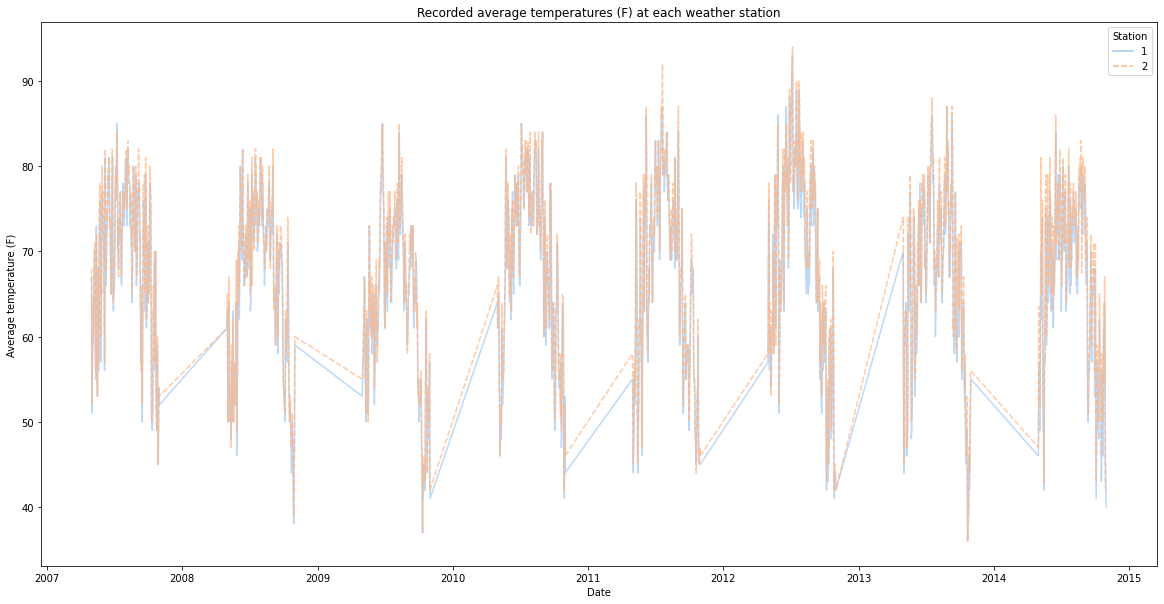

In [87]:
# Plot Tavg
plt.figure(figsize=(20,10))
sns.lineplot(data = weather, x = "Date", y = "Tavg", 
             hue = "Station", style = "Station",
             alpha = 0.7, palette = "pastel")
plt.title('Recorded average temperatures (F) at each weather station')
plt.xlabel('Date')
plt.ylabel('Average temperature (F)');

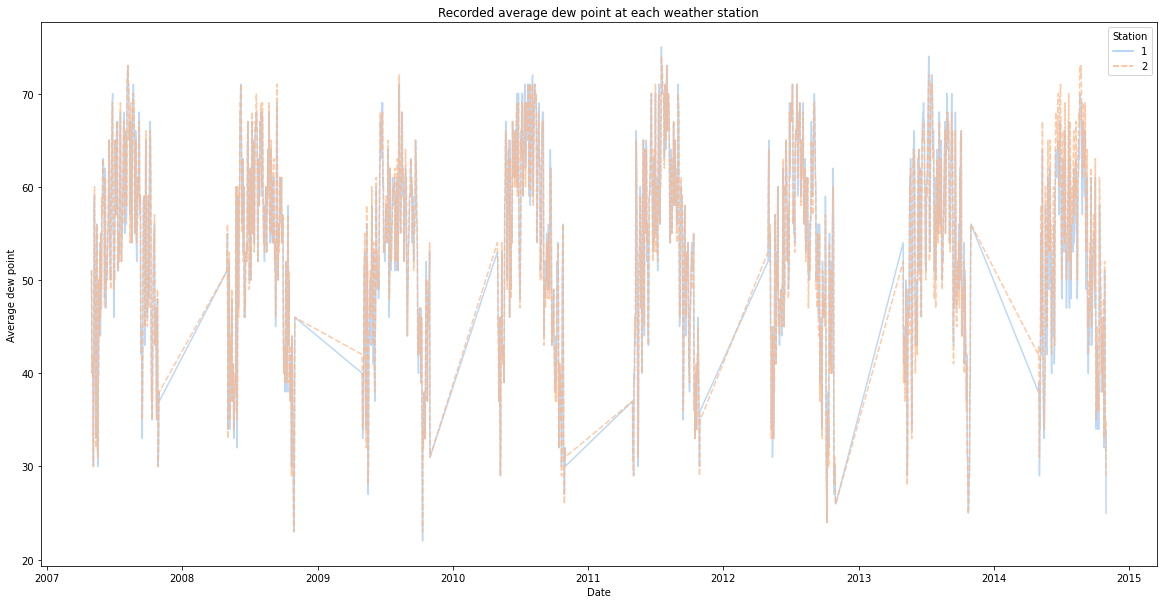

In [88]:
# Plot DewPoint
plt.figure(figsize=(20,10))
sns.lineplot(data = weather, x = "Date", y = "DewPoint", 
             hue = "Station", style = "Station",
             alpha = 0.7, palette = "pastel")
plt.title('Recorded average dew point at each weather station')
plt.xlabel('Date')
plt.ylabel('Average dew point');

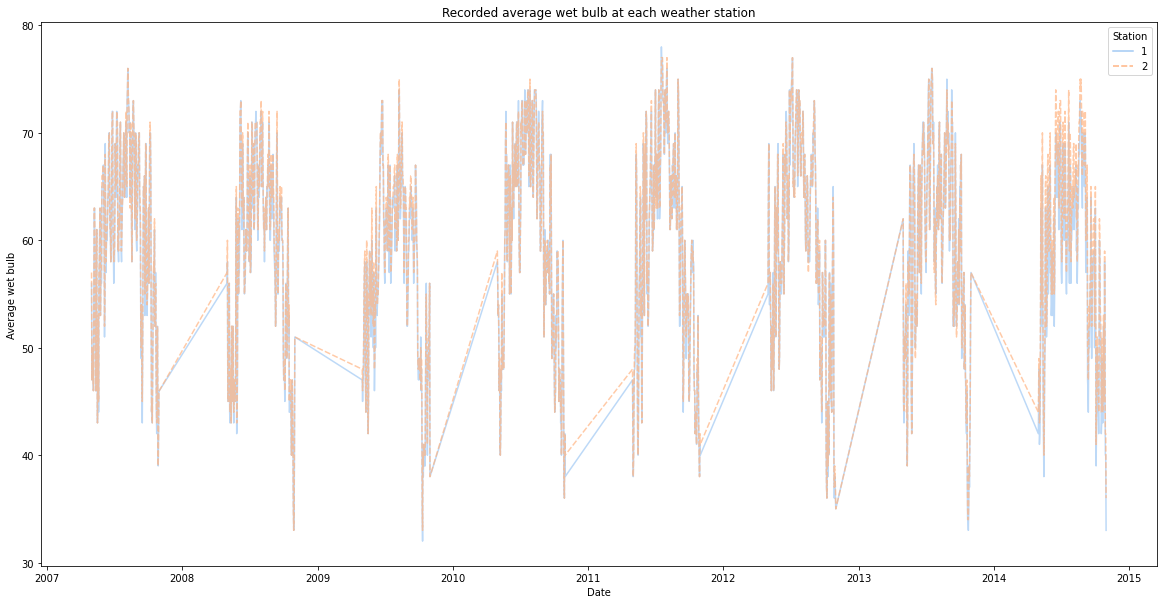

In [89]:
# Plot WetBulb
plt.figure(figsize=(20,10))
sns.lineplot(data = weather, x = "Date", y = "WetBulb", 
             hue = "Station", style = "Station",
             alpha = 0.7, palette = "pastel")
plt.title('Recorded average wet bulb at each weather station')
plt.xlabel('Date')
plt.ylabel('Average wet bulb');

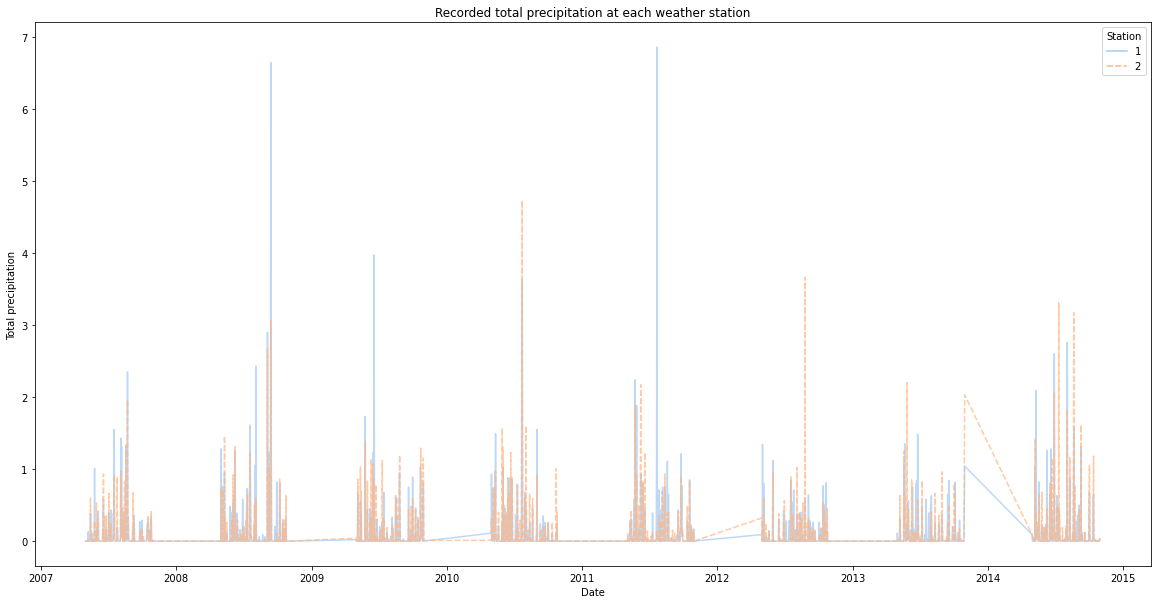

In [90]:
# Plot PrecipTotal
plt.figure(figsize=(20,10))
sns.lineplot(data = weather, x = "Date", y = "PrecipTotal", 
             hue = "Station", style = "Station",
             alpha = 0.7, palette = "pastel")
plt.title('Recorded total precipitation at each weather station')
plt.xlabel('Date')
plt.ylabel('Total precipitation');

Tavg, WetBulb, DewPoint look quite correlated to one another between the two stations. 
PrecipTotal can deviate quite a bit between the two stations, as seen by some blue spikes in 2008 and 2011.

The best strategy is the take the average of readings from both stations for each day.

#### Do t-test??

#### Combine by averaging

In [91]:
# Combine by taking average of readings from two stations
weather_combined = weather.groupby("Date").mean().drop(columns = "Station")

# Check
weather_combined

Tmax  Tmin   Tavg  DewPoint  WetBulb  PrecipTotal
Date                                                         
2007-05-01  83.5  51.0  67.50      51.0     56.5        0.000
2007-05-02  59.5  42.5  51.50      42.0     47.0        0.000
2007-05-03  66.5  47.0  57.00      40.0     49.0        0.000
2007-05-04  72.0  50.0  61.25      41.5     50.0        0.000
2007-05-05  66.0  53.5  60.00      38.5     49.5        0.000
...          ...   ...    ...       ...      ...          ...
2014-10-27  78.0  52.5  65.50      51.5     58.5        0.010
2014-10-28  67.0  46.5  57.00      39.0     47.5        0.015
2014-10-29  49.0  38.0  44.00      33.0     41.0        0.000
2014-10-30  52.0  34.5  43.50      34.5     41.0        0.000
2014-10-31  48.0  33.5  41.00      27.0     34.5        0.035

[1472 rows x 6 columns]

### Show correlations to decide cols to drop

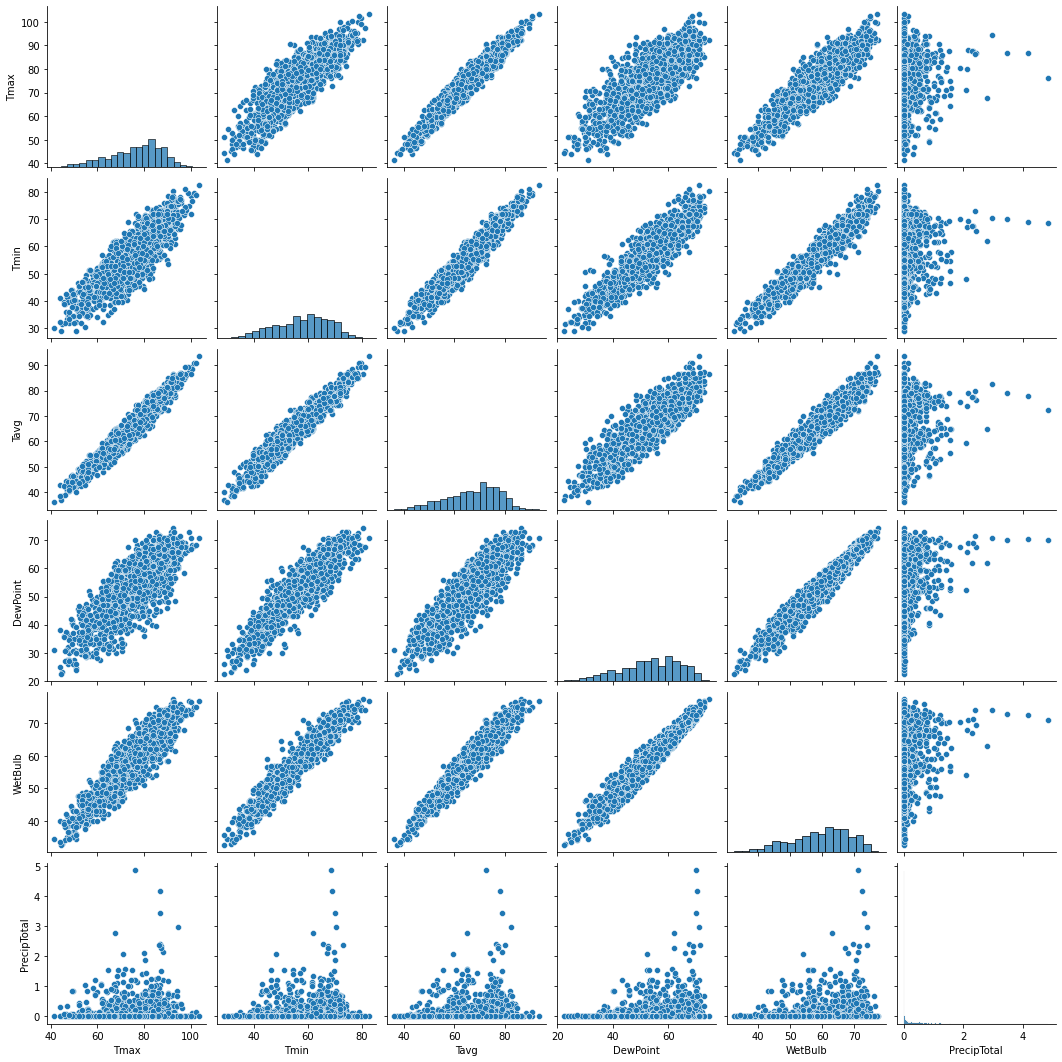

In [92]:
# Plots some charts
sns.pairplot(weather_combined)

Text(0.5, 1.0, 'Correlation Heatmap Plot of Numerical Variables')

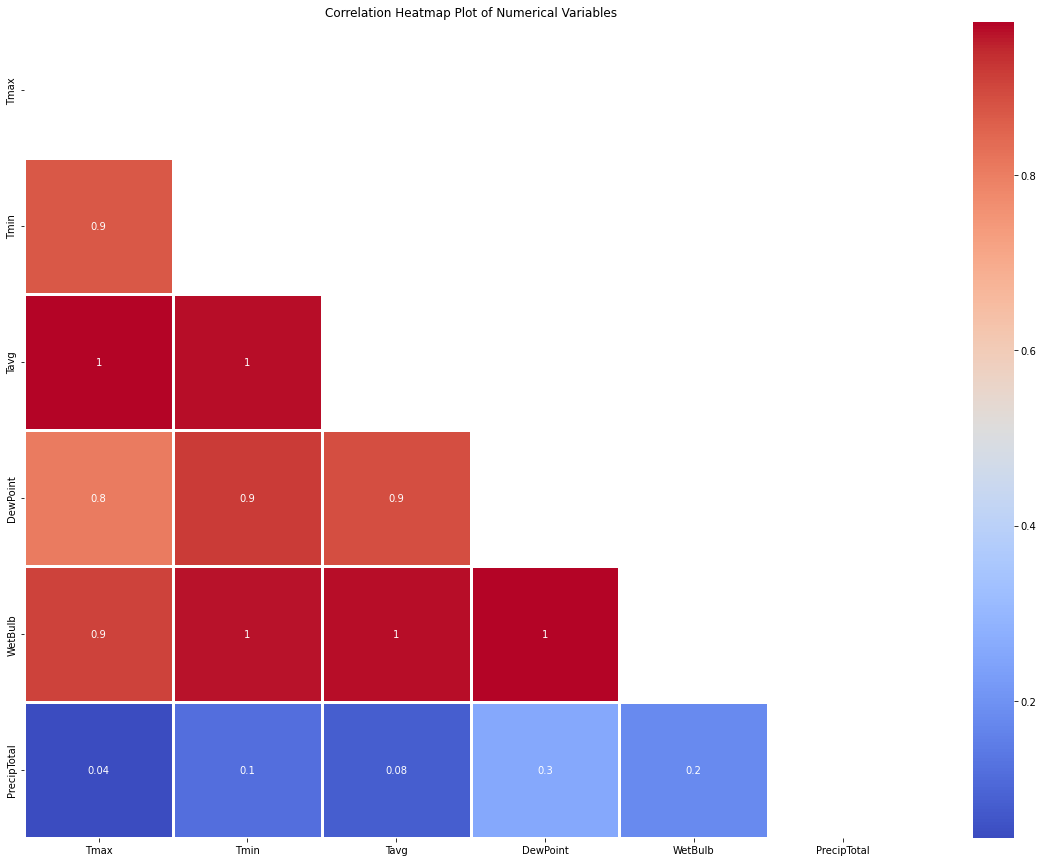

In [93]:
# Plot correlation
plt.figure(figsize=(20,15)) 

corr = weather_combined.corr()

sns.heatmap(
    data = corr, 
    annot = True,
    linewidths = 3,
    cmap = "coolwarm",
    mask = np.triu(np.ones_like(corr, dtype=bool)),
    fmt='.1g'
)

plt.title('Correlation Heatmap Plot of Numerical Variables')

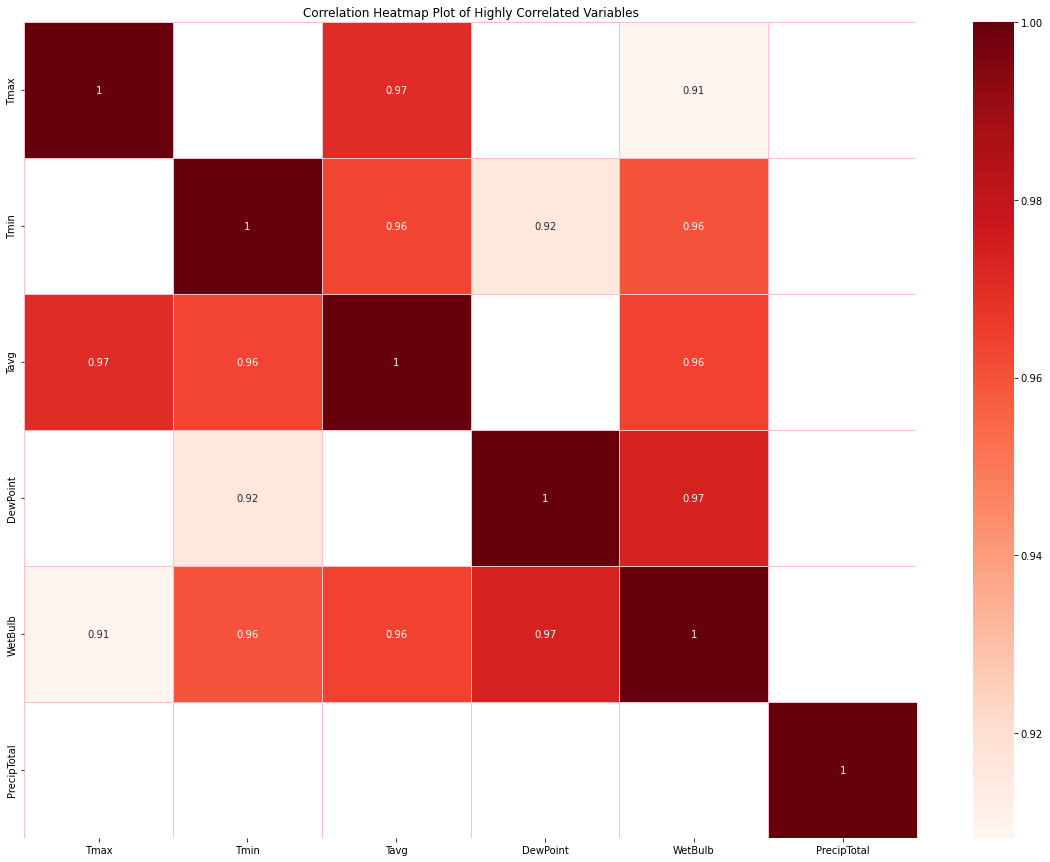

In [94]:
# Heatmap showing correlations above selected threshold of 90% correl

plt.figure(figsize=(20,15)) 

# correlation threshold for filtering
threshold = 0.9

# plot map
sns.heatmap(
    data = corr, 
    annot = True,
    linewidths = 1,
    cmap = "Reds",
    mask = corr < threshold,
    linecolor='pink'
)

# set title
plt.title('Correlation Heatmap Plot of Highly Correlated Variables');

Can probably keep WetBulb and PrecipTotal and drop the rest, as WetBulb is >>90% correlated to Tmax, Tmin, Tavg, DewPoint

In [95]:
# Drop useless columns

# weather_combined.drop(columns = ['Tmax', 'Tmin', 'Tavg', 'DewPoint'], inplace = True)
weather_combined

Tmax  Tmin   Tavg  DewPoint  WetBulb  PrecipTotal
Date                                                         
2007-05-01  83.5  51.0  67.50      51.0     56.5        0.000
2007-05-02  59.5  42.5  51.50      42.0     47.0        0.000
2007-05-03  66.5  47.0  57.00      40.0     49.0        0.000
2007-05-04  72.0  50.0  61.25      41.5     50.0        0.000
2007-05-05  66.0  53.5  60.00      38.5     49.5        0.000
...          ...   ...    ...       ...      ...          ...
2014-10-27  78.0  52.5  65.50      51.5     58.5        0.010
2014-10-28  67.0  46.5  57.00      39.0     47.5        0.015
2014-10-29  49.0  38.0  44.00      33.0     41.0        0.000
2014-10-30  52.0  34.5  43.50      34.5     41.0        0.000
2014-10-31  48.0  33.5  41.00      27.0     34.5        0.035

[1472 rows x 6 columns]

### Create lagged data series to account for life cycle of mozzie

In [96]:
# Sort Weather dataset by date first, just in case it's jumbled up internally, per Jireh's advice
weather_combined.sort_index(ascending = True, inplace = True)
weather_combined

Tmax  Tmin   Tavg  DewPoint  WetBulb  PrecipTotal
Date                                                         
2007-05-01  83.5  51.0  67.50      51.0     56.5        0.000
2007-05-02  59.5  42.5  51.50      42.0     47.0        0.000
2007-05-03  66.5  47.0  57.00      40.0     49.0        0.000
2007-05-04  72.0  50.0  61.25      41.5     50.0        0.000
2007-05-05  66.0  53.5  60.00      38.5     49.5        0.000
...          ...   ...    ...       ...      ...          ...
2014-10-27  78.0  52.5  65.50      51.5     58.5        0.010
2014-10-28  67.0  46.5  57.00      39.0     47.5        0.015
2014-10-29  49.0  38.0  44.00      33.0     41.0        0.000
2014-10-30  52.0  34.5  43.50      34.5     41.0        0.000
2014-10-31  48.0  33.5  41.00      27.0     34.5        0.035

[1472 rows x 6 columns]

In [97]:
# Create lagged data series, up to 7 days (Life Cycle of Mosquitoes)
columns = weather_combined.columns
for col in columns:
    for n in range(1,8):
        weather_combined[f'{col}_lag{n}'] = weather_combined[col].shift(n)
#     weather_combined[f'WetBulb_lag{n}'] = weather_combined['WetBulb'].shift(n)
#     weather_combined[f'PrecipTotal_lag{n}'] = weather_combined['PrecipTotal'].shift(n)

# Check
weather_combined

Tmax  Tmin   Tavg  DewPoint  WetBulb  PrecipTotal  Tmax_lag1  \
Date                                                                       
2007-05-01  83.5  51.0  67.50      51.0     56.5        0.000        NaN   
2007-05-02  59.5  42.5  51.50      42.0     47.0        0.000       83.5   
2007-05-03  66.5  47.0  57.00      40.0     49.0        0.000       59.5   
2007-05-04  72.0  50.0  61.25      41.5     50.0        0.000       66.5   
2007-05-05  66.0  53.5  60.00      38.5     49.5        0.000       72.0   
...          ...   ...    ...       ...      ...          ...        ...   
2014-10-27  78.0  52.5  65.50      51.5     58.5        0.010       65.0   
2014-10-28  67.0  46.5  57.00      39.0     47.5        0.015       78.0   
2014-10-29  49.0  38.0  44.00      33.0     41.0        0.000       67.0   
2014-10-30  52.0  34.5  43.50      34.5     41.0        0.000       49.0   
2014-10-31  48.0  33.5  41.00      27.0     34.5        0.035       52.0   

            Tmax_lag2  ...  WetBulb_lag7  PrecipTotal_lag1  PrecipTotal_lag2  \
Date                   ...                                                     
2007-05-01        NaN  ...           NaN               NaN               NaN   
2007-05-02        NaN  ...           NaN             0.000               NaN   
2007-05-03       83.5  ...           NaN             0.000             0.000   
2007-05-04       59.5  ...           NaN             0.000             0.000   
2007-05-05       66.5  ...           NaN             0.000             0.000   
...               ...  ...           ...               ...               ...   
2014-10-27       73.5  ...          50.0             0.000             0.000   
2014-10-28       65.0  ...          45.0             0.010             0.000   
2014-10-29       78.0  ...          43.5             0.015             0.010   
2014-10-30       67.0  ...          46.0             0.000             0.015   
2014-10-31       49.0  ...          52.5             0.000             0.000   

            PrecipTotal_lag3  PrecipTotal_lag4  PrecipTotal_lag5  \
Date                                                               
2007-05-01               NaN               NaN               NaN   
2007-05-02               NaN               NaN               NaN   
2007-05-03               NaN               NaN               NaN   
2007-05-04             0.000               NaN               NaN   
2007-05-05             0.000              0.00               NaN   
...                      ...               ...               ...   
2014-10-27             0.000              0.00               0.0   
2014-10-28             0.000              0.00               0.0   
2014-10-29             0.000              0.00               0.0   
2014-10-30             0.010              0.00               0.0   
2014-10-31             0.015              0.01               0.0   

            PrecipTotal_lag6  PrecipTotal_lag7  
Date                                            
2007-05-01               NaN               NaN  
2007-05-02               NaN               NaN  
2007-05-03               NaN               NaN  
2007-05-04               NaN               NaN  
2007-05-05               NaN               NaN  
...                      ...               ...  
2014-10-27               0.0             0.005  
2014-10-28               0.0             0.000  
2014-10-29               0.0             0.000  
2014-10-30               0.0             0.000  
2014-10-31               0.0             0.000  

[1472 rows x 48 columns]

## Merge Weather to Train/Test

In [98]:
# Merge Weather to Train
pd.set_option('display.max_rows', 10)
train.head()

Date                                           Address  \
0 2007-05-29       1100 Roosevelt Road, Chicago, IL 60608, USA   
1 2007-05-29       1100 Roosevelt Road, Chicago, IL 60608, USA   
2 2007-05-29  1100 South Peoria Street, Chicago, IL 60608, USA   
3 2007-05-29  1100 West Chicago Avenue, Chicago, IL 60642, USA   
4 2007-05-29    1500 North Long Avenue, Chicago, IL 60651, USA   

                  Species  Block        Street  Trap  \
0  CULEX PIPIENS/RESTUANS     11   W ROOSEVELT  T048   
1          CULEX RESTUANS     11   W ROOSEVELT  T048   
2          CULEX RESTUANS     11   S PEORIA ST  T091   
3          CULEX RESTUANS     11     W CHICAGO  T049   
4          CULEX RESTUANS     15    N LONG AVE  T153   

           AddressNumberAndStreet   Latitude  Longitude  AddressAccuracy  \
0  1100  W ROOSEVELT, Chicago, IL  41.867108 -87.654224                8   
1  1100  W ROOSEVELT, Chicago, IL  41.867108 -87.654224                8   
2  1100  S PEORIA ST, Chicago, IL  41.862292 -87.648860                8   
3    1100  W CHICAGO, Chicago, IL  41.896282 -87.655232                8   
4   1500  N LONG AVE, Chicago, IL  41.907645 -87.760886                8   

   Date_month  Date_year  NumMosquitos  WnvPresent  
0           5       2007             1           0  
1           5       2007             2           0  
2           5       2007             1           0  
3           5       2007             1           0  
4           5       2007             1           0

In [99]:
train.columns, train.shape

(Index(['Date', 'Address', 'Species', 'Block', 'Street', 'Trap',
        'AddressNumberAndStreet', 'Latitude', 'Longitude', 'AddressAccuracy',
        'Date_month', 'Date_year', 'NumMosquitos', 'WnvPresent'],
       dtype='object'),
 (8475, 14))

In [100]:
# Merger and acquisition
train = pd.merge(train, weather_combined, how = "inner", on = "Date")

# Check columns and shape again
train.columns, train.shape

(Index(['Date', 'Address', 'Species', 'Block', 'Street', 'Trap',
        'AddressNumberAndStreet', 'Latitude', 'Longitude', 'AddressAccuracy',
        'Date_month', 'Date_year', 'NumMosquitos', 'WnvPresent', 'Tmax', 'Tmin',
        'Tavg', 'DewPoint', 'WetBulb', 'PrecipTotal', 'Tmax_lag1', 'Tmax_lag2',
        'Tmax_lag3', 'Tmax_lag4', 'Tmax_lag5', 'Tmax_lag6', 'Tmax_lag7',
        'Tmin_lag1', 'Tmin_lag2', 'Tmin_lag3', 'Tmin_lag4', 'Tmin_lag5',
        'Tmin_lag6', 'Tmin_lag7', 'Tavg_lag1', 'Tavg_lag2', 'Tavg_lag3',
        'Tavg_lag4', 'Tavg_lag5', 'Tavg_lag6', 'Tavg_lag7', 'DewPoint_lag1',
        'DewPoint_lag2', 'DewPoint_lag3', 'DewPoint_lag4', 'DewPoint_lag5',
        'DewPoint_lag6', 'DewPoint_lag7', 'WetBulb_lag1', 'WetBulb_lag2',
        'WetBulb_lag3', 'WetBulb_lag4', 'WetBulb_lag5', 'WetBulb_lag6',
        'WetBulb_lag7', 'PrecipTotal_lag1', 'PrecipTotal_lag2',
        'PrecipTotal_lag3', 'PrecipTotal_lag4', 'PrecipTotal_lag5',
        'PrecipTotal_lag6', 'PrecipTotal_lag7'

In [101]:
# Repeat for test set
test.shape

# Merger and acquisition
test = pd.merge(test, weather_combined, how = "inner", on = "Date")

# Check columns and shape again
test.columns, test.shape

(Index(['Id', 'Date', 'Address', 'Species', 'Block', 'Street', 'Trap',
        'AddressNumberAndStreet', 'Latitude', 'Longitude', 'AddressAccuracy',
        'Date_month', 'Date_year', 'Tmax', 'Tmin', 'Tavg', 'DewPoint',
        'WetBulb', 'PrecipTotal', 'Tmax_lag1', 'Tmax_lag2', 'Tmax_lag3',
        'Tmax_lag4', 'Tmax_lag5', 'Tmax_lag6', 'Tmax_lag7', 'Tmin_lag1',
        'Tmin_lag2', 'Tmin_lag3', 'Tmin_lag4', 'Tmin_lag5', 'Tmin_lag6',
        'Tmin_lag7', 'Tavg_lag1', 'Tavg_lag2', 'Tavg_lag3', 'Tavg_lag4',
        'Tavg_lag5', 'Tavg_lag6', 'Tavg_lag7', 'DewPoint_lag1', 'DewPoint_lag2',
        'DewPoint_lag3', 'DewPoint_lag4', 'DewPoint_lag5', 'DewPoint_lag6',
        'DewPoint_lag7', 'WetBulb_lag1', 'WetBulb_lag2', 'WetBulb_lag3',
        'WetBulb_lag4', 'WetBulb_lag5', 'WetBulb_lag6', 'WetBulb_lag7',
        'PrecipTotal_lag1', 'PrecipTotal_lag2', 'PrecipTotal_lag3',
        'PrecipTotal_lag4', 'PrecipTotal_lag5', 'PrecipTotal_lag6',
        'PrecipTotal_lag7'],
       dtype='object'

## EDA: Correlation Heatmap and Pair Plots

### Drop columns that can't be hotencoded or useless

In [102]:
# Drop columns
train.drop(columns = ['Address', 'Block', 
                      'Street', 'AddressNumberAndStreet', 'AddressAccuracy',
                      'Date_year'],
           inplace = True)

test.drop(columns = ['Address', 'Block', 
                     'Street', 'AddressNumberAndStreet', 'AddressAccuracy',
                     'Date_year'],
           inplace = True)

### Create week of the year column for more granularity in prediction

In [103]:
# Create week column
train['Date_week'] = train['Date'].map(lambda x: x.week)
test['Date_week'] = test['Date'].map(lambda x: x.week)

### Heatmap

Text(0.5, 1.0, 'Correlation Heatmap Plot of Variables')

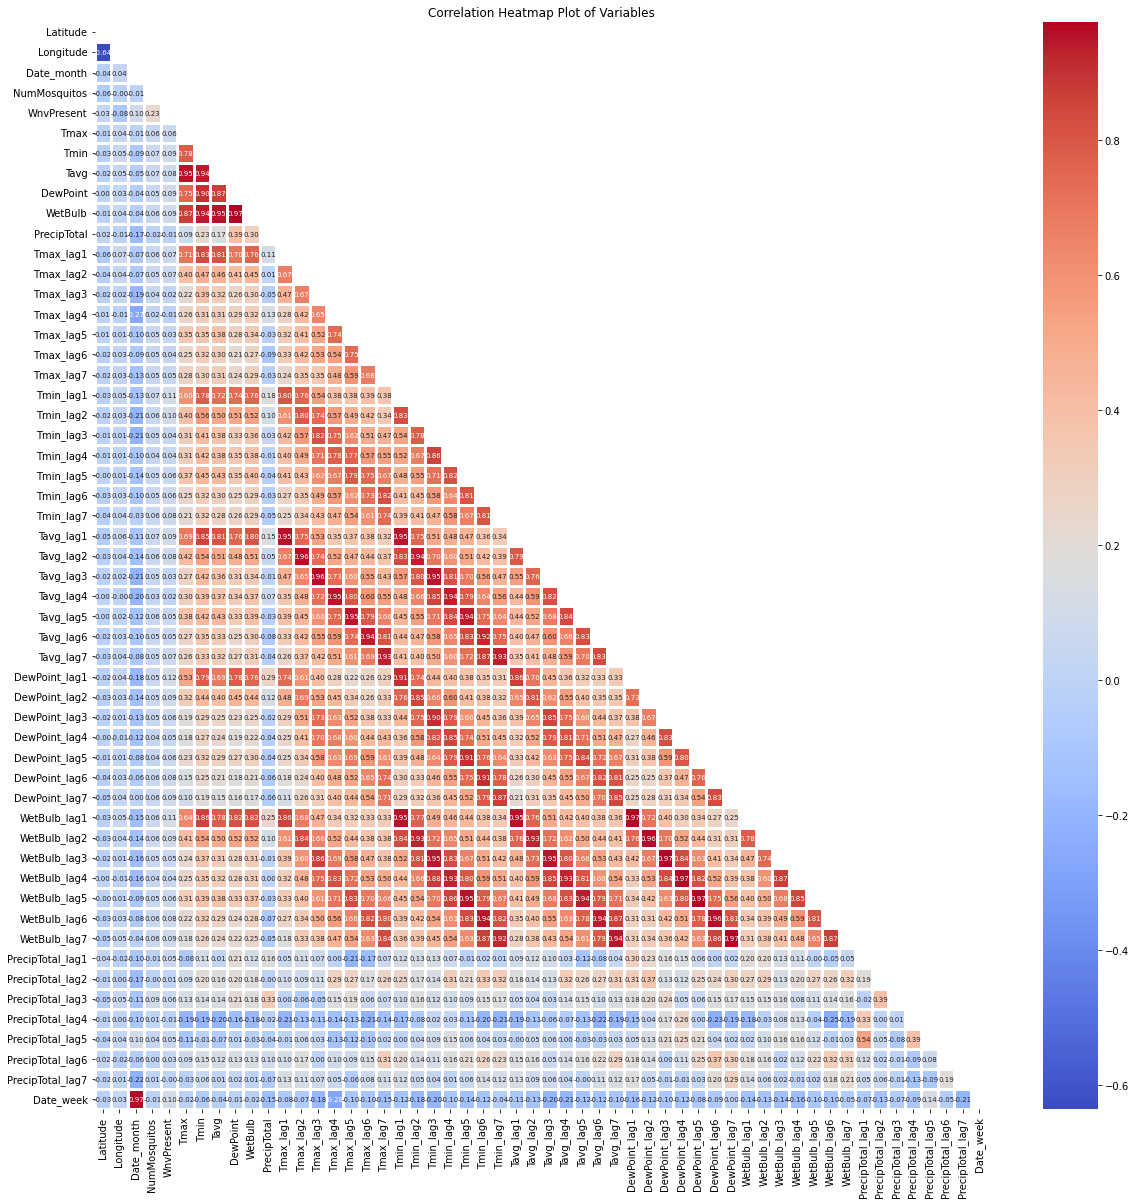

In [104]:
# Plot correlation
plt.figure(figsize=(20,20)) 

corr = train.corr()

sns.heatmap(
    data = corr, 
    annot = True,
    linewidths = 3,
    cmap = "coolwarm",
    mask = np.triu(np.ones_like(corr, dtype=bool)),
    fmt='.2f',
    annot_kws={"size":7} 
)

plt.title('Correlation Heatmap Plot of Variables')

Looks like PrecipTotal has a negative correlation to WnvPresent at lag=0, but the correlation with NumMosquitos and WnvPresent becomes the most positive when lag=3. 

For WetBulb, correlation with WnvPresent is highest at lag=1.

### Visual plots 


<AxesSubplot:xlabel='Date_week', ylabel='WnvPresent'>

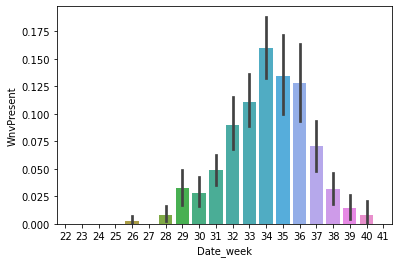

In [105]:
### Box plot of Date_week
sns.barplot(
  x = "Date_week",
  y = "WnvPresent",
  data = train,
)

<AxesSubplot:xlabel='Date_month', ylabel='WnvPresent'>

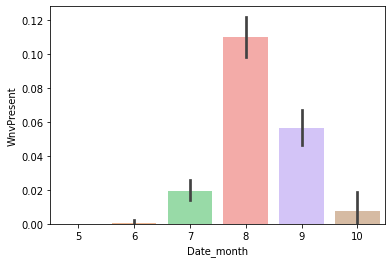

In [106]:
### Box plot of Date_week
sns.barplot(
  x = "Date_month",
  y = "WnvPresent",
  data = train,
  palette = "pastel"
)

<AxesSubplot:xlabel='WetBulb', ylabel='WnvPresent'>

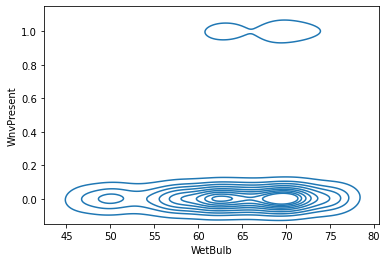

In [107]:
# Plot of terrain map: WetBulb  vs WnvPresent
sns.kdeplot(
  x = "WetBulb",
  y = "WnvPresent",
  data = train
)

<AxesSubplot:xlabel='PrecipTotal', ylabel='WnvPresent'>

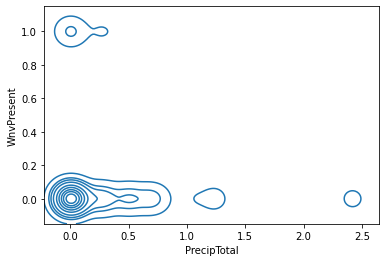

In [108]:
# Plot of terrain map: Rain vs WnvPresent
sns.kdeplot(
  x = "PrecipTotal",
  y = "WnvPresent",
  data = train
)

### Create cluster map

In [109]:
# Set up X and Z
X = train[['Latitude', 'Longitude', 'WnvPresent']]

ss = StandardScaler()
Z = ss.fit_transform(X[['Latitude', 'Longitude']])

In [110]:
# Instantiate and fit KMeans()
km = KMeans(n_clusters = 25)
km.fit(Z)
X['cluster_km'] = km.labels_

# Instantiate and fit DBSCAN()
db = DBSCAN (eps = 0.25, min_samples = 5)
db.fit(Z)
X['cluster_db'] = db.labels_

<ipython-input-110-3f16fa201c4a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['cluster_km'] = km.labels_
<ipython-input-110-3f16fa201c4a>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['cluster_db'] = db.labels_


In [111]:
X['cluster_km'].nunique(), X['cluster_db'].nunique()

(25, 28)

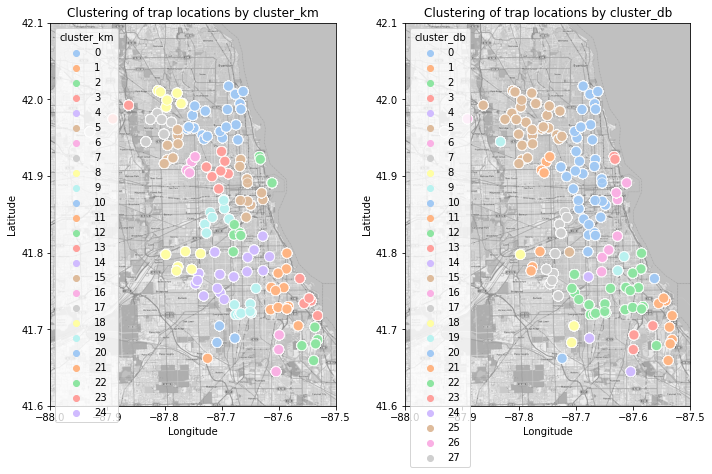

In [112]:
# Plot both map, clustered by KMeans and DBSCAN
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize=(10,14))

clusters = ['cluster_km', 'cluster_db']

for cluster_type, axes in zip(clusters, axes.flat):
  axes.imshow(mapdata, 
            cmap=plt.get_cmap('gray'), 
            extent=lon_lat_box, 
            aspect=aspect)

  sns.scatterplot(
      data = X,
      x = 'Longitude',
      y = 'Latitude',
      hue = cluster_type,
      s = 100,
      alpha = 0.7,
      palette = "pastel",
      ax = axes
  );
  plt.tight_layout()
  axes.title.set_text(f'Clustering of trap locations by {cluster_type}')




# Modeling

## Load more libraries for modeling

In [113]:
## Load new suite of libraries for modeling

# Preprocessing stuff
from sklearn.preprocessing import (
    LabelEncoder, 
    LabelBinarizer, 
    StandardScaler
)
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV, 
    RandomizedSearchCV,
    cross_val_score
)
from sklearn.compose import ColumnTransformer
from sklearn_pandas import DataFrameMapper
from sklearn.pipeline import Pipeline


# Import SMOTENC to deal with categorical columns
# from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE, SMOTENC

# Import models
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import (
    RandomForestClassifier, 
    ExtraTreesClassifier, 
    AdaBoostClassifier
)
from sklearn.tree import DecisionTreeClassifier, plot_tree
# import xgboost as xgb
from xgboost import XGBClassifier

# Performance measurement stuff
from sklearn.metrics import (
    confusion_matrix, 
    plot_confusion_matrix, 
    f1_score,
    roc_auc_score, 
    plot_roc_curve, 
    roc_curve
)
# Measure runtime
import time

import warnings
# warnings.filterwarnings('ignore')

# To calculate geo-distance
# !pip install haversine
# import haversine as hs

In [114]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8475 entries, 0 to 8474
Data columns (total 57 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Date              8475 non-null   datetime64[ns]
 1   Species           8475 non-null   object        
 2   Trap              8475 non-null   object        
 3   Latitude          8475 non-null   float64       
 4   Longitude         8475 non-null   float64       
 5   Date_month        8475 non-null   int64         
 6   NumMosquitos      8475 non-null   int64         
 7   WnvPresent        8475 non-null   int64         
 8   Tmax              8475 non-null   float64       
 9   Tmin              8475 non-null   float64       
 10  Tavg              8475 non-null   float64       
 11  DewPoint          8475 non-null   float64       
 12  WetBulb           8475 non-null   float64       
 13  PrecipTotal       8475 non-null   float64       
 14  Tmax_lag1         8475 n

In [115]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 116293 entries, 0 to 116292
Data columns (total 56 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Id                116293 non-null  int64         
 1   Date              116293 non-null  datetime64[ns]
 2   Species           116293 non-null  object        
 3   Trap              116293 non-null  object        
 4   Latitude          116293 non-null  float64       
 5   Longitude         116293 non-null  float64       
 6   Date_month        116293 non-null  int64         
 7   Tmax              116293 non-null  float64       
 8   Tmin              116293 non-null  float64       
 9   Tavg              116293 non-null  float64       
 10  DewPoint          116293 non-null  float64       
 11  WetBulb           116293 non-null  float64       
 12  PrecipTotal       116293 non-null  float64       
 13  Tmax_lag1         116293 non-null  float64       
 14  Tmax

- Since test set does not have NumMosquitos, and train set does not have Id, drop these columns
- Can drop the column "Date" as we have already extracted the month / week information and they are stored as "Date_month" and "Date_week" respectively. The year information is not relevant as that can't be used be trained as a predictor.

In [116]:
# Drop columns
train.drop(columns = ['Date'], inplace = True)
test.drop(columns = ['Date', 'Id'], inplace = True)

# Check
train.shape, test.shape

((8475, 56), (116293, 54))

## Save and load files

In [123]:
# Save files
train.to_csv('../data/train_cleaned.csv', index=False)
test.to_csv('../data/test_cleaned.csv', index=False)

# Load files
train = pd.read_csv('../data/train_cleaned.csv')
test = pd.read_csv('../data/test_cleaned.csv')
train.shape, test.shape

train_filtered = pd.read_csv('../data/train_filtered.csv')
test_filtered = pd.read_csv('../data/test_filtered.csv')

In [130]:
test_filtered.columns

Index(['Id', 'Species', 'Trap', 'Longitude', 'Latitude', 'Tmax', 'Tmin',
       'Tavg', 'DewPoint', 'WetBulb', 'PrecipTotal', 'month', 'Tmax_lag1',
       'Tmax_lag2', 'Tmax_lag3', 'Tmax_lag4', 'Tmax_lag5', 'Tmax_lag6',
       'Tmax_lag7', 'Tmin_lag1', 'Tmin_lag2', 'Tmin_lag3', 'Tmin_lag4',
       'Tmin_lag5', 'Tmin_lag6', 'Tmin_lag7', 'Tavg_lag1', 'Tavg_lag2',
       'Tavg_lag3', 'Tavg_lag4', 'Tavg_lag5', 'Tavg_lag6', 'Tavg_lag7',
       'DewPoint_lag1', 'DewPoint_lag2', 'DewPoint_lag3', 'DewPoint_lag4',
       'DewPoint_lag5', 'DewPoint_lag6', 'DewPoint_lag7', 'WetBulb_lag1',
       'WetBulb_lag2', 'WetBulb_lag3', 'WetBulb_lag4', 'WetBulb_lag5',
       'WetBulb_lag6', 'WetBulb_lag7', 'PrecipTotal_lag1', 'PrecipTotal_lag2',
       'PrecipTotal_lag3', 'PrecipTotal_lag4', 'PrecipTotal_lag5',
       'PrecipTotal_lag6', 'PrecipTotal_lag7'],
      dtype='object')

In [131]:
test.columns

Index(['Species', 'Trap', 'Latitude', 'Longitude', 'Date_month', 'Tmax',
       'Tmin', 'Tavg', 'DewPoint', 'WetBulb', 'PrecipTotal', 'Tmax_lag1',
       'Tmax_lag2', 'Tmax_lag3', 'Tmax_lag4', 'Tmax_lag5', 'Tmax_lag6',
       'Tmax_lag7', 'Tmin_lag1', 'Tmin_lag2', 'Tmin_lag3', 'Tmin_lag4',
       'Tmin_lag5', 'Tmin_lag6', 'Tmin_lag7', 'Tavg_lag1', 'Tavg_lag2',
       'Tavg_lag3', 'Tavg_lag4', 'Tavg_lag5', 'Tavg_lag6', 'Tavg_lag7',
       'DewPoint_lag1', 'DewPoint_lag2', 'DewPoint_lag3', 'DewPoint_lag4',
       'DewPoint_lag5', 'DewPoint_lag6', 'DewPoint_lag7', 'WetBulb_lag1',
       'WetBulb_lag2', 'WetBulb_lag3', 'WetBulb_lag4', 'WetBulb_lag5',
       'WetBulb_lag6', 'WetBulb_lag7', 'PrecipTotal_lag1', 'PrecipTotal_lag2',
       'PrecipTotal_lag3', 'PrecipTotal_lag4', 'PrecipTotal_lag5',
       'PrecipTotal_lag6', 'PrecipTotal_lag7', 'Date_week'],
      dtype='object')

## Train/Test Split, Encoding and Standard Scaling

As seen above, two columns `Species` and `Trap` have dtype == 'objects' and hence are categorical features. Let's check if we have more categories in Test set that are not seen in the Train set, as that could lead to under-fitting issues.

In [116]:
print(f"No. of unique species in: \
\n train set: {train['Species'].nunique()} \
\n test set: {test['Species'].nunique()}")
print()
print(f"No. of unique traps in: \
\n train set: {train['Trap'].nunique()} \
\n test set: {test['Trap'].nunique()}")

No. of unique species in: 
 train set: 7 
 test set: 8

No. of unique traps in: 
 train set: 136 
 test set: 149


Indeed, there are more mosquito species in Train than Test. It can be a big problem if the 8th species happen to be a type that carries positive WNV (like PIPIENS, PIPENS/RESTUANS, RESTUANS), because any model will give it a strong negative likelihood because it has not seen that species before.

Same problem for Traps, as there are 13 more traps that are not seen and won't be fitted in the Train set. However, that is an easier problem to solve, as i can to create neighborhood clusters based on WnvPresent and GPS coordindates. And based on NumMosquitoes, WnvPresent and GPS coords. Then use KNN to train and map these clusters to the Test set's GPS coordinates.

In [117]:
# Create X and Y, remove Latitude as it has no meaning looking at the EDA infection map
y = train['WnvPresent']
X = train.drop(columns = ['WnvPresent', 
#                           'Longitude',
#                           'Latitude',
                          'NumMosquitos'])
# X_kaggle = test.drop(columns = ['Latitude'])
X_kaggle = test.copy()
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    stratify = y,
    random_state = 42
)

In [118]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6356, 54), (2119, 54), (6356,), (2119,))

In [119]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6356 entries, 4903 to 6053
Data columns (total 54 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Species           6356 non-null   object 
 1   Trap              6356 non-null   object 
 2   Latitude          6356 non-null   float64
 3   Longitude         6356 non-null   float64
 4   Date_month        6356 non-null   int64  
 5   Tmax              6356 non-null   float64
 6   Tmin              6356 non-null   float64
 7   Tavg              6356 non-null   float64
 8   DewPoint          6356 non-null   float64
 9   WetBulb           6356 non-null   float64
 10  PrecipTotal       6356 non-null   float64
 11  Tmax_lag1         6356 non-null   float64
 12  Tmax_lag2         6356 non-null   float64
 13  Tmax_lag3         6356 non-null   float64
 14  Tmax_lag4         6356 non-null   float64
 15  Tmax_lag5         6356 non-null   float64
 16  Tmax_lag6         6356 non-null   float

In [120]:
# Encode, StandardScale

nominal_cols = ['Species', 'Trap', 'Date_month', 'Date_week']
continuous_cols = [col for col in X.columns if col not in nominal_cols]

mapper = DataFrameMapper(
  # concatentate list of tuple of (col, transformer) to pass to the features args of DataFrameMapper
  [([cont], StandardScaler()) for cont in continuous_cols] +
  [([nom], LabelBinarizer()) for nom in nominal_cols]
, df_out=True
)

# Create Z_ data sets for train-test(actually more accurate to call it validate)
Z_train = mapper.fit_transform(X_train)
Z_test = mapper.transform(X_test)

# Create Z_ data set for Kaggle, refitted based on full train set
Z = mapper.fit_transform(X)
Z_kaggle = mapper.transform(X_kaggle)

In [121]:
# Check transformed columns

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)

display(Z_train)
display(Z_test)

Latitude  Longitude      Tmax      Tmin      Tavg  DewPoint   WetBulb  \
4903 -1.602313   1.133388 -1.594119 -0.414386 -1.122594 -0.484309 -0.795577   
6913 -0.946417  -0.430646  0.609664  0.963762  0.790436  1.405126  1.255580   
1968  1.120524   0.040384  0.967034  0.241875  0.658503  0.019540  0.303257   
906  -0.879923   1.068817  1.205281  0.766884  1.054303  0.397427  0.742791   
790   1.263587  -0.662482  1.205281  0.766884  1.054303  0.397427  0.742791   
...        ...        ...       ...       ...       ...       ...       ...   
7607 -0.946417  -0.430646 -0.343323  0.504379  0.064804 -0.484309 -0.356043   
4235  1.220912  -2.322849 -1.713242 -0.217508 -1.056628  0.145503 -0.356043   
2855 -1.310283   1.539883 -2.487545 -1.858161 -2.309992 -1.617970 -2.040923   
5920 -1.736277   1.860516  0.192732 -0.414386 -0.133096 -0.169403 -0.136277   
6053 -1.709083  -0.349492  1.383966  1.882528  1.713968  1.216183  1.402091   

      PrecipTotal  Tmax_lag1  Tmax_lag2  Tmax_lag3  Tmax_lag4  Tmax_lag5  \
4903    -0.462624  -1.208497  -0.785583   1.012977  -0.124583   0.271211   
6913     1.526073   0.960578   0.242464   0.714293   0.335030  -0.875622   
1968    -0.462624   0.896782   0.484358  -0.062284  -0.518537  -0.620770   
906     -0.462624   1.151967   0.847198   0.535083  -0.058924   0.398637   
790     -0.462624   1.151967   0.847198   0.535083  -0.058924   0.398637   
...           ...        ...        ...        ...        ...        ...   
7607    -0.462624   1.151967   0.423885  -0.599914  -0.781173   0.016359   
4235     2.713355  -1.080904   0.242464  -0.181757  -0.912491  -1.449038   
2855    -0.195485  -0.251552  -0.967004  -0.181757  -0.649855  -2.149880   
5920    -0.462624   0.067430   1.330986  -0.838861   0.203712   0.080072   
6053    -0.462624   1.598542   0.847198  -0.360967  -0.255901  -0.365918   

      Tmax_lag6  Tmax_lag7  Tmin_lag1  Tmin_lag2  Tmin_lag3  Tmin_lag4  \
4903   0.473113   0.150502  -0.080830   0.309871   0.670165   0.622996   
6913  -1.481108  -0.826392   0.949019   0.742880  -0.188388  -0.601821   
1968   0.725270   1.336730   0.262453  -0.195306  -0.617665  -0.817965   
906    0.473113   0.429614   0.743049   0.093367   0.312434   0.767092   
790    0.473113   0.429614   0.743049   0.093367   0.312434   0.767092   
...         ...        ...        ...        ...        ...        ...   
7607   0.662231   0.080724   0.743049   0.670712  -0.331480  -0.385677   
4235  -0.787675  -0.337945  -0.012174  -0.411810  -1.046941  -0.817965   
2855  -0.724635  -0.826392  -1.591276  -2.288181  -1.619310  -1.466398   
5920  -0.031202   0.778505   0.193796   0.959384   0.169342  -0.385677   
6053   0.283995   0.290058   1.292302   0.309871  -0.045296  -0.385677   

      Tmin_lag5  Tmin_lag6  Tmin_lag7  Tavg_lag1  Tavg_lag2  Tavg_lag3  \
4903   0.172591  -0.140136  -0.059584  -0.671845  -0.266953   0.901987   
6913  -0.311456  -0.291964  -0.335163   1.008115   0.495727   0.285134   
1968  -0.588055   0.846750   0.767155   0.588125   0.149054  -0.331719   
906    1.002387   0.315350   1.111629   1.008115   0.565061   0.422213   
790    1.002387   0.315350   1.111629   1.008115   0.565061   0.422213   
...         ...        ...        ...        ...        ...        ...   
7607   0.310890   0.087607  -0.197374   1.008115   0.565061  -0.468797   
4235  -0.726354  -0.595621   0.215996  -0.601847  -0.058950  -0.605875   
2855  -1.141252  -0.975193  -1.093007  -0.951839  -1.653645  -0.880032   
5920   0.310890   0.619007   0.422680   0.168135   1.258407  -0.400258   
6053  -0.242307   0.391264  -0.335163   1.498103   0.634396  -0.194640   

      Tavg_lag4  Tavg_lag5  Tavg_lag6  Tavg_lag7  DewPoint_lag1  \
4903   0.249626   0.202697   0.208126   0.009648       0.031520   
6913  -0.114278  -0.637115  -1.046741  -0.658140       0.903118   
1968  -0.696524  -0.637115   0.872468   1.122629       0.218291   
906    0.322406   0.762571   0.429574   0.825834       0.156034   
790    0.322406   0.762571   0.

Latitude  Longitude      Tmax      Tmin      Tavg  DewPoint   WetBulb  \
5601  1.213004  -1.305828  0.252294  0.832510  0.526570  1.090220  0.962558   
796  -0.383976   0.620789  1.205281  0.766884  1.054303  0.397427  0.742791   
1933  0.723429   0.341784  0.967034  0.241875  0.658503  0.019540  0.303257   
3580 -1.531676   1.902062 -1.355872 -0.742517 -1.122594 -0.988158 -1.161855   
5990  0.631821  -0.374800  1.443528  1.226267  1.384136  1.405126  1.548603   
...        ...        ...       ...       ...       ...       ...       ...   
572  -1.602313   1.133388  0.311856  0.963762  0.658503  0.145503  0.303257   
3408  0.212799   0.487177  0.192732  0.241875  0.262704  0.649352  0.449768   
1826 -0.464958   0.941683 -0.105076  0.766884  0.328670  0.964258  0.669535   
641   0.673436  -1.251813  0.192732  0.898136  0.592537  1.027239  0.816046   
1757 -1.462539   0.219893 -0.105076  0.766884  0.328670  0.964258  0.669535   

      PrecipTotal  Tmax_lag1  Tmax_lag2  Tmax_lag3  Tmax_lag4  Tmax_lag5  \
5601    -0.462624   0.258819   0.726252   1.490871   1.385575   1.354331   
796     -0.462624   1.151967   0.847198   0.535083  -0.058924   0.398637   
1933    -0.462624   0.896782   0.484358  -0.062284  -0.518537  -0.620770   
3580    -0.462624   0.003633   0.605305  -0.002547  -0.255901   0.271211   
5990    -0.462624   0.832986  -0.362270  -0.241494  -0.452878   0.271211   
...           ...        ...        ...        ...        ...        ...   
572     -0.462624   0.131226   0.242464   0.057190  -0.781173  -0.684483   
3408    -0.165803  -0.187756  -1.692684  -0.480441   0.663326   0.207498   
1826     0.190381   0.896782   1.149565   0.654557  -0.452878  -1.449038   
641     -0.150962   0.322615   0.423885   0.176663   0.269371   0.143785   
1757     0.190381   0.896782   1.149565   0.654557  -0.452878  -1.449038   

      Tmax_lag6  Tmax_lag7  Tmin_lag1  Tmin_lag2  Tmin_lag3  Tmin_lag4  \
5601   1.418703   0.708727   0.811706   1.392393   1.600264   1.775764   
796    0.473113   0.429614   0.743049   0.093367   0.312434   0.767092   
1933   0.725270   1.336730   0.262453  -0.195306  -0.617665  -0.817965   
3580   0.662231   0.290058   0.193796   0.454207  -0.760757   0.118659   
5990   0.410073   0.080724   0.262453  -0.050970  -0.403027  -0.241581   
...         ...        ...        ...        ...        ...        ...   
572    0.347034   0.569170   0.262453  -0.195306  -0.474573  -0.673869   
3408  -1.355029  -0.268167  -0.286800  -0.195306  -0.116842  -0.169533   
1826  -1.418069  -0.198389   0.880362   0.959384   0.884803   0.767092   
641   -0.661596  -0.896170   0.262453   1.103720   0.312434  -0.169533   
1757  -1.418069  -0.198389   0.880362   0.959384   0.884803   0.767092   

      Tmin_lag5  Tmin_lag6  Tmin_lag7  Tavg_lag1  Tavg_lag2  Tavg_lag3  \
5601   1.071536   0.694921   1.387208   0.588125   1.050403   1.655918   
796    1.002387   0.315350   1.111629   1.008115   0.565061   0.422213   
1933  -0.588055   0.846750   0.767155   0.588125   0.149054  -0.331719   
3580  -0.518905   0.391264   0.353785   0.098136   0.565061  -0.331719   
5990   0.380040  -0.443793   0.284890   0.588125  -0.197619  -0.331719   
...         ...        ...        ...        ...        ...        ...   
572   -0.380606   0.011693   0.904944   0.238133   0.079719  -0.194640   
3408  -0.518905  -0.291964   0.009311  -0.251855  -1.098968  -0.331719   
1826  -0.104007  -0.519707   0.009311   0.938117   1.119738   0.764909   
641   -0.449755  -0.747450  -0.335163   0.308132   0.773065   0.285134   
1757  -0.104007  -0.519707   0.009311   0.938117   1.119738   0.764909   

      Tavg_lag4  Tavg_lag5  Tavg_lag6  Tavg_lag7  DewPoint_lag1  \
5601   1.705241   1.252461   1.167731   1.122629       0.903118   
796    0.322406   0.762571   0.429574   0.825834       0.156034   
1933  -0.696524  -0.637115   0.872468   1.122629       0.218291   
3580  -0.114278  -0.147225   0.577205   0.380642      -0.342022   
5990  -0.405401   0.342665  -0.

## Re-balance the Train set via SMOTE-NC

In [122]:
# Define and check numerical col names / categorical col names
num_col_names = Z_train.columns[:34]
cat_col_names = Z_train.columns[34:]
num_col_names, cat_col_names

(Index(['Latitude', 'Longitude', 'Tmax', 'Tmin', 'Tavg', 'DewPoint', 'WetBulb',
        'PrecipTotal', 'Tmax_lag1', 'Tmax_lag2', 'Tmax_lag3', 'Tmax_lag4',
        'Tmax_lag5', 'Tmax_lag6', 'Tmax_lag7', 'Tmin_lag1', 'Tmin_lag2',
        'Tmin_lag3', 'Tmin_lag4', 'Tmin_lag5', 'Tmin_lag6', 'Tmin_lag7',
        'Tavg_lag1', 'Tavg_lag2', 'Tavg_lag3', 'Tavg_lag4', 'Tavg_lag5',
        'Tavg_lag6', 'Tavg_lag7', 'DewPoint_lag1', 'DewPoint_lag2',
        'DewPoint_lag3', 'DewPoint_lag4', 'DewPoint_lag5'],
       dtype='object'),
 Index(['DewPoint_lag6', 'DewPoint_lag7', 'WetBulb_lag1', 'WetBulb_lag2',
        'WetBulb_lag3', 'WetBulb_lag4', 'WetBulb_lag5', 'WetBulb_lag6',
        'WetBulb_lag7', 'PrecipTotal_lag1',
        ...
        'Date_week_32', 'Date_week_33', 'Date_week_34', 'Date_week_35',
        'Date_week_36', 'Date_week_37', 'Date_week_38', 'Date_week_39',
        'Date_week_40', 'Date_week_41'],
       dtype='object', length=185))

In [123]:
cat_col_index = list(range(len(num_col_names),len(Z_train.columns)))

In [124]:
%%time
# SMOTE-NC for train-validation
sm = SMOTENC(
    categorical_features = cat_col_index, 
    random_state = 42
)

Z_train_sm, y_train_sm = sm.fit_resample(Z_train, y_train)

CPU times: user 15.8 s, sys: 234 ms, total: 16 s
Wall time: 16.1 s


In [125]:
%%time
# This is for Kaggle submission purposes, as fitting needs to be done on entire Train set
sm = SMOTENC(
    categorical_features = cat_col_index, 
    random_state = 42
)

Z_sm, y_sm = sm.fit_resample(Z, y)

CPU times: user 20.9 s, sys: 303 ms, total: 21.2 s
Wall time: 21.3 s


In [126]:
# Check
display(pd.Series(y_train).value_counts())
print()
display(pd.Series(y_train_sm).value_counts())

0    6013
1     343
Name: WnvPresent, dtype: int64

0    6013
1    6013
Name: WnvPresent, dtype: int64

In [127]:
# Check
Z_train.shape, Z_train_sm.shape

((6356, 219), (12026, 219))

In [128]:
# Add feature names to Z_train_sm otherwise XGBoost can't run later later
# XG likes to throw "feature_names mismatch" error
Z_train_sm = pd.DataFrame(Z_train_sm, columns = Z_train.columns)
Z_train_sm

Z_sm = pd.DataFrame(Z_sm, columns = Z.columns)
Z_sm

Latitude  Longitude      Tmax      Tmin      Tavg  DewPoint   WetBulb  \
0      0.210971   0.482575  0.796179 -0.073249  0.404568 -0.093933  0.167949   
1      0.210971   0.482575  0.796179 -0.073249  0.404568 -0.093933  0.167949   
2      0.165794   0.546388  0.796179 -0.073249  0.404568 -0.093933  0.167949   
3      0.484640   0.470583  0.796179 -0.073249  0.404568 -0.093933  0.167949   
4      0.591232  -0.786337  0.796179 -0.073249  0.404568 -0.093933  0.167949   
...         ...        ...       ...       ...       ...       ...       ...   
16031  0.673892   0.013794 -0.811800 -0.923190 -0.912774 -0.973304 -0.928805   
16032  1.271210  -1.297927 -0.335362  0.515172  0.075232 -0.470806 -0.343869   
16033 -0.218423  -1.074045  0.915289  1.299733  1.194972  0.911063  0.972235   
16034  0.213488   0.352757 -0.394917  0.580552  0.075232  0.911063  0.606650   
16035 -0.407482   0.182507  0.557960  0.776692  0.668036  1.350748  1.118469   

       PrecipTotal  Tmax_lag1  Tmax_lag2  Tmax_lag3  Tmax_lag4  Tmax_lag5  \
0        -0.458229  -0.434930  -0.655841  -1.540478  -1.624124   1.041241   
1        -0.458229  -0.434930  -0.655841  -1.540478  -1.624124   1.041241   
2        -0.458229  -0.434930  -0.655841  -1.540478  -1.624124   1.041241   
3        -0.458229  -0.434930  -0.655841  -1.540478  -1.624124   1.041241   
4        -0.458229  -0.434930  -0.655841  -1.540478  -1.624124   1.041241   
...            ...        ...        ...        ...        ...        ...   
16031    -0.458229  -1.199350  -1.197616   0.365025   0.275767   0.148613   
16032    -0.458229   1.157612   0.427709  -0.587727  -0.772449   0.021095   
16033    -0.443508   0.775402   0.788893   1.615511   2.568740   2.507700   
16034     0.410304   1.221313   0.909287   0.603212   0.079227   0.021095   
16035    -0.443508  -0.498632  -1.438405  -1.421384  -0.117314  -0.361460   

       Tmax_lag6  Tmax_lag7  Tmin_lag1  Tmin_lag2  Tmin_lag3  Tmin_lag4  \
0       1.164033   0.843655  -1.504484  -0.681842  -1.872236  -0.873690   
1       1.164033   0.843655  -1.504484  -0.681842  -1.872236  -0.873690   
2       1.164033   0.843655  -1.504484  -0.681842  -1.872236  -0.873690   
3       1.164033   0.843655  -1.504484  -0.681842  -1.872236  -0.873690   
4       1.164033   0.843655  -1.504484  -0.681842  -1.872236  -0.873690   
...          ...        ...        ...        ...        ...        ...   
16031   0.412004  -0.337218  -0.821002  -0.395151   0.749587  -0.157689   
16032   0.662680   0.079561   0.751008   0.679939  -0.313314  -0.372490   
16033   1.602716   1.607750   1.229446   1.038302   1.103887   2.276715   
16034   0.286666  -0.892923   0.819356   0.608266  -0.384174  -0.300889   
16035   0.098658   0.426877   0.682660  -0.108460  -0.455035  -0.014489   

       Tmin_lag5  Tmin_lag6  Tmin_lag7  Tavg_lag1  Tavg_lag2  Tavg_lag3  \
0       0.248878   0.019502  -0.681180  -1.007444  -0.738040  -1.814401   
1       0.248878   0.019502  -0.681180  -1.007444  -0.738040  -1.814401   
2       0.248878   0.019502  -0.681180  -1.007444  -0.738040  -1.814401   
3       0.248878   0.019502  -0.681180  -1.007444  -0.738040  -1.814401   
4       0.248878   0.019502  -0.681180  -1.007444  -0.738040  -1.814401   
...          ...        ...        ...        ...        ...        ...   
16031   0.455282  -0.357167   0.624214  -1.077122  -0.875897   0.568640   
16032   0.317680   0.094836  -0.200246   1.013208   0.571603  -0.452663   
16033   1.693707   2.354850   2.479247   1.082885   0.985174   1.419726   
16034  -0.576738  -0.959837  -0.887295   1.082885   0.778388   0.160119   
16035   0.455282   1.300177   0.349394   0.037720  -0.875897  -0.997358   

       Tavg_lag4  Tavg_lag5  Tavg_lag6  Tavg_lag7  DewPoint_lag1  \
0      -1.336153   0.698570   0.725906   0.081459      -1.376441   
1      -1.336153   0.698570   0.725906   0.081459      -1.376441   
2      -1.336153   0.698570   0.725906   0.081459      -1.376441   
3      -1.336153   0.698570   0.725906   0.0814

## Create dataframe of results

In [129]:
# Create empty results dataframe
df_results = pd.DataFrame(
    columns = [
        'Model No.',
        'Classifier',
        'CV Score (train)',
        'ROC_AUC (train)',
        'ROC_AUC (test)',
#         'Sensitivity (test)',
        'Kaggle Score',
        'Runtime (sec)',
        'Remarks'
    ]
)
df_results

Empty DataFrame
Columns: [Model No., Classifier, CV Score (train), ROC_AUC (train), ROC_AUC (test), Kaggle Score, Runtime (sec), Remarks]
Index: []

## Create custom function

In [130]:
# Create function to run pipe and print results
def run_grid(Z_train_sm, Z_test, y_train_sm, y_test):
    
    # Start 'stopwatch' to measure runtime
    tic = time.time()
    
    # Instantiate RandomizedSearchCV
    gs = RandomizedSearchCV(
        model, 
        param_distributions = params, 
        n_jobs = -1, 
        cv = 5,
        verbose = 2,
        scoring = 'roc_auc'
    )

    # Fit model
    gs.fit(Z_train_sm, y_train_sm)

    # Confusion matrix
    y_pred = gs.predict(Z_test)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    # End 'stopwatch' 
    toc = time.time()
    time_taken = toc - tic 
    
    # Find current length of df_results
    length = len(df_results)
    
    # Store results in new_row
    new_row = [{
        'Model No.' : length + 1,
        'Classifier' : model,
        'CV Score (train)' : round(gs.best_score_, 3),
        'ROC_AUC (train)': round(gs.score(Z_train_sm, y_train_sm), 3),
        'ROC_AUC (test)' : round(gs.score(Z_test, y_test) ,3 ),
#         'Sensitivity (test)' : round (tp/(tp+fn), 3),
        'Runtime (sec)' : round(time_taken),
    }]
    
    # Print best parameters from RandomizedSearchCV
    print('Best Parameters:', gs.best_params_)
    
    return new_row

## Model catwalk

### Logistic

In [131]:
# Instantiate model
model = LogisticRegression(
    solver='liblinear', 
    random_state = 42
)

# Set parameters for CV
params = {
    'penalty' : ['l1', 'l2'],
    'C': [0.01, 0.1, 1, 10],
    'max_iter': [10_000]
}

# Run model
new_results = run_grid(Z_train_sm, Z_test, y_train_sm, y_test)
df_results = pd.concat([df_results, pd.DataFrame(new_results)], axis = 0)
df_results

Fitting 5 folds for each of 8 candidates, totalling 40 fits


/Users/lijunandkahshin/opt/anaconda3/envs/dsi24/lib/python3.8/site-packages/sklearn/model_selection/_search.py:285: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best Parameters: {'penalty': 'l2', 'max_iter': 10000, 'C': 10}


Model No.                                         Classifier  \
0         1  LogisticRegression(random_state=42, solver='li...   

   CV Score (train)  ROC_AUC (train)  ROC_AUC (test) Kaggle Score  \
0             0.989            0.994            0.84          NaN   

  Runtime (sec) Remarks  
0            13     NaN

In [132]:
## Create Kaggle submission file, but refit best model on full Train set

# Best Parameters: {'penalty': 'l2', 'max_iter': 10000, 'C': 10}
best_model = LogisticRegression(
    solver='liblinear', 
    random_state = 42,
    penalty = 'l2',
    max_iter = 10_000,
    C = 10
)

# Fit it 
best_model.fit(Z_sm, y_sm)
final_auc = roc_auc_score(y_true = y_sm, y_score = best_model.predict_proba(Z_sm)[:,1])
# final_auc = roc_auc_score(y_true = y_sm, y_score = best_model.predict(Z_sm))
print(f'Training ROC AUC: {final_auc:.3f}')

# Create and save Kaggle submission 
y_pred = best_model.predict_proba(Z_kaggle)[:,1]
kaggle['WnvPresent'] = y_pred
# kaggle.to_csv('/content/drive/My Drive/DSI-SG-24-projects/project_4/data/project4_model_1.csv', index=False)
kaggle.to_csv('../data/project4_model_1.csv', index=False)

Training ROC AUC: 0.993


In [133]:
# Enter Kaggle score
df_results.loc[df_results['Model No.'] == 1, 'Kaggle Score'] = 0.659
df_results

Model No.                                         Classifier  \
0         1  LogisticRegression(random_state=42, solver='li...   

   CV Score (train)  ROC_AUC (train)  ROC_AUC (test) Kaggle Score  \
0             0.989            0.994            0.84        0.659   

  Runtime (sec) Remarks  
0            13     NaN

### KNeighbors

In [134]:
# Instantiate model
model = KNeighborsClassifier()

# Set parameters for CV
params = {
    'n_neighbors': list(range(2, 10)),
    'p': [1, 2],
    'leaf_size': [5, 10, 15], 
    'weights': ['uniform', 'distance']}

# Run model
new_results = run_grid(Z_train_sm, Z_test, y_train_sm, y_test)
df_results = pd.concat([df_results, pd.DataFrame(new_results)], axis = 0)
df_results

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/Users/lijunandkahshin/opt/anaconda3/envs/dsi24/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best Parameters: {'weights': 'uniform', 'p': 1, 'n_neighbors': 9, 'leaf_size': 5}


Model No.                                         Classifier  \
0         1  LogisticRegression(random_state=42, solver='li...   
0         2                             KNeighborsClassifier()   

   CV Score (train)  ROC_AUC (train)  ROC_AUC (test) Kaggle Score  \
0             0.989            0.994           0.840        0.659   
0             0.923            0.993           0.808          NaN   

  Runtime (sec) Remarks  
0            13     NaN  
0            76     NaN

Woah, I was expecting KNN to perform slightly better than Logit for train and test, but I didn't expect its specificity score to go up so much!

While ROC_AUC is important, specificity is quite important for us too, as we want to conservatively know whether a trap has WMV-positive mosquitoes. So, at this juncture, I would pick KNN over Logit despite some evidence of overfitting. Let's move on to Random Forests to see if it performs better...

In [135]:
## Create Kaggle submission file, but refit best model on full Train set

# Best Parameters: {'weights': 'distance', 'p': 2, 'n_neighbors': 9, 'leaf_size': 5}
best_model = KNeighborsClassifier(
    weights = 'distance',
    p = 2,
    n_neighbors = 9,
    leaf_size = 5
)

# Fit it 
best_model.fit(Z_sm, y_sm)
final_auc = roc_auc_score(y_true = y_sm, y_score = best_model.predict_proba(Z_sm)[:,1])
# final_auc = roc_auc_score(y_true = y_sm, y_score = best_model.predict(Z_sm))
print(f'Training ROC AUC: {final_auc:.3f}')

# Create and save Kaggle submission 
y_pred = best_model.predict_proba(Z_kaggle)[:,1]
kaggle['WnvPresent'] = y_pred
# kaggle.to_csv('/content/drive/My Drive/DSI-SG-24-projects/project_4/data/project4_model_2.csv', index=False)
kaggle.to_csv('../data/project4_model_2.csv', index=False)


Training ROC AUC: 1.000


In [136]:
# Enter Kaggle score
df_results.loc[df_results['Model No.'] == 2, 'Kaggle Score'] = 0.593
df_results

Model No.                                         Classifier  \
0         1  LogisticRegression(random_state=42, solver='li...   
0         2                             KNeighborsClassifier()   

   CV Score (train)  ROC_AUC (train)  ROC_AUC (test) Kaggle Score  \
0             0.989            0.994           0.840        0.659   
0             0.923            0.993           0.808        0.593   

  Runtime (sec) Remarks  
0            13     NaN  
0            76     NaN

### Random Forest

In [137]:
# Instantiate model
model = RandomForestClassifier(random_state = 42)

# Set parameters for CV
params = {
    'n_estimators': [10, 20, 50, 100, 150, 200],
    'min_samples_leaf': [2, 5, 10],
    'max_features': ['sqrt', 'log2', None]
}

# Run model
new_results = run_grid(Z_train_sm, Z_test, y_train_sm, y_test)
df_results = pd.concat([df_results, pd.DataFrame(new_results)], axis = 0)
df_results

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters: {'n_estimators': 150, 'min_samples_leaf': 5, 'max_features': None}


Model No.                                         Classifier  \
0         1  LogisticRegression(random_state=42, solver='li...   
0         2                             KNeighborsClassifier()   
0         3            RandomForestClassifier(random_state=42)   

   CV Score (train)  ROC_AUC (train)  ROC_AUC (test) Kaggle Score  \
0             0.989            0.994           0.840        0.659   
0             0.923            0.993           0.808        0.593   
0             0.978            0.996           0.818          NaN   

  Runtime (sec) Remarks  
0            13     NaN  
0            76     NaN  
0            67     NaN

Random Forest sucks. Performs worse than Logit and KNN, in terms of test ROC_AUC, and also Sensitivity. Overfitting is also evident, because the train ROC_AUC is near perfect but test ROC_AUC is so much lower.

In [138]:
## Create Kaggle submission file, but refit best model on full Train set

# Best Parameters: {'n_estimators': 200, 'min_samples_leaf': 2, 'max_features': None}
best_model = RandomForestClassifier(
    n_estimators = 200,
    min_samples_leaf = 2,
    max_features = None
)

# Fit it 
best_model.fit(Z_sm, y_sm)
final_auc = roc_auc_score(y_true = y_sm, y_score = best_model.predict_proba(Z_sm)[:,1])
# final_auc = roc_auc_score(y_true = y_sm, y_score = best_model.predict(Z_sm))
print(f'Training ROC AUC: {final_auc:.3f}')

# Create and save Kaggle submission 
y_pred = best_model.predict_proba(Z_kaggle)[:,1]
kaggle['WnvPresent'] = y_pred
# kaggle.to_csv('/content/drive/My Drive/DSI-SG-24-projects/project_4/data/project4_model_3.csv', index=False)
kaggle.to_csv('../data/project4_model_3.csv', index=False)

Training ROC AUC: 0.999


In [139]:
# Enter Kaggle score
df_results.loc[df_results['Model No.'] == 3, 'Kaggle Score'] = 0.686
df_results

Model No.                                         Classifier  \
0         1  LogisticRegression(random_state=42, solver='li...   
0         2                             KNeighborsClassifier()   
0         3            RandomForestClassifier(random_state=42)   

   CV Score (train)  ROC_AUC (train)  ROC_AUC (test) Kaggle Score  \
0             0.989            0.994           0.840        0.659   
0             0.923            0.993           0.808        0.593   
0             0.978            0.996           0.818        0.686   

  Runtime (sec) Remarks  
0            13     NaN  
0            76     NaN  
0            67     NaN

### Support Vector Machines

In [140]:
# Instantiate model
model = SVC(
    max_iter = 10_000,
    kernel = 'rbf',
    random_state = 42
)

# Set parameters for CV
params = {
    'C': np.linspace(0.0001, 1, 20)
}

# Run model
new_results = run_grid(Z_train_sm, Z_test, y_train_sm, y_test)
df_results = pd.concat([df_results, pd.DataFrame(new_results)], axis = 0)
df_results

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/Users/lijunandkahshin/opt/anaconda3/envs/dsi24/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best Parameters: {'C': 1.0}


Model No.                                         Classifier  \
0         1  LogisticRegression(random_state=42, solver='li...   
0         2                             KNeighborsClassifier()   
0         3            RandomForestClassifier(random_state=42)   
0         4               SVC(max_iter=10000, random_state=42)   

   CV Score (train)  ROC_AUC (train)  ROC_AUC (test) Kaggle Score  \
0             0.989            0.994           0.840        0.659   
0             0.923            0.993           0.808        0.593   
0             0.978            0.996           0.818        0.686   
0             0.974            0.981           0.829          NaN   

  Runtime (sec) Remarks  
0            13     NaN  
0            76     NaN  
0            67     NaN  
0           257     NaN

Support Vector works better than RandomForest and  KNeighbours, but slighly underperform Logit. However, it's sensitivity score is much higher than Logit, so i would prefer it more. Let's see how it performs on Kaggle vis-a-vis Logit Regression.

In [141]:
## Create Kaggle submission file, but refit best model on full Train set

# Best Parameters: Best Parameters: {'C': 0.9473736842105264}
best_model = SVC(
    max_iter = 10_000,
    kernel = 'rbf',
    random_state = 42,
    C = 1.0
)

# Fit it 
best_model.fit(Z_sm, y_sm)
# final_auc = roc_auc_score(y_true = y_sm, y_score = best_model.predict_proba(Z_sm)[:,1])
final_auc = roc_auc_score(y_true = y_sm, y_score = best_model.predict(Z_sm))
print(f'Training ROC AUC: {final_auc:.3f}')

# Create and save Kaggle submission 
# y_pred = best_model.predict_proba(Z_kaggle)[:,1]
y_pred = best_model.predict(Z_kaggle)
kaggle['WnvPresent'] = y_pred
# kaggle.to_csv('/content/drive/My Drive/DSI-SG-24-projects/project_4/data/project4_model_4.csv', index=False)
kaggle.to_csv('../data/project4_model_4.csv', index=False)

Training ROC AUC: 0.891


In [142]:
# Enter Kaggle score
df_results.loc[df_results['Model No.'] == 4, 'Kaggle Score'] = 0.606
df_results

Model No.                                         Classifier  \
0         1  LogisticRegression(random_state=42, solver='li...   
0         2                             KNeighborsClassifier()   
0         3            RandomForestClassifier(random_state=42)   
0         4               SVC(max_iter=10000, random_state=42)   

   CV Score (train)  ROC_AUC (train)  ROC_AUC (test) Kaggle Score  \
0             0.989            0.994           0.840        0.659   
0             0.923            0.993           0.808        0.593   
0             0.978            0.996           0.818        0.686   
0             0.974            0.981           0.829        0.606   

  Runtime (sec) Remarks  
0            13     NaN  
0            76     NaN  
0            67     NaN  
0           257     NaN

### XGBoost

In [143]:
# Instantiate model
model = XGBClassifier(random_state = 42)

# Set parameters for CV
params = {
    'learning_rate' : [0.1, 0.3, 0.5, 0.7, 0.9],
    'max_depth' : [1, 3, 5, 7, 9], 
    'subsample' : [0, 0.25, 0.5, 0.75, 1], 
}

# Run model
new_results = run_grid(Z_train_sm, Z_test, y_train_sm, y_test)
df_results = pd.concat([df_results, pd.DataFrame(new_results)], axis = 0)
df_results

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/Users/lijunandkahshin/opt/anaconda3/envs/dsi24/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:18:35] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best Parameters: {'subsample': 0.5, 'max_depth': 5, 'learning_rate': 0.7}


Model No.                                         Classifier  \
0         1  LogisticRegression(random_state=42, solver='li...   
0         2                             KNeighborsClassifier()   
0         3            RandomForestClassifier(random_state=42)   
0         4               SVC(max_iter=10000, random_state=42)   
0         5  XGBClassifier(base_score=None, booster=None, c...   

   CV Score (train)  ROC_AUC (train)  ROC_AUC (test) Kaggle Score  \
0             0.989            0.994           0.840        0.659   
0             0.923            0.993           0.808        0.593   
0             0.978            0.996           0.818        0.686   
0             0.974            0.981           0.829        0.606   
0             0.989            0.998           0.809          NaN   

  Runtime (sec) Remarks  
0            13     NaN  
0            76     NaN  
0            67     NaN  
0           257     NaN  
0            78     NaN

I think XGBoost got chance to beat Logit model, as its test AUC score is slighly lower than Logit's but quite close. Sensitivity is also higher than Logit.

In [144]:
## Create Kaggle submission file, but refit best model on full Train set

# Best Parameters: {'subsample': 1, 'max_depth': 7, 'learning_rate': 0.5}
best_model = XGBClassifier(
    random_state = 42,
    subsample = 1,
    max_depth = 7, 
    learning_rate = 0.5                      
)

# Fit it 
best_model.fit(Z_sm, y_sm)
final_auc = roc_auc_score(y_true = y_sm, y_score = best_model.predict_proba(Z_sm)[:,1])
# final_auc = roc_auc_score(y_true = y_sm, y_score = best_model.predict(Z_sm))
print(f'Training ROC AUC: {final_auc:.3f}')

# Create and save Kaggle submission 
y_pred = best_model.predict_proba(Z_kaggle)[:,1]
# y_pred = best_model.predict(Z_kaggle)
kaggle['WnvPresent'] = y_pred
# kaggle.to_csv('/content/drive/My Drive/DSI-SG-24-projects/project_4/data/project4_model_5.csv', index=False)
kaggle.to_csv('../data/project4_model_5.csv', index=False)

[22:18:38] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/lijunandkahshin/opt/anaconda3/envs/dsi24/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Training ROC AUC: 0.999


In [145]:
# Enter Kaggle score
df_results.loc[df_results['Model No.'] == 5, 'Kaggle Score'] = 0.683
df_results

Model No.                                         Classifier  \
0         1  LogisticRegression(random_state=42, solver='li...   
0         2                             KNeighborsClassifier()   
0         3            RandomForestClassifier(random_state=42)   
0         4               SVC(max_iter=10000, random_state=42)   
0         5  XGBClassifier(base_score=None, booster=None, c...   

   CV Score (train)  ROC_AUC (train)  ROC_AUC (test) Kaggle Score  \
0             0.989            0.994           0.840        0.659   
0             0.923            0.993           0.808        0.593   
0             0.978            0.996           0.818        0.686   
0             0.974            0.981           0.829        0.606   
0             0.989            0.998           0.809        0.683   

  Runtime (sec) Remarks  
0            13     NaN  
0            76     NaN  
0            67     NaN  
0           257     NaN  
0            78     NaN

### XGBoost tuning - Round 2

In [146]:
# Instantiate model
model = XGBClassifier(random_state = 42)

# Set parameters for CV
params = {
    'learning_rate' : [0.1, 0.3, 0.5, 0.7, 0.9],
    'max_depth' : [1, 3, 5, 7, 9], 
    'subsample' : [0, 0.25, 0.5, 0.75, 1], 
    'reg_alpha' : [0, 1, 1.5],
    'reg_lambda' : [1, 3, 5],
    'gamma' : [0.01, 0.03, 0.05],
    'eval_metric' : ['auc']
}

# Run model
new_results = run_grid(Z_train_sm, Z_test, y_train_sm, y_test)
df_results = pd.concat([df_results, pd.DataFrame(new_results)], axis = 0)
df_results

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/Users/lijunandkahshin/opt/anaconda3/envs/dsi24/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Best Parameters: {'subsample': 1, 'reg_lambda': 1, 'reg_alpha': 1.5, 'max_depth': 7, 'learning_rate': 0.9, 'gamma': 0.01, 'eval_metric': 'auc'}


Model No.                                         Classifier  \
0         1  LogisticRegression(random_state=42, solver='li...   
0         2                             KNeighborsClassifier()   
0         3            RandomForestClassifier(random_state=42)   
0         4               SVC(max_iter=10000, random_state=42)   
0         5  XGBClassifier(base_score=None, booster=None, c...   
0         6  XGBClassifier(base_score=None, booster=None, c...   

   CV Score (train)  ROC_AUC (train)  ROC_AUC (test) Kaggle Score  \
0             0.989            0.994           0.840        0.659   
0             0.923            0.993           0.808        0.593   
0             0.978            0.996           0.818        0.686   
0             0.974            0.981           0.829        0.606   
0             0.989            0.998           0.809        0.683   
0             0.991            1.000           0.819          NaN   

  Runtime (sec) Remarks  
0            13     NaN  
0            76     NaN  
0            67     NaN  
0           257     NaN  
0            78     NaN  
0            74     NaN

Looks promising. Model 6's train ROC_AUC is slightly higher than Model 5's, test ROC_AUC is slightly lower, but the sensitivity is higher than Model 5's. So maybe got hope in the Kaggle scoring.

In [147]:
# Add comments to Remarks column
df_results.loc[df_results['Model No.'] == 5, 'Remarks'] = 'First run with basic tuning'
df_results.loc[df_results['Model No.'] == 6, 'Remarks'] = 'Second run with more paramaters tuned'

In [148]:
## Create Kaggle submission file, but refit best model on full Train set

# {'subsample': 0.75, 'reg_lambda': 1, 'reg_alpha': 1.5, 'max_depth': 5, 'learning_rate': 0.5, 'gamma': 0.05, 'eval_metric': 'auc'}
best_model = XGBClassifier(
    random_state = 42,
    subsample = 0.75,
    reg_lambda = 1, 
    reg_alpha = 1.5, 
    max_depth = 5, 
    learning_rate = 0.5, 
    gamma = 0.05,                   
)

# Fit it 
best_model.fit(Z_sm, y_sm)
final_auc = roc_auc_score(y_true = y_sm, y_score = best_model.predict_proba(Z_sm)[:,1])
# final_auc = roc_auc_score(y_true = y_sm, y_score = best_model.predict(Z_sm))
print(f'Training ROC AUC: {final_auc:.3f}')

# Create and save Kaggle submission 
y_pred = best_model.predict_proba(Z_kaggle)[:,1]
# y_pred = best_model.predict(Z_kaggle)
kaggle['WnvPresent'] = y_pred
# kaggle.to_csv('/content/drive/My Drive/DSI-SG-24-projects/project_4/data/project4_model_6.csv', index=False)
kaggle.to_csv('../data/project4_model_6.csv', index=False)

/Users/lijunandkahshin/opt/anaconda3/envs/dsi24/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:19:57] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training ROC AUC: 0.996


In [149]:
# Enter Kaggle score
df_results.loc[df_results['Model No.'] == 6, 'Kaggle Score'] = 0.693
df_results

Model No.                                         Classifier  \
0         1  LogisticRegression(random_state=42, solver='li...   
0         2                             KNeighborsClassifier()   
0         3            RandomForestClassifier(random_state=42)   
0         4               SVC(max_iter=10000, random_state=42)   
0         5  XGBClassifier(base_score=None, booster=None, c...   
0         6  XGBClassifier(base_score=None, booster=None, c...   

   CV Score (train)  ROC_AUC (train)  ROC_AUC (test) Kaggle Score  \
0             0.989            0.994           0.840        0.659   
0             0.923            0.993           0.808        0.593   
0             0.978            0.996           0.818        0.686   
0             0.974            0.981           0.829        0.606   
0             0.989            0.998           0.809        0.683   
0             0.991            1.000           0.819        0.693   

  Runtime (sec)                                Remarks  
0            13                                    NaN  
0            76                                    NaN  
0            67                                    NaN  
0           257                                    NaN  
0            78            First run with basic tuning  
0            74  Second run with more paramaters tuned

This shows that Model 6 is overfitted when I tuned XGBoost with a lot more hyperparameters, as its Kaggle score is lower than Model 5's. It is best to stick to a model with fewer tuned parameters (i.e. Model 5) or a simpler model period (Model 1).

### Logistic tuning - Round 2
To be fair to good'ol Logit regression, I will also do a big round of tuning to see if model performance is improved.

In [150]:
# Instantiate model
model = LogisticRegression(
    random_state = 42
)

# Set parameters for CV
params = {
    'solver' : ['liblinear', 'saga'], 
    'penalty' : ['l1', 'l2'],
    'C': [0.01, 0.1, 1, 10, 20, 30, 40, 50, 100],
    'max_iter': [10_000]
}

# Run model
new_results = run_grid(Z_train_sm, Z_test, y_train_sm, y_test)
df_results = pd.concat([df_results, pd.DataFrame(new_results)], axis = 0)
df_results

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters: {'solver': 'saga', 'penalty': 'l2', 'max_iter': 10000, 'C': 20}


Model No.                                         Classifier  \
0         1  LogisticRegression(random_state=42, solver='li...   
0         2                             KNeighborsClassifier()   
0         3            RandomForestClassifier(random_state=42)   
0         4               SVC(max_iter=10000, random_state=42)   
0         5  XGBClassifier(base_score=None, booster=None, c...   
0         6  XGBClassifier(base_score=None, booster=None, c...   
0         7                LogisticRegression(random_state=42)   

   CV Score (train)  ROC_AUC (train)  ROC_AUC (test) Kaggle Score  \
0             0.989            0.994           0.840        0.659   
0             0.923            0.993           0.808        0.593   
0             0.978            0.996           0.818        0.686   
0             0.974            0.981           0.829        0.606   
0             0.989            0.998           0.809        0.683   
0             0.991            1.000           0.819        0.693   
0             0.989            0.994           0.847          NaN   

  Runtime (sec)                                Remarks  
0            13                                    NaN  
0            76                                    NaN  
0            67                                    NaN  
0           257                                    NaN  
0            78            First run with basic tuning  
0            74  Second run with more paramaters tuned  
0           295                                    NaN

In [151]:
## Create Kaggle submission file, but refit best model on full Train set

# Best Parameters: {'solver': 'liblinear', 'penalty': 'l2', 'max_iter': 10000, 'C': 10}
best_model = LogisticRegression(
    solver='liblinear', 
    random_state = 42,
    penalty = 'l2',
    max_iter = 10_000,
    C = 10
)

# Fit it 
best_model.fit(Z_sm, y_sm)
final_auc = roc_auc_score(y_true = y_sm, y_score = best_model.predict_proba(Z_sm)[:,1])
# final_auc = roc_auc_score(y_true = y_sm, y_score = best_model.predict(Z_sm))
print(f'Training ROC AUC: {final_auc:.3f}')

# Create and save Kaggle submission 
y_pred = best_model.predict_proba(Z_kaggle)[:,1]
kaggle['WnvPresent'] = y_pred
# kaggle.to_csv('/content/drive/My Drive/DSI-SG-24-projects/project_4/data/project4_model_7.csv', index=False)
kaggle.to_csv('../data/project4_model_7.csv', index=False)

Training ROC AUC: 0.993


In [152]:
# Add comments to Remarks column
df_results.loc[df_results['Model No.'] == 7, 'Kaggle Score'] = 0.659
df_results.loc[df_results['Model No.'] == 7, 'Remarks'] = 'no change in C'
df_results

Model No.                                         Classifier  \
0         1  LogisticRegression(random_state=42, solver='li...   
0         2                             KNeighborsClassifier()   
0         3            RandomForestClassifier(random_state=42)   
0         4               SVC(max_iter=10000, random_state=42)   
0         5  XGBClassifier(base_score=None, booster=None, c...   
0         6  XGBClassifier(base_score=None, booster=None, c...   
0         7                LogisticRegression(random_state=42)   

   CV Score (train)  ROC_AUC (train)  ROC_AUC (test) Kaggle Score  \
0             0.989            0.994           0.840        0.659   
0             0.923            0.993           0.808        0.593   
0             0.978            0.996           0.818        0.686   
0             0.974            0.981           0.829        0.606   
0             0.989            0.998           0.809        0.683   
0             0.991            1.000           0.819        0.693   
0             0.989            0.994           0.847        0.659   

  Runtime (sec)                                Remarks  
0            13                                    NaN  
0            76                                    NaN  
0            67                                    NaN  
0           257                                    NaN  
0            78            First run with basic tuning  
0            74  Second run with more paramaters tuned  
0           295                         no change in C

## Feature engineering - Round Two

Despite the life cycle of mosquitoes being 7 days, it is worth reducing some columns as lagged values of WetBulb, Temperature, DewPoint and PrecipTotal may suffer from effects of collinearity.

I also have the Date_month column whose predictive value is probably a subset of Date_week's (as week is more granular than month), so I shall remove it to see if that it reduces overfitting and improve test performance.

According to correlation heatmap earlier on, WnvPresent is most correlated to WetBulb at lag 1. Correlation with WnvPresent is slightly lower at lag 0 and lag 2, but drops off from lag 3 onwards. So, I will keep `WetBulb, WetBulb_lag1, WetBulb_lag2` and drop other WetBulb columns.

In [153]:
# Find columns with Date_month and WetBulb
cols_to_drop = []
for _ in Z.columns:
    if 'Date_month' in _:
        cols_to_drop.append(_)
    if 'WetBulb' in _:
        cols_to_drop.append(_)
    if 'Tavg' in _:
        cols_to_drop.append(_)   
    if 'Tmin' in _:
        cols_to_drop.append(_)           
    if 'Tmax' in _:
        cols_to_drop.append(_) 
    if 'DewPoint' in _:
        cols_to_drop.append(_) 
    if 'PrecipTotal' in _:
        cols_to_drop.append(_) 
        
cols_to_drop

['Tmax',
 'Tmin',
 'Tavg',
 'DewPoint',
 'WetBulb',
 'PrecipTotal',
 'Tmax_lag1',
 'Tmax_lag2',
 'Tmax_lag3',
 'Tmax_lag4',
 'Tmax_lag5',
 'Tmax_lag6',
 'Tmax_lag7',
 'Tmin_lag1',
 'Tmin_lag2',
 'Tmin_lag3',
 'Tmin_lag4',
 'Tmin_lag5',
 'Tmin_lag6',
 'Tmin_lag7',
 'Tavg_lag1',
 'Tavg_lag2',
 'Tavg_lag3',
 'Tavg_lag4',
 'Tavg_lag5',
 'Tavg_lag6',
 'Tavg_lag7',
 'DewPoint_lag1',
 'DewPoint_lag2',
 'DewPoint_lag3',
 'DewPoint_lag4',
 'DewPoint_lag5',
 'DewPoint_lag6',
 'DewPoint_lag7',
 'WetBulb_lag1',
 'WetBulb_lag2',
 'WetBulb_lag3',
 'WetBulb_lag4',
 'WetBulb_lag5',
 'WetBulb_lag6',
 'WetBulb_lag7',
 'PrecipTotal_lag1',
 'PrecipTotal_lag2',
 'PrecipTotal_lag3',
 'PrecipTotal_lag4',
 'PrecipTotal_lag5',
 'PrecipTotal_lag6',
 'PrecipTotal_lag7',
 'Date_month_5',
 'Date_month_6',
 'Date_month_7',
 'Date_month_8',
 'Date_month_9',
 'Date_month_10']

### Drop date_month first

In [154]:
# Remove date_months first

cols_to_drop = [
#  'Tmax',
#  'Tmin',
#  'Tavg',
#  'DewPoint',
#  'WetBulb',
#  'PrecipTotal',
#  'Tmax_lag1',
#  'Tmax_lag2',
#  'Tmax_lag3',
#  'Tmax_lag4',
#  'Tmax_lag5',
#  'Tmax_lag6',
#  'Tmax_lag7',
#  'Tmin_lag1',
#  'Tmin_lag2',
#  'Tmin_lag3',
#  'Tmin_lag4',
#  'Tmin_lag5',
#  'Tmin_lag6',
#  'Tmin_lag7',
#  'Tavg_lag1',
#  'Tavg_lag2',
#  'Tavg_lag3',
#  'Tavg_lag4',
#  'Tavg_lag5',
#  'Tavg_lag6',
#  'Tavg_lag7',
#  'DewPoint_lag1',
#  'DewPoint_lag2',
#  'DewPoint_lag3',
#  'DewPoint_lag4',
#  'DewPoint_lag5',
#  'DewPoint_lag6',
#  'DewPoint_lag7',
#  'WetBulb_lag1',
#  'WetBulb_lag2',
#  'WetBulb_lag3',
#  'WetBulb_lag4',
#  'WetBulb_lag5',
#  'WetBulb_lag6',
#  'WetBulb_lag7',
#  'PrecipTotal_lag1',
#  'PrecipTotal_lag2',
#  'PrecipTotal_lag3',
#  'PrecipTotal_lag4',
#  'PrecipTotal_lag5',
#  'PrecipTotal_lag6',
#  'PrecipTotal_lag7',
 'Date_month_5',
 'Date_month_6',
 'Date_month_7',
 'Date_month_8',
 'Date_month_9',
 'Date_month_10'
]

In [155]:
# Check shape first
Z_train_sm.shape, Z_test.shape, Z_sm.shape, Z_kaggle.shape

((12026, 219), (2119, 219), (16036, 219), (116293, 219))

In [156]:
# Drop Date_months
Z_train_dropped = Z_train_sm.drop(columns = cols_to_drop).copy()
Z_test_dropped = Z_test.drop(columns = cols_to_drop).copy()
Z_dropped = Z_sm.drop(columns = cols_to_drop).copy()
Z_kaggle_dropped = Z_kaggle.drop(columns = cols_to_drop).copy()

# Check
Z_train_dropped.shape, Z_test_dropped.shape, Z_dropped.shape, Z_kaggle_dropped.shape

((12026, 213), (2119, 213), (16036, 213), (116293, 213))

#### Logistic 

In [157]:
# Reset rows for re-runs
df_results = df_results[:7]

In [158]:
# Instantiate model
model = LogisticRegression(
    solver='liblinear', 
    random_state = 42
)

# Set parameters for CV
params = {
    'penalty' : ['l1', 'l2'],
    'C': [0.01, 0.1, 1, 10, 20, 30, 50],
    'max_iter': [10_000]
}

# Run model
new_results = run_grid(Z_train_dropped, Z_test_dropped, y_train_sm, y_test)
df_results = pd.concat([df_results, pd.DataFrame(new_results)], axis = 0)
df_results

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters: {'penalty': 'l2', 'max_iter': 10000, 'C': 10}


Model No.                                         Classifier  \
0         1  LogisticRegression(random_state=42, solver='li...   
0         2                             KNeighborsClassifier()   
0         3            RandomForestClassifier(random_state=42)   
0         4               SVC(max_iter=10000, random_state=42)   
0         5  XGBClassifier(base_score=None, booster=None, c...   
0         6  XGBClassifier(base_score=None, booster=None, c...   
0         7                LogisticRegression(random_state=42)   
0         8  LogisticRegression(random_state=42, solver='li...   

   CV Score (train)  ROC_AUC (train)  ROC_AUC (test) Kaggle Score  \
0             0.989            0.994           0.840        0.659   
0             0.923            0.993           0.808        0.593   
0             0.978            0.996           0.818        0.686   
0             0.974            0.981           0.829        0.606   
0             0.989            0.998           0.809        0.683   
0             0.991            1.000           0.819        0.693   
0             0.989            0.994           0.847        0.659   
0             0.989            0.994           0.836          NaN   

  Runtime (sec)                                Remarks  
0            13                                    NaN  
0            76                                    NaN  
0            67                                    NaN  
0           257                                    NaN  
0            78            First run with basic tuning  
0            74  Second run with more paramaters tuned  
0           295                         no change in C  
0            31                                    NaN

In [159]:
## Create Kaggle submission file, but refit best model on full Train set

# Best Parameters: {'penalty': 'l2', 'max_iter': 10_000, 'C': 10}
# Best Parameters: {'penalty': 'l2', 'max_iter': 10000, 'C': 20}
best_model = LogisticRegression(
    solver='liblinear', 
    random_state = 42,
    penalty = 'l2',
    max_iter = 10_000,
    C = 20
)

# Fit it 
best_model.fit(Z_dropped, y_sm)
final_auc = roc_auc_score(y_true = y_sm, y_score = best_model.predict_proba(Z_dropped)[:,1])
# final_auc = roc_auc_score(y_true = y_sm, y_score = best_model.predict(Z_sm))
print(f'Training ROC AUC: {final_auc:.3f}')

# Create and save Kaggle submission 
y_pred = best_model.predict_proba(Z_kaggle_dropped)[:,1]
kaggle['WnvPresent'] = y_pred
# kaggle.to_csv('/content/drive/My Drive/DSI-SG-24-projects/project_4/data/project4_model_8.csv', index=False)
kaggle.to_csv('../data/project4_model_8.csv', index=False)

Training ROC AUC: 0.994


In [160]:
# Enter Kaggle score and comments
df_results.loc[df_results['Model No.'] == 8, 'Kaggle Score'] = 0.637
df_results.loc[df_results['Model No.'] == 8, 'Remarks'] = 'No Date_month, weather cols lagged up to 7 days'
df_results

Model No.                                         Classifier  \
0         1  LogisticRegression(random_state=42, solver='li...   
0         2                             KNeighborsClassifier()   
0         3            RandomForestClassifier(random_state=42)   
0         4               SVC(max_iter=10000, random_state=42)   
0         5  XGBClassifier(base_score=None, booster=None, c...   
0         6  XGBClassifier(base_score=None, booster=None, c...   
0         7                LogisticRegression(random_state=42)   
0         8  LogisticRegression(random_state=42, solver='li...   

   CV Score (train)  ROC_AUC (train)  ROC_AUC (test) Kaggle Score  \
0             0.989            0.994           0.840        0.659   
0             0.923            0.993           0.808        0.593   
0             0.978            0.996           0.818        0.686   
0             0.974            0.981           0.829        0.606   
0             0.989            0.998           0.809        0.683   
0             0.991            1.000           0.819        0.693   
0             0.989            0.994           0.847        0.659   
0             0.989            0.994           0.836        0.637   

  Runtime (sec)                                          Remarks  
0            13                                              NaN  
0            76                                              NaN  
0            67                                              NaN  
0           257                                              NaN  
0            78                      First run with basic tuning  
0            74            Second run with more paramaters tuned  
0           295                                   no change in C  
0            31  No Date_month, weather cols lagged up to 7 days

Interestingly, the Kaggle score for Model 8 is superior to Model 1, even though its test ROC_AUC score and sensitivity score are lower than Model 1. It is either random luck, or a sign that Model 1 was overfitted compared to Model 8.

Let's see if the same issue crops up for XGBoost.

#### XGBoost 

In [161]:
# Instantiate model
model = XGBClassifier(random_state = 42)

# Set parameters for CV
params = {
    'learning_rate' : [0.1, 0.3, 0.5, 0.7, 0.9],
    'max_depth' : [1, 3, 5, 7, 9], 
    'subsample' : [0, 0.25, 0.5, 0.75, 1], 
    'reg_alpha' : [0, 1, 1.5],
    'reg_lambda' : [1, 3, 5],
    'gamma' : [0.01, 0.03, 0.05],
    'eval_metric' : ['auc']
}

# Run model
new_results = run_grid(Z_train_dropped, Z_test_dropped, y_train_sm, y_test)
df_results = pd.concat([df_results, pd.DataFrame(new_results)], axis = 0)
df_results

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/Users/lijunandkahshin/opt/anaconda3/envs/dsi24/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Best Parameters: {'subsample': 1, 'reg_lambda': 1, 'reg_alpha': 1, 'max_depth': 7, 'learning_rate': 0.9, 'gamma': 0.03, 'eval_metric': 'auc'}


Model No.                                         Classifier  \
0         1  LogisticRegression(random_state=42, solver='li...   
0         2                             KNeighborsClassifier()   
0         3            RandomForestClassifier(random_state=42)   
0         4               SVC(max_iter=10000, random_state=42)   
0         5  XGBClassifier(base_score=None, booster=None, c...   
0         6  XGBClassifier(base_score=None, booster=None, c...   
0         7                LogisticRegression(random_state=42)   
0         8  LogisticRegression(random_state=42, solver='li...   
0         9  XGBClassifier(base_score=None, booster=None, c...   

   CV Score (train)  ROC_AUC (train)  ROC_AUC (test) Kaggle Score  \
0             0.989            0.994           0.840        0.659   
0             0.923            0.993           0.808        0.593   
0             0.978            0.996           0.818        0.686   
0             0.974            0.981           0.829        0.606   
0             0.989            0.998           0.809        0.683   
0             0.991            1.000           0.819        0.693   
0             0.989            0.994           0.847        0.659   
0             0.989            0.994           0.836        0.637   
0             0.991            1.000           0.791          NaN   

  Runtime (sec)                                          Remarks  
0            13                                              NaN  
0            76                                              NaN  
0            67                                              NaN  
0           257                                              NaN  
0            78                      First run with basic tuning  
0            74            Second run with more paramaters tuned  
0           295                                   no change in C  
0            31  No Date_month, weather cols lagged up to 7 days  
0            80                                              NaN

Model 9 seems to be an improvement over Models 6 and 7, after dropping the above-mentioned features. Let's see if it pans out for Kaggle scoring too.

In [162]:
## Create Kaggle submission file, but refit best model on full Train set

# Best Parameters: {'subsample': 1, 'reg_lambda': 3, 'reg_alpha': 1, 'max_depth': 7, 'learning_rate': 0.3, 'gamma': 0.03, 'eval_metric': 'auc'}
best_model = XGBClassifier(
    random_state = 42,
    subsample = 1,
    reg_lambda = 3, 
    reg_alpha = 1, 
    max_depth = 7, 
    learning_rate = 0.3, 
    gamma = 0.03,                   
)

# Fit it 
best_model.fit(Z_dropped, y_sm)
final_auc = roc_auc_score(y_true = y_sm, y_score = best_model.predict_proba(Z_dropped)[:,1])
# final_auc = roc_auc_score(y_true = y_sm, y_score = best_model.predict(Z_sm))
print(f'Training ROC AUC: {final_auc:.3f}')

# Create and save Kaggle submission 
y_pred = best_model.predict_proba(Z_kaggle_dropped)[:,1]
kaggle['WnvPresent'] = y_pred
# kaggle.to_csv('/content/drive/My Drive/DSI-SG-24-projects/project_4/data/project4_model_9.csv', index=False)
kaggle.to_csv('../data/project4_model_9.csv', index=False)

[22:26:51] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/lijunandkahshin/opt/anaconda3/envs/dsi24/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Training ROC AUC: 0.995


In [163]:
# Enter Kaggle score and comments
df_results.loc[df_results['Model No.'] == 9, 'Kaggle Score'] = 0.688
df_results.loc[df_results['Model No.'] == 9, 'Remarks'] = 'No Date_month, weather cols lagged up to 7 days'
df_results

Model No.                                         Classifier  \
0         1  LogisticRegression(random_state=42, solver='li...   
0         2                             KNeighborsClassifier()   
0         3            RandomForestClassifier(random_state=42)   
0         4               SVC(max_iter=10000, random_state=42)   
0         5  XGBClassifier(base_score=None, booster=None, c...   
0         6  XGBClassifier(base_score=None, booster=None, c...   
0         7                LogisticRegression(random_state=42)   
0         8  LogisticRegression(random_state=42, solver='li...   
0         9  XGBClassifier(base_score=None, booster=None, c...   

   CV Score (train)  ROC_AUC (train)  ROC_AUC (test) Kaggle Score  \
0             0.989            0.994           0.840        0.659   
0             0.923            0.993           0.808        0.593   
0             0.978            0.996           0.818        0.686   
0             0.974            0.981           0.829        0.606   
0             0.989            0.998           0.809        0.683   
0             0.991            1.000           0.819        0.693   
0             0.989            0.994           0.847        0.659   
0             0.989            0.994           0.836        0.637   
0             0.991            1.000           0.791        0.688   

  Runtime (sec)                                          Remarks  
0            13                                              NaN  
0            76                                              NaN  
0            67                                              NaN  
0           257                                              NaN  
0            78                      First run with basic tuning  
0            74            Second run with more paramaters tuned  
0           295                                   no change in C  
0            31  No Date_month, weather cols lagged up to 7 days  
0            80  No Date_month, weather cols lagged up to 7 days

The Kaggle score for Model 9 is exactly the same as Model 6, and lower than Model 5, so it sounds like dropping some correlated features do not work for XGBoost. 

I recommend going with Model 8 (Logistic Model) with dropping of one-hot-encoded Date_month columns and some WetBulb / PrecipTotal lagged columns (except lag = 0,1,2). That is the winner.

### Drop weather columns lagged 4-7 days

In [164]:
# Remove date_months first

cols_to_drop = [
#  'Tmax',
#  'Tmin',
#  'Tavg',
#  'DewPoint',
#  'WetBulb',
#  'PrecipTotal',
#  'Tmax_lag1',
#  'Tmax_lag2',
#  'Tmax_lag3',
 'Tmax_lag4',
 'Tmax_lag5',
 'Tmax_lag6',
 'Tmax_lag7',
#  'Tmin_lag1',
#  'Tmin_lag2',
#  'Tmin_lag3',
 'Tmin_lag4',
 'Tmin_lag5',
 'Tmin_lag6',
 'Tmin_lag7',
#  'Tavg_lag1',
#  'Tavg_lag2',
#  'Tavg_lag3',
 'Tavg_lag4',
 'Tavg_lag5',
 'Tavg_lag6',
 'Tavg_lag7',
#  'DewPoint_lag1',
#  'DewPoint_lag2',
#  'DewPoint_lag3',
 'DewPoint_lag4',
 'DewPoint_lag5',
 'DewPoint_lag6',
 'DewPoint_lag7',
#  'WetBulb_lag1',
#  'WetBulb_lag2',
#  'WetBulb_lag3',
 'WetBulb_lag4',
 'WetBulb_lag5',
 'WetBulb_lag6',
 'WetBulb_lag7',
#  'PrecipTotal_lag1',
#  'PrecipTotal_lag2',
#  'PrecipTotal_lag3',
 'PrecipTotal_lag4',
 'PrecipTotal_lag5',
 'PrecipTotal_lag6',
 'PrecipTotal_lag7',
 'Date_month_5',
 'Date_month_6',
 'Date_month_7',
 'Date_month_8',
 'Date_month_9',
 'Date_month_10'
]

In [165]:
# Check shape first
Z_train_sm.shape, Z_test.shape, Z_sm.shape, Z_kaggle.shape

((12026, 219), (2119, 219), (16036, 219), (116293, 219))

In [166]:
# Drop Date_months
Z_train_dropped = Z_train_sm.drop(columns = cols_to_drop).copy()
Z_test_dropped = Z_test.drop(columns = cols_to_drop).copy()
Z_dropped = Z_sm.drop(columns = cols_to_drop).copy()
Z_kaggle_dropped = Z_kaggle.drop(columns = cols_to_drop).copy()

# Check
Z_train_dropped.shape, Z_test_dropped.shape, Z_dropped.shape, Z_kaggle_dropped.shape

((12026, 189), (2119, 189), (16036, 189), (116293, 189))

#### Logistic 

In [167]:
# Instantiate model
model = LogisticRegression(
    solver='liblinear', 
    random_state = 42
)

# Set parameters for CV
params = {
    'penalty' : ['l1', 'l2'],
    'C': [0.01, 0.1, 1, 10, 20, 30, 50],
    'max_iter': [10_000]
}

# Run model
new_results = run_grid(Z_train_dropped, Z_test_dropped, y_train_sm, y_test)
df_results = pd.concat([df_results, pd.DataFrame(new_results)], axis = 0)
df_results

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters: {'penalty': 'l2', 'max_iter': 10000, 'C': 10}


Model No.                                         Classifier  \
0         1  LogisticRegression(random_state=42, solver='li...   
0         2                             KNeighborsClassifier()   
0         3            RandomForestClassifier(random_state=42)   
0         4               SVC(max_iter=10000, random_state=42)   
0         5  XGBClassifier(base_score=None, booster=None, c...   
0         6  XGBClassifier(base_score=None, booster=None, c...   
0         7                LogisticRegression(random_state=42)   
0         8  LogisticRegression(random_state=42, solver='li...   
0         9  XGBClassifier(base_score=None, booster=None, c...   
0        10  LogisticRegression(random_state=42, solver='li...   

   CV Score (train)  ROC_AUC (train)  ROC_AUC (test) Kaggle Score  \
0             0.989            0.994           0.840        0.659   
0             0.923            0.993           0.808        0.593   
0             0.978            0.996           0.818        0.686   
0             0.974            0.981           0.829        0.606   
0             0.989            0.998           0.809        0.683   
0             0.991            1.000           0.819        0.693   
0             0.989            0.994           0.847        0.659   
0             0.989            0.994           0.836        0.637   
0             0.991            1.000           0.791        0.688   
0             0.988            0.993           0.830          NaN   

  Runtime (sec)                                          Remarks  
0            13                                              NaN  
0            76                                              NaN  
0            67                                              NaN  
0           257                                              NaN  
0            78                      First run with basic tuning  
0            74            Second run with more paramaters tuned  
0           295                                   no change in C  
0            31  No Date_month, weather cols lagged up to 7 days  
0            80  No Date_month, weather cols lagged up to 7 days  
0            11                                              NaN

In [168]:
## Create Kaggle submission file, but refit best model on full Train set

# Best Parameters: {'penalty': 'l2', 'max_iter': 10000, 'C': 10}
best_model = LogisticRegression(
    solver='liblinear', 
    random_state = 42,
    penalty = 'l2',
    max_iter = 10_000,
    C = 10
)

# Fit it 
best_model.fit(Z_dropped, y_sm)
final_auc = roc_auc_score(y_true = y_sm, y_score = best_model.predict_proba(Z_dropped)[:,1])
# final_auc = roc_auc_score(y_true = y_sm, y_score = best_model.predict(Z_sm))
print(f'Training ROC AUC: {final_auc:.3f}')

# Create and save Kaggle submission 
y_pred = best_model.predict_proba(Z_kaggle_dropped)[:,1]
kaggle['WnvPresent'] = y_pred
# kaggle.to_csv('/content/drive/My Drive/DSI-SG-24-projects/project_4/data/project4_model_10.csv', index=False)
kaggle.to_csv('../data/project4_model_10.csv', index=False)

Training ROC AUC: 0.992


In [169]:
# Enter Kaggle score and comments
df_results.loc[df_results['Model No.'] == 10, 'Kaggle Score'] = 0.722
df_results.loc[df_results['Model No.'] == 10, 'Remarks'] = 'No Date_month, weather cols lagged up to 3 days'
df_results

Model No.                                         Classifier  \
0         1  LogisticRegression(random_state=42, solver='li...   
0         2                             KNeighborsClassifier()   
0         3            RandomForestClassifier(random_state=42)   
0         4               SVC(max_iter=10000, random_state=42)   
0         5  XGBClassifier(base_score=None, booster=None, c...   
0         6  XGBClassifier(base_score=None, booster=None, c...   
0         7                LogisticRegression(random_state=42)   
0         8  LogisticRegression(random_state=42, solver='li...   
0         9  XGBClassifier(base_score=None, booster=None, c...   
0        10  LogisticRegression(random_state=42, solver='li...   

   CV Score (train)  ROC_AUC (train)  ROC_AUC (test) Kaggle Score  \
0             0.989            0.994           0.840        0.659   
0             0.923            0.993           0.808        0.593   
0             0.978            0.996           0.818        0.686   
0             0.974            0.981           0.829        0.606   
0             0.989            0.998           0.809        0.683   
0             0.991            1.000           0.819        0.693   
0             0.989            0.994           0.847        0.659   
0             0.989            0.994           0.836        0.637   
0             0.991            1.000           0.791        0.688   
0             0.988            0.993           0.830        0.722   

  Runtime (sec)                                          Remarks  
0            13                                              NaN  
0            76                                              NaN  
0            67                                              NaN  
0           257                                              NaN  
0            78                      First run with basic tuning  
0            74            Second run with more paramaters tuned  
0           295                                   no change in C  
0            31  No Date_month, weather cols lagged up to 7 days  
0            80  No Date_month, weather cols lagged up to 7 days  
0            11  No Date_month, weather cols lagged up to 3 days

#### XGBoost 

In [170]:
# Instantiate model
model = XGBClassifier(random_state = 42)

# Set parameters for CV
params = {
    'learning_rate' : [0.1, 0.3, 0.5, 0.7, 0.9],
    'max_depth' : [1, 3, 5, 7, 9], 
    'subsample' : [0, 0.25, 0.5, 0.75, 1], 
    'reg_alpha' : [0, 1, 1.5],
    'reg_lambda' : [1, 3, 5],
    'gamma' : [0.01, 0.03, 0.05],
    'eval_metric' : ['auc']
}

# Run model
new_results = run_grid(Z_train_dropped, Z_test_dropped, y_train_sm, y_test)
df_results = pd.concat([df_results, pd.DataFrame(new_results)], axis = 0)
df_results

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/Users/lijunandkahshin/opt/anaconda3/envs/dsi24/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Best Parameters: {'subsample': 1, 'reg_lambda': 3, 'reg_alpha': 1.5, 'max_depth': 9, 'learning_rate': 0.3, 'gamma': 0.03, 'eval_metric': 'auc'}


Model No.                                         Classifier  \
0         1  LogisticRegression(random_state=42, solver='li...   
0         2                             KNeighborsClassifier()   
0         3            RandomForestClassifier(random_state=42)   
0         4               SVC(max_iter=10000, random_state=42)   
0         5  XGBClassifier(base_score=None, booster=None, c...   
0         6  XGBClassifier(base_score=None, booster=None, c...   
0         7                LogisticRegression(random_state=42)   
0         8  LogisticRegression(random_state=42, solver='li...   
0         9  XGBClassifier(base_score=None, booster=None, c...   
0        10  LogisticRegression(random_state=42, solver='li...   
0        11  XGBClassifier(base_score=None, booster=None, c...   

   CV Score (train)  ROC_AUC (train)  ROC_AUC (test) Kaggle Score  \
0             0.989            0.994           0.840        0.659   
0             0.923            0.993           0.808        0.593   
0             0.978            0.996           0.818        0.686   
0             0.974            0.981           0.829        0.606   
0             0.989            0.998           0.809        0.683   
0             0.991            1.000           0.819        0.693   
0             0.989            0.994           0.847        0.659   
0             0.989            0.994           0.836        0.637   
0             0.991            1.000           0.791        0.688   
0             0.988            0.993           0.830        0.722   
0             0.991            0.998           0.814          NaN   

  Runtime (sec)                                          Remarks  
0            13                                              NaN  
0            76                                              NaN  
0            67                                              NaN  
0           257                                              NaN  
0            78                      First run with basic tuning  
0            74            Second run with more paramaters tuned  
0           295                                   no change in C  
0            31  No Date_month, weather cols lagged up to 7 days  
0            80  No Date_month, weather cols lagged up to 7 days  
0            11  No Date_month, weather cols lagged up to 3 days  
0            63                                              NaN

In [171]:
## Create Kaggle submission file, but refit best model on full Train set

# Best Parameters: {'subsample': 1, 'reg_lambda': 1, 'reg_alpha': 1.5, 'max_depth': 7, 'learning_rate': 0.7, 'gamma': 0.03, 'eval_metric': 'auc'}
best_model = XGBClassifier(
    random_state = 42,
    subsample = 1,
    reg_lambda = 1, 
    reg_alpha = 1.5, 
    max_depth = 7, 
    learning_rate = 0.7, 
    gamma = 0.03,                   
)

# Fit it 
best_model.fit(Z_dropped, y_sm)
final_auc = roc_auc_score(y_true = y_sm, y_score = best_model.predict_proba(Z_dropped)[:,1])
# final_auc = roc_auc_score(y_true = y_sm, y_score = best_model.predict(Z_sm))
print(f'Training ROC AUC: {final_auc:.3f}')

# Create and save Kaggle submission 
y_pred = best_model.predict_proba(Z_kaggle_dropped)[:,1]
kaggle['WnvPresent'] = y_pred
# kaggle.to_csv('/content/drive/My Drive/DSI-SG-24-projects/project_4/data/project4_model_11.csv', index=False)
kaggle.to_csv('../data/project4_model_11.csv', index=False)

[22:28:10] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/lijunandkahshin/opt/anaconda3/envs/dsi24/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Training ROC AUC: 0.999


In [172]:
# Enter Kaggle score and comments
df_results.loc[df_results['Model No.'] == 11, 'Kaggle Score'] = 0.702
df_results.loc[df_results['Model No.'] == 11, 'Remarks'] = 'No Date_month, weather cols lagged up to 3 days'
df_results

Model No.                                         Classifier  \
0         1  LogisticRegression(random_state=42, solver='li...   
0         2                             KNeighborsClassifier()   
0         3            RandomForestClassifier(random_state=42)   
0         4               SVC(max_iter=10000, random_state=42)   
0         5  XGBClassifier(base_score=None, booster=None, c...   
0         6  XGBClassifier(base_score=None, booster=None, c...   
0         7                LogisticRegression(random_state=42)   
0         8  LogisticRegression(random_state=42, solver='li...   
0         9  XGBClassifier(base_score=None, booster=None, c...   
0        10  LogisticRegression(random_state=42, solver='li...   
0        11  XGBClassifier(base_score=None, booster=None, c...   

   CV Score (train)  ROC_AUC (train)  ROC_AUC (test) Kaggle Score  \
0             0.989            0.994           0.840        0.659   
0             0.923            0.993           0.808        0.593   
0             0.978            0.996           0.818        0.686   
0             0.974            0.981           0.829        0.606   
0             0.989            0.998           0.809        0.683   
0             0.991            1.000           0.819        0.693   
0             0.989            0.994           0.847        0.659   
0             0.989            0.994           0.836        0.637   
0             0.991            1.000           0.791        0.688   
0             0.988            0.993           0.830        0.722   
0             0.991            0.998           0.814        0.702   

  Runtime (sec)                                          Remarks  
0            13                                              NaN  
0            76                                              NaN  
0            67                                              NaN  
0           257                                              NaN  
0            78                      First run with basic tuning  
0            74            Second run with more paramaters tuned  
0           295                                   no change in C  
0            31  No Date_month, weather cols lagged up to 7 days  
0            80  No Date_month, weather cols lagged up to 7 days  
0            11  No Date_month, weather cols lagged up to 3 days  
0            63  No Date_month, weather cols lagged up to 3 days

### Drop weather columns lagged 2-7 days

In [173]:
# Remove date_months first

cols_to_drop = [
#  'Tmax',
#  'Tmin',
#  'Tavg',
#  'DewPoint',
#  'WetBulb',
#  'PrecipTotal',
#  'Tmax_lag1',
 'Tmax_lag2',
 'Tmax_lag3',
 'Tmax_lag4',
 'Tmax_lag5',
 'Tmax_lag6',
 'Tmax_lag7',
#  'Tmin_lag1',
#  'Tmin_lag2',
#  'Tmin_lag3',
 'Tmin_lag4',
 'Tmin_lag5',
 'Tmin_lag6',
 'Tmin_lag7',
#  'Tavg_lag1',
 'Tavg_lag2',
 'Tavg_lag3',
 'Tavg_lag4',
 'Tavg_lag5',
 'Tavg_lag6',
 'Tavg_lag7',
#  'DewPoint_lag1',
 'DewPoint_lag2',
 'DewPoint_lag3',
 'DewPoint_lag4',
 'DewPoint_lag5',
 'DewPoint_lag6',
 'DewPoint_lag7',
#  'WetBulb_lag1',
 'WetBulb_lag2',
 'WetBulb_lag3',
 'WetBulb_lag4',
 'WetBulb_lag5',
 'WetBulb_lag6',
 'WetBulb_lag7',
#  'PrecipTotal_lag1',
 'PrecipTotal_lag2',
 'PrecipTotal_lag3',
 'PrecipTotal_lag4',
 'PrecipTotal_lag5',
 'PrecipTotal_lag6',
 'PrecipTotal_lag7',
 'Date_month_5',
 'Date_month_6',
 'Date_month_7',
 'Date_month_8',
 'Date_month_9',
 'Date_month_10'
]

In [174]:
# Check shape first
Z_train_sm.shape, Z_test.shape, Z_sm.shape, Z_kaggle.shape

((12026, 219), (2119, 219), (16036, 219), (116293, 219))

In [175]:
# Drop Date_months
Z_train_dropped = Z_train_sm.drop(columns = cols_to_drop).copy()
Z_test_dropped = Z_test.drop(columns = cols_to_drop).copy()
Z_dropped = Z_sm.drop(columns = cols_to_drop).copy()
Z_kaggle_dropped = Z_kaggle.drop(columns = cols_to_drop).copy()

# Check
Z_train_dropped.shape, Z_test_dropped.shape, Z_dropped.shape, Z_kaggle_dropped.shape

((12026, 179), (2119, 179), (16036, 179), (116293, 179))

#### Logistic 

In [176]:
# Instantiate model
model = LogisticRegression(
    solver='liblinear', 
    random_state = 42
)

# Set parameters for CV
params = {
    'penalty' : ['l1', 'l2'],
    'C': [0.01, 0.1, 1, 10, 20, 30, 50],
    'max_iter': [10_000]
}

# Run model
new_results = run_grid(Z_train_dropped, Z_test_dropped, y_train_sm, y_test)
df_results = pd.concat([df_results, pd.DataFrame(new_results)], axis = 0)
df_results

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters: {'penalty': 'l2', 'max_iter': 10000, 'C': 10}


Model No.                                         Classifier  \
0         1  LogisticRegression(random_state=42, solver='li...   
0         2                             KNeighborsClassifier()   
0         3            RandomForestClassifier(random_state=42)   
0         4               SVC(max_iter=10000, random_state=42)   
0         5  XGBClassifier(base_score=None, booster=None, c...   
0         6  XGBClassifier(base_score=None, booster=None, c...   
0         7                LogisticRegression(random_state=42)   
0         8  LogisticRegression(random_state=42, solver='li...   
0         9  XGBClassifier(base_score=None, booster=None, c...   
0        10  LogisticRegression(random_state=42, solver='li...   
0        11  XGBClassifier(base_score=None, booster=None, c...   
0        12  LogisticRegression(random_state=42, solver='li...   

   CV Score (train)  ROC_AUC (train)  ROC_AUC (test) Kaggle Score  \
0             0.989            0.994           0.840        0.659   
0             0.923            0.993           0.808        0.593   
0             0.978            0.996           0.818        0.686   
0             0.974            0.981           0.829        0.606   
0             0.989            0.998           0.809        0.683   
0             0.991            1.000           0.819        0.693   
0             0.989            0.994           0.847        0.659   
0             0.989            0.994           0.836        0.637   
0             0.991            1.000           0.791        0.688   
0             0.988            0.993           0.830        0.722   
0             0.991            0.998           0.814        0.702   
0             0.987            0.992           0.825          NaN   

  Runtime (sec)                                          Remarks  
0            13                                              NaN  
0            76                                              NaN  
0            67                                              NaN  
0           257                                              NaN  
0            78                      First run with basic tuning  
0            74            Second run with more paramaters tuned  
0           295                                   no change in C  
0            31  No Date_month, weather cols lagged up to 7 days  
0            80  No Date_month, weather cols lagged up to 7 days  
0            11  No Date_month, weather cols lagged up to 3 days  
0            63  No Date_month, weather cols lagged up to 3 days  
0             4                                              NaN

In [177]:
## Create Kaggle submission file, but refit best model on full Train set

# Best Parameters: {'penalty': 'l2', 'max_iter': 10000, 'C': 10}
best_model = LogisticRegression(
    solver='liblinear', 
    random_state = 42,
    penalty = 'l2',
    max_iter = 10_000,
    C = 1
)

# Fit it 
best_model.fit(Z_dropped, y_sm)
final_auc = roc_auc_score(y_true = y_sm, y_score = best_model.predict_proba(Z_dropped)[:,1])
# final_auc = roc_auc_score(y_true = y_sm, y_score = best_model.predict(Z_sm))
print(f'Training ROC AUC: {final_auc:.3f}')

# Create and save Kaggle submission 
y_pred = best_model.predict_proba(Z_kaggle_dropped)[:,1]
kaggle['WnvPresent'] = y_pred
# kaggle.to_csv('/content/drive/My Drive/DSI-SG-24-projects/project_4/data/project4_model_12.csv', index=False)
kaggle.to_csv('../data/project4_model_12.csv', index=False)

Training ROC AUC: 0.990


In [178]:
# Enter Kaggle score and comments
df_results.loc[df_results['Model No.'] == 12, 'Kaggle Score'] = 0.706
df_results.loc[df_results['Model No.'] == 12, 'Remarks'] = 'No Date_month, weather col lagged 1 day only'
df_results

Model No.                                         Classifier  \
0         1  LogisticRegression(random_state=42, solver='li...   
0         2                             KNeighborsClassifier()   
0         3            RandomForestClassifier(random_state=42)   
0         4               SVC(max_iter=10000, random_state=42)   
0         5  XGBClassifier(base_score=None, booster=None, c...   
0         6  XGBClassifier(base_score=None, booster=None, c...   
0         7                LogisticRegression(random_state=42)   
0         8  LogisticRegression(random_state=42, solver='li...   
0         9  XGBClassifier(base_score=None, booster=None, c...   
0        10  LogisticRegression(random_state=42, solver='li...   
0        11  XGBClassifier(base_score=None, booster=None, c...   
0        12  LogisticRegression(random_state=42, solver='li...   

   CV Score (train)  ROC_AUC (train)  ROC_AUC (test) Kaggle Score  \
0             0.989            0.994           0.840        0.659   
0             0.923            0.993           0.808        0.593   
0             0.978            0.996           0.818        0.686   
0             0.974            0.981           0.829        0.606   
0             0.989            0.998           0.809        0.683   
0             0.991            1.000           0.819        0.693   
0             0.989            0.994           0.847        0.659   
0             0.989            0.994           0.836        0.637   
0             0.991            1.000           0.791        0.688   
0             0.988            0.993           0.830        0.722   
0             0.991            0.998           0.814        0.702   
0             0.987            0.992           0.825        0.706   

  Runtime (sec)                                          Remarks  
0            13                                              NaN  
0            76                                              NaN  
0            67                                              NaN  
0           257                                              NaN  
0            78                      First run with basic tuning  
0            74            Second run with more paramaters tuned  
0           295                                   no change in C  
0            31  No Date_month, weather cols lagged up to 7 days  
0            80  No Date_month, weather cols lagged up to 7 days  
0            11  No Date_month, weather cols lagged up to 3 days  
0            63  No Date_month, weather cols lagged up to 3 days  
0             4     No Date_month, weather col lagged 1 day only

#### XGBoost 

In [179]:
# Instantiate model
model = XGBClassifier(random_state = 42)

# Set parameters for CV
params = {
    'learning_rate' : [0.1, 0.3, 0.5, 0.7, 0.9],
    'max_depth' : [1, 3, 5, 7, 9], 
    'subsample' : [0, 0.25, 0.5, 0.75, 1], 
    'reg_alpha' : [0, 1, 1.5],
    'reg_lambda' : [1, 3, 5],
    'gamma' : [0.01, 0.03, 0.05],
    'eval_metric' : ['auc']
}

# Run model
new_results = run_grid(Z_train_dropped, Z_test_dropped, y_train_sm, y_test)
df_results = pd.concat([df_results, pd.DataFrame(new_results)], axis = 0)
df_results

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/Users/lijunandkahshin/opt/anaconda3/envs/dsi24/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Best Parameters: {'subsample': 1, 'reg_lambda': 1, 'reg_alpha': 1, 'max_depth': 9, 'learning_rate': 0.5, 'gamma': 0.01, 'eval_metric': 'auc'}


Model No.                                         Classifier  \
0         1  LogisticRegression(random_state=42, solver='li...   
0         2                             KNeighborsClassifier()   
0         3            RandomForestClassifier(random_state=42)   
0         4               SVC(max_iter=10000, random_state=42)   
0         5  XGBClassifier(base_score=None, booster=None, c...   
0         6  XGBClassifier(base_score=None, booster=None, c...   
0         7                LogisticRegression(random_state=42)   
0         8  LogisticRegression(random_state=42, solver='li...   
0         9  XGBClassifier(base_score=None, booster=None, c...   
0        10  LogisticRegression(random_state=42, solver='li...   
0        11  XGBClassifier(base_score=None, booster=None, c...   
0        12  LogisticRegression(random_state=42, solver='li...   
0        13  XGBClassifier(base_score=None, booster=None, c...   

   CV Score (train)  ROC_AUC (train)  ROC_AUC (test) Kaggle Score  \
0             0.989            0.994           0.840        0.659   
0             0.923            0.993           0.808        0.593   
0             0.978            0.996           0.818        0.686   
0             0.974            0.981           0.829        0.606   
0             0.989            0.998           0.809        0.683   
0             0.991            1.000           0.819        0.693   
0             0.989            0.994           0.847        0.659   
0             0.989            0.994           0.836        0.637   
0             0.991            1.000           0.791        0.688   
0             0.988            0.993           0.830        0.722   
0             0.991            0.998           0.814        0.702   
0             0.987            0.992           0.825        0.706   
0             0.992            1.000           0.822          NaN   

  Runtime (sec)                                          Remarks  
0            13                                              NaN  
0            76                                              NaN  
0            67                                              NaN  
0           257                                              NaN  
0            78                      First run with basic tuning  
0            74            Second run with more paramaters tuned  
0           295                                   no change in C  
0            31  No Date_month, weather cols lagged up to 7 days  
0            80  No Date_month, weather cols lagged up to 7 days  
0            11  No Date_month, weather cols lagged up to 3 days  
0            63  No Date_month, weather cols lagged up to 3 days  
0             4     No Date_month, weather col lagged 1 day only  
0            77                                              NaN

In [180]:
## Create Kaggle submission file, but refit best model on full Train set

# Best Parameters: {'subsample': 0.75, 'reg_lambda': 1, 'reg_alpha': 0, 'max_depth': 9, 'learning_rate': 0.5, 'gamma': 0.03, 'eval_metric': 'auc'}
best_model = XGBClassifier(
    random_state = 42,
    subsample = 0.75,
    reg_lambda = 1, 
    reg_alpha = 0, 
    max_depth = 9, 
    learning_rate = 0.5, 
    gamma = 0.03,                   
)

# Fit it 
best_model.fit(Z_dropped, y_sm)
final_auc = roc_auc_score(y_true = y_sm, y_score = best_model.predict_proba(Z_dropped)[:,1])
# final_auc = roc_auc_score(y_true = y_sm, y_score = best_model.predict(Z_sm))
print(f'Training ROC AUC: {final_auc:.3f}')

# Create and save Kaggle submission 
y_pred = best_model.predict_proba(Z_kaggle_dropped)[:,1]
kaggle['WnvPresent'] = y_pred
# kaggle.to_csv('/content/drive/My Drive/DSI-SG-24-projects/project_4/data/project4_model_13.csv', index=False)
kaggle.to_csv('../data/project4_model_13.csv', index=False)

[22:29:36] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/lijunandkahshin/opt/anaconda3/envs/dsi24/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Training ROC AUC: 0.999


In [181]:
# Enter Kaggle score and comments
df_results.loc[df_results['Model No.'] == 13, 'Kaggle Score'] = 0.666
df_results.loc[df_results['Model No.'] == 13, 'Remarks'] = 'No Date_month, weather col lagged 1 day only'
df_results

Model No.                                         Classifier  \
0         1  LogisticRegression(random_state=42, solver='li...   
0         2                             KNeighborsClassifier()   
0         3            RandomForestClassifier(random_state=42)   
0         4               SVC(max_iter=10000, random_state=42)   
0         5  XGBClassifier(base_score=None, booster=None, c...   
0         6  XGBClassifier(base_score=None, booster=None, c...   
0         7                LogisticRegression(random_state=42)   
0         8  LogisticRegression(random_state=42, solver='li...   
0         9  XGBClassifier(base_score=None, booster=None, c...   
0        10  LogisticRegression(random_state=42, solver='li...   
0        11  XGBClassifier(base_score=None, booster=None, c...   
0        12  LogisticRegression(random_state=42, solver='li...   
0        13  XGBClassifier(base_score=None, booster=None, c...   

   CV Score (train)  ROC_AUC (train)  ROC_AUC (test) Kaggle Score  \
0             0.989            0.994           0.840        0.659   
0             0.923            0.993           0.808        0.593   
0             0.978            0.996           0.818        0.686   
0             0.974            0.981           0.829        0.606   
0             0.989            0.998           0.809        0.683   
0             0.991            1.000           0.819        0.693   
0             0.989            0.994           0.847        0.659   
0             0.989            0.994           0.836        0.637   
0             0.991            1.000           0.791        0.688   
0             0.988            0.993           0.830        0.722   
0             0.991            0.998           0.814        0.702   
0             0.987            0.992           0.825        0.706   
0             0.992            1.000           0.822        0.666   

  Runtime (sec)                                          Remarks  
0            13                                              NaN  
0            76                                              NaN  
0            67                                              NaN  
0           257                                              NaN  
0            78                      First run with basic tuning  
0            74            Second run with more paramaters tuned  
0           295                                   no change in C  
0            31  No Date_month, weather cols lagged up to 7 days  
0            80  No Date_month, weather cols lagged up to 7 days  
0            11  No Date_month, weather cols lagged up to 3 days  
0            63  No Date_month, weather cols lagged up to 3 days  
0             4     No Date_month, weather col lagged 1 day only  
0            77     No Date_month, weather col lagged 1 day only

Lagged values for weather features (temp, dew, wetbulb, precip) have predictive value but the key is to avoid have too many lags and too few lags. Lag of up to 3 days seems optimal -> Models 10 and 11 perform the best.

## Feature engineering - Round Three

We shall now attempt to create clusters of neighborhoods, instead of using Latitude / Longitude or Trap IDs, to address two potential issues:
- Latitude / Longitude are continuous variables but on the ground, they may not imply linear relationships with respect to the presence of WNV, which might appear in blobs of clusters as seen during EDA
- There are more Trap IDs found in Test set than Train set, so one-hot encoding will result in lousier prediction for those 13 Trap IDs that are not seen and fitted in the Train set.

### Create 'mozzie' clusters 

In [182]:
# Set up X and Z
X_clusters = train[[
       'Latitude', 'Longitude', 
       'WnvPresent', 'NumMosquitos'
]].groupby([
       'Latitude','Longitude'
]).mean().reset_index()
# X_clusters = train[['Latitude', 'Longitude', 'WnvPresent']]

ss = StandardScaler()
Z_clusters = ss.fit_transform(X_clusters)
Z_clusters = pd.DataFrame(Z_clusters, columns = X_clusters.columns)

In [183]:
# Instantiate and fit KMeans()
km = KMeans(n_clusters = 5)
km.fit(Z_clusters)
X_clusters['cluster_km'] = km.labels_
# Z_clusters['cluster_km'] = km.labels_

# Instantiate and fit DBSCAN()
db = DBSCAN(eps = 0.5, min_samples = 5)
db.fit(Z_clusters)
X_clusters['cluster_db'] = db.labels_
# Z_clusters['cluster_db'] = db.labels_

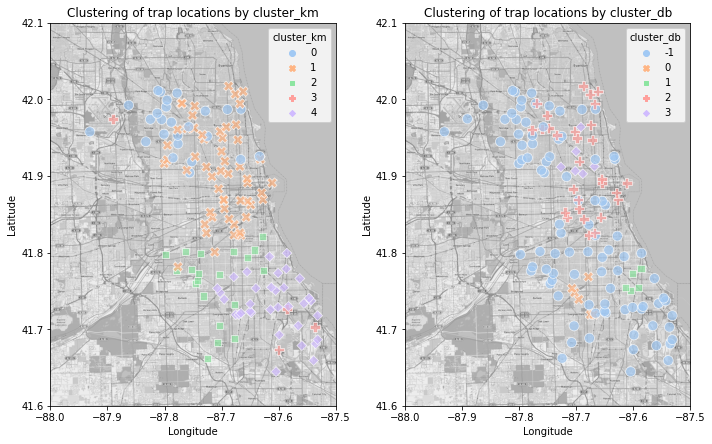

In [184]:
# Plot both map, clustered by KMeans and DBSCAN
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize=(10,14))

clusters = ['cluster_km', 'cluster_db']

for cluster_type, axes in zip(clusters, axes.flat):
  axes.imshow(mapdata, 
            cmap=plt.get_cmap('gray'), 
            extent=lon_lat_box, 
            aspect=aspect)

  sns.scatterplot(
      data = X_clusters,
      x = 'Longitude',
      y = 'Latitude',
      hue = cluster_type,
      style = cluster_type,
      s = 100,
      alpha = 0.7,
      palette = "pastel",
      ax = axes
  );
  plt.tight_layout()
  axes.title.set_text(f'Clustering of trap locations by {cluster_type}')




### Add features using KMeans

In [185]:
# Create custom function to add clustered neighborhood and drop some columns
def add_cluster(df):
    df_clustered = pd.merge(
        left = df, 
    # right = X_clusters.drop_duplicates(subset = ['Latitude', 'Longitude']),
        right = X_clusters,
        how = 'left',
        on = ['Latitude', 'Longitude']
    ).drop(
        columns = cols_to_drop
    )
    return df_clustered

In [186]:
# Must bring back Latitude, as it was dropped earlier
y = train['WnvPresent']
X = train.drop(columns = ['WnvPresent', 
#                           'Longitude',
#                           'Latitude',
                          'NumMosquitos'])
# X_kaggle = test.drop(columns = ['Latitude'])
X_kaggle = test.copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    stratify = y,
    random_state = 42
)

In [187]:
## Create X_train_clustered, X_test_clustered, X_clustered, X_kaggle_clustered

# Drops columns: cluster_db + others mentioned for Model 8
cols_to_drop = [
#  'cluster_km',
 'cluster_db',
 'Date_month',
 'WnvPresent',
 'NumMosquitos',  
#  'Tmax',
#  'Tmin',
#  'Tavg',
#  'DewPoint',
#  'WetBulb',
#  'PrecipTotal',
#  'Tmax_lag1',
#  'Tmax_lag2',
#  'Tmax_lag3',
 'Tmax_lag4',
 'Tmax_lag5',
 'Tmax_lag6',
 'Tmax_lag7',
#  'Tmin_lag1',
#  'Tmin_lag2',
#  'Tmin_lag3',
 'Tmin_lag4',
 'Tmin_lag5',
 'Tmin_lag6',
 'Tmin_lag7',
#  'Tavg_lag1',
#  'Tavg_lag2',
#  'Tavg_lag3',
 'Tavg_lag4',
 'Tavg_lag5',
 'Tavg_lag6',
 'Tavg_lag7',
#  'DewPoint_lag1',
#  'DewPoint_lag2',
#  'DewPoint_lag3',
 'DewPoint_lag4',
 'DewPoint_lag5',
 'DewPoint_lag6',
 'DewPoint_lag7',
#  'WetBulb_lag1',
#  'WetBulb_lag2',
#  'WetBulb_lag3',
 'WetBulb_lag4',
 'WetBulb_lag5',
 'WetBulb_lag6',
 'WetBulb_lag7',
#  'PrecipTotal_lag1',
#  'PrecipTotal_lag2',
#  'PrecipTotal_lag3',
 'PrecipTotal_lag4',
 'PrecipTotal_lag5',
 'PrecipTotal_lag6',
 'PrecipTotal_lag7',
]

# Create datasets with mozzie-neighborhood clusters
X_train_clustered = add_cluster(X_train)
X_test_clustered = add_cluster(X_test)
X_clustered = add_cluster(X)
X_kaggle_clustered = add_cluster(X_kaggle)

# Check
print(X_train.shape, X_train_clustered.shape)
print(X_test.shape, X_test_clustered.shape)
print(X.shape, X_clustered.shape)
print(test.shape, X_kaggle_clustered.shape)

(6356, 54) (6356, 30)
(2119, 54) (2119, 30)
(8475, 54) (8475, 30)
(116293, 54) (116293, 30)


In [188]:
# Check X_kaggle for missing values in cluster_km
# to be expected as there are traps in Test that are unseen in Train
X_kaggle_clustered.isnull().sum()

Species                0
Trap                   0
Latitude               0
Longitude              0
Tmax                   0
                    ... 
PrecipTotal_lag1       0
PrecipTotal_lag2       0
PrecipTotal_lag3       0
Date_week              0
cluster_km          9905
Length: 30, dtype: int64

In [189]:
# Instantiate KNN to fit missing values of cluster_km in Kaggle test set
cluster_model = KNeighborsClassifier(
    weights = 'distance',
    p = 2, # Euclidean
    n_neighbors = 1
)

# Instantiate SS to standardize GPS coordinates
ss = StandardScaler()

# Fit it 
cluster_model.fit(
    ss.fit_transform(X_clusters[['Latitude','Longitude']]), 
    X_clusters['cluster_km']
)

# Check model score, should give near 100% accuracy
cluster_model.score(ss.transform(X_clusters[['Latitude','Longitude']]), X_clusters['cluster_km'])

1.0

In [190]:
# Create predicted values of clusters
X_kaggle_clustered['pred'] = cluster_model.predict(
    ss.transform(X_kaggle_clustered[['Latitude','Longitude']])
)

# Check predictions
X_kaggle_clustered.loc[X_kaggle_clustered['cluster_km'].isnull(),'pred'].unique()

array([2, 1, 4, 0], dtype=int32)

Missing traps seem be to all over the city.

In [191]:
# Overwrite missing cluster_km

def replace_cluster(x):
    if np.isnan(x.cluster_km):
        return x.pred
    else:
        return x.cluster_km

# Impute values
X_kaggle_clustered['cluster_km'] = X_kaggle_clustered.apply(lambda x: replace_cluster(x), axis = 1)
# X_kaggle_clustered['cluster_km'] = X_kaggle_clustered.apply(
#     lambda x: x.pred if np.isnan(x.cluster_km) else x.cluster_km
# )

# Check
X_kaggle_clustered.isnull().sum()

Species             0
Trap                0
Latitude            0
Longitude           0
Tmax                0
                   ..
PrecipTotal_lag2    0
PrecipTotal_lag3    0
Date_week           0
cluster_km          0
pred                0
Length: 31, dtype: int64

In [192]:
# Check again
X_kaggle_clustered.drop(columns = 'pred', inplace = True)
X_kaggle_clustered['cluster_km'].unique()

array([0., 1., 2., 4., 3.])

In [193]:
# Drop Longitude and Latitude, in favor of cluster_km
X_train_clustered.drop(columns = ['Latitude','Longitude'], inplace = True)
X_test_clustered.drop(columns = ['Latitude','Longitude'], inplace = True)
X_clustered.drop(columns = ['Latitude','Longitude'], inplace = True)
X_kaggle_clustered.drop(columns = ['Latitude','Longitude'], inplace = True)

In [194]:
# Check
X_train_clustered

Species  Trap  Tmax  Tmin  Tavg  DewPoint  WetBulb  \
0     CULEX PIPIENS/RESTUANS  T115  68.0  60.0  64.0      55.5     59.0   
1             CULEX RESTUANS  T225  86.5  70.5  78.5      70.5     73.0   
2              CULEX PIPIENS  T220  89.5  65.0  77.5      59.5     66.5   
3              CULEX PIPIENS  T102  91.5  69.0  80.5      62.5     69.5   
4     CULEX PIPIENS/RESTUANS  T025  91.5  69.0  80.5      62.5     69.5   
...                      ...   ...   ...   ...   ...       ...      ...   
6351  CULEX PIPIENS/RESTUANS  T225  78.5  67.0  73.0      55.5     62.0   
6352  CULEX PIPIENS/RESTUANS  T900  67.0  61.5  64.5      60.5     62.0   
6353          CULEX RESTUANS  T128  60.5  49.0  55.0      46.5     50.5   
6354         CULEX TERRITANS  T221  83.0  60.0  71.5      58.0     63.5   
6355          CULEX RESTUANS  T135  93.0  77.5  85.5      69.0     74.0   

      PrecipTotal  Tmax_lag1  Tmax_lag2  Tmax_lag3  Tmin_lag1  Tmin_lag2  \
0            0.00       71.5       74.0       89.0       62.5       65.0   
1            0.67       88.5       82.5       86.5       70.0       68.0   
2            0.00       88.0       84.5       80.0       65.0       61.5   
3            0.00       90.0       87.5       85.0       68.5       63.5   
4            0.00       90.0       87.5       85.0       68.5       63.5   
...           ...        ...        ...        ...        ...        ...   
6351         0.00       90.0       84.0       75.5       68.5       67.5   
6352         1.07       72.5       82.5       79.0       63.0       60.0   
6353         0.09       79.0       72.5       79.0       51.5       47.0   
6354         0.00       81.5       91.5       73.5       64.5       69.5   
6355         0.00       93.5       87.5       77.5       72.5       65.0   

      Tmin_lag3  Tavg_lag1  Tavg_lag2  Tavg_lag3  DewPoint_lag1  \
0          67.5       67.5       70.0       78.5           59.5   
1          61.5       79.5       75.5       74.0           66.5   
2          58.5       76.5       73.0       69.5           61.0   
3          65.0       79.5       76.0       75.0           60.5   
4          65.0       79.5       76.0       75.0           60.5   
...         ...        ...        ...        ...            ...   
6351       60.5       79.5       76.0       68.5           67.5   
6352       55.5       68.0       71.5       67.5           63.0   
6353       51.5       65.5       60.0       65.5           53.5   
6354       64.0       73.5       81.0       69.0           59.0   
6355       62.5       83.0       76.5       70.5           70.5   

      DewPoint_lag2  DewPoint_lag3  WetBulb_lag1  WetBulb_lag2  WetBulb_lag3  \
0              62.5           70.0          62.5          65.0          72.5   
1              64.0           60.5          71.0          68.0          66.0   
2              56.5           55.5          67.0          63.0          61.5   
3              56.0           56.5          68.0          64.5          64.0   
4              56.0           56.5          68.0          64.5          64.0   
...             ...            ...           ...           ...           ...   
6351           66.5           57.5          71.0          69.5          61.5   
6352           61.0           56.5          64.5          65.0          61.5   
6353           42.0           46.0          57.5          51.0          54.5   
6354           65.0           62.5          64.0          70.0          65.0   
6355           64.0           55.0          75.0          68.5          61.5   

      PrecipTotal_lag1  PrecipTotal_lag2  PrecipTotal_lag3  Date_week  \
0                0.030             0.020             0.265         25   
1                0.000             0.000             0.000         28   
2                0.000             0.000             0.000         36   
3                0.000             0.000             0.000         31   
4                0.000             0.000             0.000         31   
...

In [195]:
# Encode, StandardScale

nominal_cols = ['Species', 'Trap', 'Date_week', 'cluster_km']
continuous_cols = [col for col in X_clustered.columns if col not in nominal_cols]

mapper = DataFrameMapper(
  # concatentate list of tuple of (col, transformer) to pass to the features args of DataFrameMapper
  [([cont], StandardScaler()) for cont in continuous_cols] +
  [([nom], LabelBinarizer()) for nom in nominal_cols]
, df_out=True
)

# Create Z_ data sets for train-test(actually more accurate to call it validate)
Z_train_clustered = mapper.fit_transform(X_train_clustered)
Z_test_clustered = mapper.transform(X_test_clustered)

# Create Z_ data set for Kaggle, refitted based on full train set
Z_clustered = mapper.fit_transform(X_clustered)
Z_kaggle_clustered = mapper.transform(X_kaggle_clustered)

In [196]:
# Define and check numerical col names / categorical col names
num_col_names = Z_train_clustered.columns[:24]
cat_col_names = Z_train_clustered.columns[24:]
print(num_col_names, '\n\n', cat_col_names)

Index(['Tmax', 'Tmin', 'Tavg', 'DewPoint', 'WetBulb', 'PrecipTotal',
       'Tmax_lag1', 'Tmax_lag2', 'Tmax_lag3', 'Tmin_lag1', 'Tmin_lag2',
       'Tmin_lag3', 'Tavg_lag1', 'Tavg_lag2', 'Tavg_lag3', 'DewPoint_lag1',
       'DewPoint_lag2', 'DewPoint_lag3', 'WetBulb_lag1', 'WetBulb_lag2',
       'WetBulb_lag3', 'PrecipTotal_lag1', 'PrecipTotal_lag2',
       'PrecipTotal_lag3'],
      dtype='object') 

 Index(['Species_CULEX ERRATICUS', 'Species_CULEX PIPIENS',
       'Species_CULEX PIPIENS/RESTUANS', 'Species_CULEX RESTUANS',
       'Species_CULEX SALINARIUS', 'Species_CULEX TARSALIS',
       'Species_CULEX TERRITANS', 'Trap_T001', 'Trap_T002', 'Trap_T003',
       ...
       'Date_week_37', 'Date_week_38', 'Date_week_39', 'Date_week_40',
       'Date_week_41', 'cluster_km_0', 'cluster_km_1', 'cluster_km_2',
       'cluster_km_3', 'cluster_km_4'],
      dtype='object', length=168)


In [197]:
# Create column index-numbers of categorical
cat_col_index = list(range(len(num_col_names),len(Z_train_clustered.columns)))

In [198]:
%%time
# SMOTE-NC for train-validation
sm = SMOTENC(
    categorical_features = cat_col_index, 
    random_state = 42
)

Z_train_clustered_sm, y_train_sm = sm.fit_resample(Z_train_clustered, y_train)

# Re-instantiate, for Kaggle submission purposes, 
# as fitting needs to be done on entire Train set
sm = SMOTENC(
    categorical_features = cat_col_index, 
    random_state = 42
)

Z_clustered_sm, y_sm = sm.fit_resample(Z_clustered, y)

CPU times: user 31.7 s, sys: 426 ms, total: 32.1 s
Wall time: 32.3 s


In [199]:
# Check
display(pd.Series(y_train).value_counts())
print()
display(pd.Series(y_train_sm).value_counts())

0    6013
1     343
Name: WnvPresent, dtype: int64

0    6013
1    6013
Name: WnvPresent, dtype: int64

In [200]:
# Check
Z_train_clustered.shape, Z_train_clustered_sm.shape

((6356, 192), (12026, 192))

In [201]:
# Add feature names to Z_train_sm otherwise XGBoost can't run later later
# XG likes to throw "feature_names mismatch" error
Z_train_clustered_sm = pd.DataFrame(Z_train_clustered_sm, columns = Z_train_clustered.columns)
display(Z_train_clustered_sm)

Z_clustered_sm = pd.DataFrame(Z_clustered_sm, columns = Z_clustered.columns)
display(Z_clustered_sm)

Tmax      Tmin      Tavg  DewPoint   WetBulb  PrecipTotal  \
0     -1.594119 -0.414386 -1.122594 -0.484309 -0.795577    -0.462624   
1      0.609664  0.963762  0.790436  1.405126  1.255580     1.526073   
2      0.967034  0.241875  0.658503  0.019540  0.303257    -0.462624   
3      1.205281  0.766884  1.054303  0.397427  0.742791    -0.462624   
4      1.205281  0.766884  1.054303  0.397427  0.742791    -0.462624   
...         ...       ...       ...       ...       ...          ...   
12021 -0.105076  1.095015  0.526570  1.090220  0.889302     1.110525   
12022 -0.819817 -0.939395 -0.924694 -0.988158 -0.942088    -0.462624   
12023  1.800898  1.291893  1.648002  1.279164  1.548603     0.398156   
12024  1.800898  1.291893  1.648002  1.279164  1.548603     0.398156   
12025  0.438374  0.269755  0.374802  0.288753  0.396621    -0.419943   

       Tmax_lag1  Tmax_lag2  Tmax_lag3  Tmin_lag1  Tmin_lag2  Tmin_lag3  \
0      -1.208497  -0.785583   1.012977  -0.080830   0.309871   0.670165   
1       0.960578   0.242464   0.714293   0.949019   0.742880  -0.188388   
2       0.896782   0.484358  -0.062284   0.262453  -0.195306  -0.617665   
3       1.151967   0.847198   0.535083   0.743049   0.093367   0.312434   
4       1.151967   0.847198   0.535083   0.743049   0.093367   0.312434   
...          ...        ...        ...        ...        ...        ...   
12021   0.386411   0.000571   0.833767   0.262453   0.598543   0.670165   
12022  -1.208497  -1.208897   0.355873  -0.836053  -0.411810   0.741711   
12023   1.853727   1.693826   1.431134   2.047525   1.969738   1.743357   
12024   1.853727   1.693826   1.431134   2.047525   1.969738   1.743357   
12025   0.266739   0.163808   0.346893   0.377325   0.300911  -0.157993   

       Tavg_lag1  Tavg_lag2  Tavg_lag3  DewPoint_lag1  DewPoint_lag2  \
0      -0.671845  -0.266953   0.901987       0.031520       0.503113   
1       1.008115   0.495727   0.285134       0.903118       0.700910   
2       0.588125   0.149054  -0.331719       0.218291      -0.288075   
3       1.008115   0.565061   0.422213       0.156034      -0.354008   
4       1.008115   0.565061   0.422213       0.156034      -0.354008   
...          ...        ...        ...            ...            ...   
12021   0.378130   0.287723   0.833448       0.903118      -0.419940   
12022  -1.091836  -0.890964   0.559291      -1.213620      -1.013331   
12023   2.058090   1.882418   1.655918       1.525688       1.623963   
12024   2.058090   1.882418   1.655918       1.525688       1.623963   
12025   0.336036   0.258268   0.108634       0.039250       0.171725   

       DewPoint_lag3  WetBulb_lag1  WetBulb_lag2  WetBulb_lag3  \
0           1.447464     -0.267650      0.178948      1.299682   
1           0.207086      1.018090      0.656110      0.304841   
2          -0.445745      0.413036     -0.139160     -0.383895   
3          -0.315179      0.564300      0.099421     -0.001264   
4          -0.315179      0.564300      0.099421     -0.001264   
...              ...           ...           ...           ...   
12021       1.055765      0.791195     -0.059633      0.993577   
12022       0.664067     -1.250864     -1.013956      0.610946   
12023       1.578030      1.774409      1.849015      1.682313   
12024       1.578030      1.774409      1.849015      1.682313   
12025      -0.062152      0.163400      0.268349      0.010241   

       PrecipTotal_lag1  PrecipTotal_lag2  PrecipTotal_lag3  \
0             -0.336896         -0.363120          0.722332   
1             -0.418017         -0.399946         -0.426461   
2             -0.418017         -0.399946         -0.426461   
3             -0.418017         -0.399946         -0.426461   
4             -0.418017         -0.399946         -0.426461   
...                 ...               ...               ...   
12021          0.744724         -0.399946          0.700657   
12022         -0.418017         -0.399946          1.589346   
12023         -0.418

Tmax      Tmin      Tavg  DewPoint   WetBulb  PrecipTotal  \
0      0.796179 -0.073249  0.404568 -0.093933  0.167949    -0.458229   
1      0.796179 -0.073249  0.404568 -0.093933  0.167949    -0.458229   
2      0.796179 -0.073249  0.404568 -0.093933  0.167949    -0.458229   
3      0.796179 -0.073249  0.404568 -0.093933  0.167949    -0.458229   
4      0.796179 -0.073249  0.404568 -0.093933  0.167949    -0.458229   
...         ...       ...       ...       ...       ...          ...   
16031 -0.811800 -0.923190 -0.912774 -0.973304 -0.928805    -0.458229   
16032 -0.335362  0.515172  0.075232 -0.470806 -0.343869    -0.458229   
16033  0.915289  1.299733  1.194972  0.911063  0.972235    -0.443508   
16034 -0.394917  0.580552  0.075232  0.911063  0.606650     0.410304   
16035  0.557960  0.776692  0.668036  1.350748  1.118469    -0.443508   

       Tmax_lag1  Tmax_lag2  Tmax_lag3  Tmin_lag1  Tmin_lag2  Tmin_lag3  \
0      -0.434930  -0.655841  -1.540478  -1.504484  -0.681842  -1.872236   
1      -0.434930  -0.655841  -1.540478  -1.504484  -0.681842  -1.872236   
2      -0.434930  -0.655841  -1.540478  -1.504484  -0.681842  -1.872236   
3      -0.434930  -0.655841  -1.540478  -1.504484  -0.681842  -1.872236   
4      -0.434930  -0.655841  -1.540478  -1.504484  -0.681842  -1.872236   
...          ...        ...        ...        ...        ...        ...   
16031  -1.199350  -1.197616   0.365025  -0.821002  -0.395151   0.749587   
16032   1.157612   0.427709  -0.587727   0.751008   0.679939  -0.313314   
16033   0.775402   0.788893   1.615511   1.229446   1.038302   1.103887   
16034   1.221313   0.909287   0.603212   0.819356   0.608266  -0.384174   
16035  -0.498632  -1.438405  -1.421384   0.682660  -0.108460  -0.455035   

       Tavg_lag1  Tavg_lag2  Tavg_lag3  DewPoint_lag1  DewPoint_lag2  \
0      -1.007444  -0.738040  -1.814401      -1.376441      -1.393590   
1      -1.007444  -0.738040  -1.814401      -1.376441      -1.393590   
2      -1.007444  -0.738040  -1.814401      -1.376441      -1.393590   
3      -1.007444  -0.738040  -1.814401      -1.376441      -1.393590   
4      -1.007444  -0.738040  -1.814401      -1.376441      -1.393590   
...          ...        ...        ...            ...            ...   
16031  -1.077122  -0.875897   0.568640      -1.190820      -0.999256   
16032   1.013208   0.571603  -0.452663       1.036642       1.038131   
16033   1.082885   0.985174   1.419726       1.284138       1.498187   
16034   1.082885   0.778388   0.160119       0.665399       0.380910   
16035   0.037720  -0.875897  -0.997358       1.160390       0.512354   

       DewPoint_lag3  WetBulb_lag1  WetBulb_lag2  WetBulb_lag3  \
0          -0.488253     -1.155019     -1.155982     -1.123711   
1          -0.488253     -1.155019     -1.155982     -1.123711   
2          -0.488253     -1.155019     -1.155982     -1.123711   
3          -0.488253     -1.155019     -1.155982     -1.123711   
4          -0.488253     -1.155019     -1.155982     -1.123711   
...              ...           ...           ...           ...   
16031       0.673782     -1.230235     -0.997788      0.620789   
16032      -0.165465      1.026250      0.900538     -0.365233   
16033       1.448473      1.251899      1.454217      1.455115   
16034       0.028207      0.875818      0.584151      0.165702   
16035      -0.617368      0.800602      0.030472     -0.896168   

       PrecipTotal_lag1  PrecipTotal_lag2  PrecipTotal_lag3  \
0             -0.416099         -0.288426          2.367833   
1             -0.416099         -0.288426          2.367833   
2             -0.416099         -0.288426          2.367833   
3             -0.416099         -0.288426          2.367833   
4             -0.416099         -0.288426          2.367833   
...                 ...               ...               ...   
16031         -0.416099         -0.399509          1.588289   
16032         -0.402759         -0.362481         -0.230646   
16033         -0.149

#### Logistic

In [202]:
# Reset rows for re-runs
df_results = df_results[:13]

In [203]:
# Instantiate model
model = LogisticRegression(
    solver='liblinear', 
    random_state = 42
)

# Set parameters for CV
params = {
    'penalty' : ['l1', 'l2'],
    'C': [0.01, 0.1, 1, 10, 20, 30],
    'max_iter': [10_000]
}

# Run model
new_results = run_grid(Z_train_clustered_sm, Z_test_clustered, y_train_sm, y_test)
df_results = pd.concat([df_results, pd.DataFrame(new_results)], axis = 0)
df_results

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters: {'penalty': 'l2', 'max_iter': 10000, 'C': 10}


Model No.                                         Classifier  \
0         1  LogisticRegression(random_state=42, solver='li...   
0         2                             KNeighborsClassifier()   
0         3            RandomForestClassifier(random_state=42)   
0         4               SVC(max_iter=10000, random_state=42)   
0         5  XGBClassifier(base_score=None, booster=None, c...   
0         6  XGBClassifier(base_score=None, booster=None, c...   
0         7                LogisticRegression(random_state=42)   
0         8  LogisticRegression(random_state=42, solver='li...   
0         9  XGBClassifier(base_score=None, booster=None, c...   
0        10  LogisticRegression(random_state=42, solver='li...   
0        11  XGBClassifier(base_score=None, booster=None, c...   
0        12  LogisticRegression(random_state=42, solver='li...   
0        13  XGBClassifier(base_score=None, booster=None, c...   
0        14  LogisticRegression(random_state=42, solver='li...   

   CV Score (train)  ROC_AUC (train)  ROC_AUC (test) Kaggle Score  \
0             0.989            0.994           0.840        0.659   
0             0.923            0.993           0.808        0.593   
0             0.978            0.996           0.818        0.686   
0             0.974            0.981           0.829        0.606   
0             0.989            0.998           0.809        0.683   
0             0.991            1.000           0.819        0.693   
0             0.989            0.994           0.847        0.659   
0             0.989            0.994           0.836        0.637   
0             0.991            1.000           0.791        0.688   
0             0.988            0.993           0.830        0.722   
0             0.991            0.998           0.814        0.702   
0             0.987            0.992           0.825        0.706   
0             0.992            1.000           0.822        0.666   
0             0.989            0.993           0.837          NaN   

  Runtime (sec)                                          Remarks  
0            13                                              NaN  
0            76                                              NaN  
0            67                                              NaN  
0           257                                              NaN  
0            78                      First run with basic tuning  
0            74            Second run with more paramaters tuned  
0           295                                   no change in C  
0            31  No Date_month, weather cols lagged up to 7 days  
0            80  No Date_month, weather cols lagged up to 7 days  
0            11  No Date_month, weather cols lagged up to 3 days  
0            63  No Date_month, weather cols lagged up to 3 days  
0             4     No Date_month, weather col lagged 1 day only  
0            77     No Date_month, weather col lagged 1 day only  
0            16                                              NaN

In [204]:
## Create Kaggle submission file, but refit best model on full Train set

# Best Parameters: {'penalty': 'l2', 'max_iter': 10000, 'C': 10}
best_model = LogisticRegression(
    solver='liblinear', 
    random_state = 42,
    penalty = 'l2',
    max_iter = 10_000,
    C = 10
)

# Fit it 
best_model.fit(Z_clustered_sm, y_sm)
final_auc = roc_auc_score(y_true = y_sm, y_score = best_model.predict_proba(Z_clustered_sm)[:,1])
# final_auc = roc_auc_score(y_true = y_sm, y_score = best_model.predict(Z_sm))
print(f'Training ROC AUC: {final_auc:.3f}')

# Create and save Kaggle submission 
y_pred = best_model.predict_proba(Z_kaggle_clustered)[:,1]
kaggle['WnvPresent'] = y_pred
# kaggle.to_csv('/content/drive/My Drive/DSI-SG-24-projects/project_4/data/project4_model_14.csv', index=False)
kaggle.to_csv('../data/project4_model_14.csv', index=False)

Training ROC AUC: 0.993


In [205]:
# Enter Kaggle score and comments
df_results.loc[df_results['Model No.'] == 14, 'Kaggle Score'] = 0.711
df_results.loc[df_results['Model No.'] == 14, 'Remarks'] = 'Cousin of Model 10, with KMeans mozzie clusters'
df_results

Model No.                                         Classifier  \
0         1  LogisticRegression(random_state=42, solver='li...   
0         2                             KNeighborsClassifier()   
0         3            RandomForestClassifier(random_state=42)   
0         4               SVC(max_iter=10000, random_state=42)   
0         5  XGBClassifier(base_score=None, booster=None, c...   
0         6  XGBClassifier(base_score=None, booster=None, c...   
0         7                LogisticRegression(random_state=42)   
0         8  LogisticRegression(random_state=42, solver='li...   
0         9  XGBClassifier(base_score=None, booster=None, c...   
0        10  LogisticRegression(random_state=42, solver='li...   
0        11  XGBClassifier(base_score=None, booster=None, c...   
0        12  LogisticRegression(random_state=42, solver='li...   
0        13  XGBClassifier(base_score=None, booster=None, c...   
0        14  LogisticRegression(random_state=42, solver='li...   

   CV Score (train)  ROC_AUC (train)  ROC_AUC (test) Kaggle Score  \
0             0.989            0.994           0.840        0.659   
0             0.923            0.993           0.808        0.593   
0             0.978            0.996           0.818        0.686   
0             0.974            0.981           0.829        0.606   
0             0.989            0.998           0.809        0.683   
0             0.991            1.000           0.819        0.693   
0             0.989            0.994           0.847        0.659   
0             0.989            0.994           0.836        0.637   
0             0.991            1.000           0.791        0.688   
0             0.988            0.993           0.830        0.722   
0             0.991            0.998           0.814        0.702   
0             0.987            0.992           0.825        0.706   
0             0.992            1.000           0.822        0.666   
0             0.989            0.993           0.837        0.711   

  Runtime (sec)                                          Remarks  
0            13                                              NaN  
0            76                                              NaN  
0            67                                              NaN  
0           257                                              NaN  
0            78                      First run with basic tuning  
0            74            Second run with more paramaters tuned  
0           295                                   no change in C  
0            31  No Date_month, weather cols lagged up to 7 days  
0            80  No Date_month, weather cols lagged up to 7 days  
0            11  No Date_month, weather cols lagged up to 3 days  
0            63  No Date_month, weather cols lagged up to 3 days  
0             4     No Date_month, weather col lagged 1 day only  
0            77     No Date_month, weather col lagged 1 day only  
0            16  Cousin of Model 10, with KMeans mozzie clusters

#### XGBoost

In [206]:
# Instantiate model
model = XGBClassifier(random_state = 42)

# Set parameters for CV
params = {
    'learning_rate' : [0.1, 0.3, 0.5, 0.7, 0.9],
    'max_depth' : [1, 3, 5, 7, 9], 
    'subsample' : [0, 0.25, 0.5, 0.75, 1], 
    'reg_alpha' : [0, 1, 1.5],
    'reg_lambda' : [1, 3, 5],
    'gamma' : [0.01, 0.03, 0.05],
    'eval_metric' : ['auc']
}

# Run model
new_results = run_grid(Z_train_clustered_sm, Z_test_clustered, y_train_sm, y_test)
df_results = pd.concat([df_results, pd.DataFrame(new_results)], axis = 0)
df_results

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/Users/lijunandkahshin/opt/anaconda3/envs/dsi24/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Best Parameters: {'subsample': 0.75, 'reg_lambda': 1, 'reg_alpha': 1.5, 'max_depth': 7, 'learning_rate': 0.5, 'gamma': 0.05, 'eval_metric': 'auc'}


Model No.                                         Classifier  \
0         1  LogisticRegression(random_state=42, solver='li...   
0         2                             KNeighborsClassifier()   
0         3            RandomForestClassifier(random_state=42)   
0         4               SVC(max_iter=10000, random_state=42)   
0         5  XGBClassifier(base_score=None, booster=None, c...   
0         6  XGBClassifier(base_score=None, booster=None, c...   
0         7                LogisticRegression(random_state=42)   
0         8  LogisticRegression(random_state=42, solver='li...   
0         9  XGBClassifier(base_score=None, booster=None, c...   
0        10  LogisticRegression(random_state=42, solver='li...   
0        11  XGBClassifier(base_score=None, booster=None, c...   
0        12  LogisticRegression(random_state=42, solver='li...   
0        13  XGBClassifier(base_score=None, booster=None, c...   
0        14  LogisticRegression(random_state=42, solver='li...   
0        15  XGBClassifier(base_score=None, booster=None, c...   

   CV Score (train)  ROC_AUC (train)  ROC_AUC (test) Kaggle Score  \
0             0.989            0.994           0.840        0.659   
0             0.923            0.993           0.808        0.593   
0             0.978            0.996           0.818        0.686   
0             0.974            0.981           0.829        0.606   
0             0.989            0.998           0.809        0.683   
0             0.991            1.000           0.819        0.693   
0             0.989            0.994           0.847        0.659   
0             0.989            0.994           0.836        0.637   
0             0.991            1.000           0.791        0.688   
0             0.988            0.993           0.830        0.722   
0             0.991            0.998           0.814        0.702   
0             0.987            0.992           0.825        0.706   
0             0.992            1.000           0.822        0.666   
0             0.989            0.993           0.837        0.711   
0             0.989            0.996           0.815          NaN   

  Runtime (sec)                                          Remarks  
0            13                                              NaN  
0            76                                              NaN  
0            67                                              NaN  
0           257                                              NaN  
0            78                      First run with basic tuning  
0            74            Second run with more paramaters tuned  
0           295                                   no change in C  
0            31  No Date_month, weather cols lagged up to 7 days  
0            80  No Date_month, weather cols lagged up to 7 days  
0            11  No Date_month, weather cols lagged up to 3 days  
0            63  No Date_month, weather cols lagged up to 3 days  
0             4     No Date_month, weather col lagged 1 day only  
0            77     No Date_month, weather col lagged 1 day only  
0            16  Cousin of Model 10, with KMeans mozzie clusters  
0            85                                              NaN

In [207]:
## Create Kaggle submission file, but refit best model on full Train set

# Best Parameters: {'subsample': 0.75, 'reg_lambda': 1, 'reg_alpha': 0, 'max_depth': 9, 'learning_rate': 0.3, 'gamma': 0.05, 'eval_metric': 'auc'}
best_model = XGBClassifier(
    random_state = 42,
    subsample = 0.75,
    reg_lambda = 1, 
    reg_alpha = 0, 
    max_depth = 9, 
    learning_rate = 0.3, 
    gamma = 0.05,                   
)

# Fit it 
best_model.fit(Z_clustered_sm, y_sm)
final_auc = roc_auc_score(y_true = y_sm, y_score = best_model.predict_proba(Z_clustered_sm)[:,1])
# final_auc = roc_auc_score(y_true = y_sm, y_score = best_model.predict(Z_sm))
print(f'Training ROC AUC: {final_auc:.3f}')

# Create and save Kaggle submission 
y_pred = best_model.predict_proba(Z_kaggle_clustered)[:,1]
kaggle['WnvPresent'] = y_pred
# kaggle.to_csv('/content/drive/My Drive/DSI-SG-24-projects/project_4/data/project4_model_15.csv', index=False)
kaggle.to_csv('../data/project4_model_15.csv', index=False)

[22:32:04] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/lijunandkahshin/opt/anaconda3/envs/dsi24/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Training ROC AUC: 0.997


In [208]:
# Enter Kaggle score and comments
df_results.loc[df_results['Model No.'] == 15, 'Kaggle Score'] = 0.685
df_results.loc[df_results['Model No.'] == 15, 'Remarks'] = 'Cousin of Model 11, with KMeans mozzie clusters'
df_results

Model No.                                         Classifier  \
0         1  LogisticRegression(random_state=42, solver='li...   
0         2                             KNeighborsClassifier()   
0         3            RandomForestClassifier(random_state=42)   
0         4               SVC(max_iter=10000, random_state=42)   
0         5  XGBClassifier(base_score=None, booster=None, c...   
0         6  XGBClassifier(base_score=None, booster=None, c...   
0         7                LogisticRegression(random_state=42)   
0         8  LogisticRegression(random_state=42, solver='li...   
0         9  XGBClassifier(base_score=None, booster=None, c...   
0        10  LogisticRegression(random_state=42, solver='li...   
0        11  XGBClassifier(base_score=None, booster=None, c...   
0        12  LogisticRegression(random_state=42, solver='li...   
0        13  XGBClassifier(base_score=None, booster=None, c...   
0        14  LogisticRegression(random_state=42, solver='li...   
0        15  XGBClassifier(base_score=None, booster=None, c...   

   CV Score (train)  ROC_AUC (train)  ROC_AUC (test) Kaggle Score  \
0             0.989            0.994           0.840        0.659   
0             0.923            0.993           0.808        0.593   
0             0.978            0.996           0.818        0.686   
0             0.974            0.981           0.829        0.606   
0             0.989            0.998           0.809        0.683   
0             0.991            1.000           0.819        0.693   
0             0.989            0.994           0.847        0.659   
0             0.989            0.994           0.836        0.637   
0             0.991            1.000           0.791        0.688   
0             0.988            0.993           0.830        0.722   
0             0.991            0.998           0.814        0.702   
0             0.987            0.992           0.825        0.706   
0             0.992            1.000           0.822        0.666   
0             0.989            0.993           0.837        0.711   
0             0.989            0.996           0.815        0.685   

  Runtime (sec)                                          Remarks  
0            13                                              NaN  
0            76                                              NaN  
0            67                                              NaN  
0           257                                              NaN  
0            78                      First run with basic tuning  
0            74            Second run with more paramaters tuned  
0           295                                   no change in C  
0            31  No Date_month, weather cols lagged up to 7 days  
0            80  No Date_month, weather cols lagged up to 7 days  
0            11  No Date_month, weather cols lagged up to 3 days  
0            63  No Date_month, weather cols lagged up to 3 days  
0             4     No Date_month, weather col lagged 1 day only  
0            77     No Date_month, weather col lagged 1 day only  
0            16  Cousin of Model 10, with KMeans mozzie clusters  
0            85  Cousin of Model 11, with KMeans mozzie clusters

### Add features using DBSCAN

In [209]:
# Must bring back Latitude, as it was dropped earlier
y = train['WnvPresent']
X = train.drop(columns = ['WnvPresent', 
#                           'Longitude',
#                           'Latitude',
                          'NumMosquitos'])
# X_kaggle = test.drop(columns = ['Latitude'])
X_kaggle = test.copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    stratify = y,
    random_state = 42
)

In [210]:
## Create X_train_clustered, X_test_clustered, X_clustered, X_kaggle_clustered

# Drops columns: cluster_db + others mentioned for Model 8
cols_to_drop = [
 'cluster_km',
#  'cluster_db',
 'Date_month',
 'WnvPresent',
 'NumMosquitos',  
#  'Tmax',
#  'Tmin',
#  'Tavg',
#  'DewPoint',
#  'WetBulb',
#  'PrecipTotal',
#  'Tmax_lag1',
#  'Tmax_lag2',
#  'Tmax_lag3',
 'Tmax_lag4',
 'Tmax_lag5',
 'Tmax_lag6',
 'Tmax_lag7',
#  'Tmin_lag1',
#  'Tmin_lag2',
#  'Tmin_lag3',
 'Tmin_lag4',
 'Tmin_lag5',
 'Tmin_lag6',
 'Tmin_lag7',
#  'Tavg_lag1',
#  'Tavg_lag2',
#  'Tavg_lag3',
 'Tavg_lag4',
 'Tavg_lag5',
 'Tavg_lag6',
 'Tavg_lag7',
#  'DewPoint_lag1',
#  'DewPoint_lag2',
#  'DewPoint_lag3',
 'DewPoint_lag4',
 'DewPoint_lag5',
 'DewPoint_lag6',
 'DewPoint_lag7',
#  'WetBulb_lag1',
#  'WetBulb_lag2',
#  'WetBulb_lag3',
 'WetBulb_lag4',
 'WetBulb_lag5',
 'WetBulb_lag6',
 'WetBulb_lag7',
#  'PrecipTotal_lag1',
#  'PrecipTotal_lag2',
#  'PrecipTotal_lag3',
 'PrecipTotal_lag4',
 'PrecipTotal_lag5',
 'PrecipTotal_lag6',
 'PrecipTotal_lag7',
]

# Create datasets with mozzie-neighborhood clusters
X_train_clustered = add_cluster(X_train)
X_test_clustered = add_cluster(X_test)
X_clustered = add_cluster(X)
X_kaggle_clustered = add_cluster(X_kaggle)

# Check
print(X_train.shape, X_train_clustered.shape)
print(X_test.shape, X_test_clustered.shape)
print(X.shape, X_clustered.shape)
print(test.shape, X_kaggle_clustered.shape)

(6356, 54) (6356, 30)
(2119, 54) (2119, 30)
(8475, 54) (8475, 30)
(116293, 54) (116293, 30)


In [211]:
# Check X_kaggle for missing values in cluster_km
# to be expected as there are traps in Test that are unseen in Train
X_kaggle_clustered.isnull().sum()

Species                0
Trap                   0
Latitude               0
Longitude              0
Tmax                   0
                    ... 
PrecipTotal_lag1       0
PrecipTotal_lag2       0
PrecipTotal_lag3       0
Date_week              0
cluster_db          9905
Length: 30, dtype: int64

In [212]:
# Instantiate KNN to fit missing values of cluster_km in Kaggle test set
cluster_model = KNeighborsClassifier(
    weights = 'distance',
    p = 2, # Euclidean
    n_neighbors = 1
)

# Instantiate SS to standardize GPS coordinates
ss = StandardScaler()

# Fit it 
cluster_model.fit(
    ss.fit_transform(X_clusters[['Latitude','Longitude']]), 
    X_clusters['cluster_db']
)

# Check model score, should give near 100% accuracy
cluster_model.score(ss.transform(X_clusters[['Latitude','Longitude']]), X_clusters['cluster_db'])

1.0

In [213]:
# Create predicted values of clusters
X_kaggle_clustered['pred'] = cluster_model.predict(
    ss.transform(X_kaggle_clustered[['Latitude','Longitude']])
)

# Check predictions
X_kaggle_clustered.loc[X_kaggle_clustered['cluster_db'].isnull(),'pred'].unique()

array([-1,  2])

Looks like the 'extra' Traps in test set that are not seen in train set have been allocated to clusters that are mostly located south-east of Chicago

In [214]:
# Overwrite missing cluster_km
def replace_cluster(x):
    if np.isnan(x.cluster_db):
        return x.pred
    else:
        return x.cluster_db

# Impute values
X_kaggle_clustered['cluster_db'] = X_kaggle_clustered.apply(lambda x: replace_cluster(x), axis = 1)

# Check
X_kaggle_clustered.isnull().sum()

Species             0
Trap                0
Latitude            0
Longitude           0
Tmax                0
                   ..
PrecipTotal_lag2    0
PrecipTotal_lag3    0
Date_week           0
cluster_db          0
pred                0
Length: 31, dtype: int64

In [215]:
# Check again
X_kaggle_clustered.drop(columns = 'pred', inplace = True)
X_kaggle_clustered['cluster_db'].unique()

array([-1.,  2.,  3.,  0.,  1.])

In [216]:
# Drop Longitude and Latitude, in favor of cluster_km
X_train_clustered.drop(columns = ['Latitude','Longitude'], inplace = True)
X_test_clustered.drop(columns = ['Latitude','Longitude'], inplace = True)
X_clustered.drop(columns = ['Latitude','Longitude'], inplace = True)
X_kaggle_clustered.drop(columns = ['Latitude','Longitude'], inplace = True)

In [217]:
# Check
X_clustered

Species  Trap  Tmax  Tmin  Tavg  DewPoint  WetBulb  \
0     CULEX PIPIENS/RESTUANS  T048  88.0  62.5  75.5      58.5     65.5   
1             CULEX RESTUANS  T048  88.0  62.5  75.5      58.5     65.5   
2             CULEX RESTUANS  T091  88.0  62.5  75.5      58.5     65.5   
3             CULEX RESTUANS  T049  88.0  62.5  75.5      58.5     65.5   
4             CULEX RESTUANS  T153  88.0  62.5  75.5      58.5     65.5   
...                      ...   ...   ...   ...   ...       ...      ...   
8470           CULEX PIPIENS  T138  75.0  52.5  64.0      52.0     58.0   
8471  CULEX PIPIENS/RESTUANS  T138  75.0  52.5  64.0      52.0     58.0   
8472  CULEX PIPIENS/RESTUANS  T089  75.0  52.5  64.0      52.0     58.0   
8473  CULEX PIPIENS/RESTUANS  T090  75.0  52.5  64.0      52.0     58.0   
8474  CULEX PIPIENS/RESTUANS  T226  75.0  52.5  64.0      52.0     58.0   

      PrecipTotal  Tmax_lag1  Tmax_lag2  Tmax_lag3  Tmin_lag1  Tmin_lag2  \
0             0.0       77.5       75.0       67.5       52.0       58.0   
1             0.0       77.5       75.0       67.5       52.0       58.0   
2             0.0       77.5       75.0       67.5       52.0       58.0   
3             0.0       77.5       75.0       67.5       52.0       58.0   
4             0.0       77.5       75.0       67.5       52.0       58.0   
...           ...        ...        ...        ...        ...        ...   
8470          0.0       70.5       80.5       67.0       53.5       50.5   
8471          0.0       70.5       80.5       67.0       53.5       50.5   
8472          0.0       70.5       80.5       67.0       53.5       50.5   
8473          0.0       70.5       80.5       67.0       53.5       50.5   
8474          0.0       70.5       80.5       67.0       53.5       50.5   

      Tmin_lag3  Tavg_lag1  Tavg_lag2  Tavg_lag3  DewPoint_lag1  \
0          49.5       65.0      66.50       58.5           48.0   
1          49.5       65.0      66.50       58.5           48.0   
2          49.5       65.0      66.50       58.5           48.0   
3          49.5       65.0      66.50       58.5           48.0   
4          49.5       65.0      66.50       58.5           48.0   
...         ...        ...        ...        ...            ...   
8470       48.0       62.5      65.75       58.0           51.5   
8471       48.0       62.5      65.75       58.0           51.5   
8472       48.0       62.5      65.75       58.0           51.5   
8473       48.0       62.5      65.75       58.0           51.5   
8474       48.0       62.5      65.75       58.0           51.5   

      DewPoint_lag2  DewPoint_lag3  WetBulb_lag1  WetBulb_lag2  WetBulb_lag3  \
0              48.0           55.0          56.5          56.5          56.5   
1              48.0           55.0          56.5          56.5          56.5   
2              48.0           55.0          56.5          56.5          56.5   
3              48.0           55.0          56.5          56.5          56.5   
4              48.0           55.0          56.5          56.5          56.5   
...             ...            ...           ...           ...           ...   
8470           48.5           46.5          56.0          54.0          52.5   
8471           48.5           46.5          56.0          54.0          52.5   
8472           48.5           46.5          56.0          54.0          52.5   
8473           48.5           46.5          56.0          54.0          52.5   
8474           48.5           46.5          56.0          54.0          52.5   

      PrecipTotal_lag1  PrecipTotal_lag2  PrecipTotal_lag3  Date_week  \
0                  0.0              0.06             0.645         22   
1                  0.0              0.06             0.645         22   
2                  0.0              0.06             0.645         22   
3                  0.0              0.06             0.645         22   
4                  0.0              0.06             0.645         22   
...

In [218]:
# Encode, StandardScale

nominal_cols = ['Species', 'Trap', 'Date_week', 'cluster_db']
continuous_cols = [col for col in X_clustered.columns if col not in nominal_cols]

mapper = DataFrameMapper(
  # concatentate list of tuple of (col, transformer) to pass to the features args of DataFrameMapper
  [([cont], StandardScaler()) for cont in continuous_cols] +
  [([nom], LabelBinarizer()) for nom in nominal_cols]
, df_out=True
)

# Create Z_ data sets for train-test(actually more accurate to call it validate)
Z_train_clustered = mapper.fit_transform(X_train_clustered)
Z_test_clustered = mapper.transform(X_test_clustered)

# Create Z_ data set for Kaggle, refitted based on full train set
Z_clustered = mapper.fit_transform(X_clustered)
Z_kaggle_clustered = mapper.transform(X_kaggle_clustered)

In [219]:
# Define and check numerical col names / categorical col names
num_col_names = Z_train_clustered.columns[:24]
cat_col_names = Z_train_clustered.columns[24:]
print(num_col_names, '\n\n', cat_col_names)

Index(['Tmax', 'Tmin', 'Tavg', 'DewPoint', 'WetBulb', 'PrecipTotal',
       'Tmax_lag1', 'Tmax_lag2', 'Tmax_lag3', 'Tmin_lag1', 'Tmin_lag2',
       'Tmin_lag3', 'Tavg_lag1', 'Tavg_lag2', 'Tavg_lag3', 'DewPoint_lag1',
       'DewPoint_lag2', 'DewPoint_lag3', 'WetBulb_lag1', 'WetBulb_lag2',
       'WetBulb_lag3', 'PrecipTotal_lag1', 'PrecipTotal_lag2',
       'PrecipTotal_lag3'],
      dtype='object') 

 Index(['Species_CULEX ERRATICUS', 'Species_CULEX PIPIENS',
       'Species_CULEX PIPIENS/RESTUANS', 'Species_CULEX RESTUANS',
       'Species_CULEX SALINARIUS', 'Species_CULEX TARSALIS',
       'Species_CULEX TERRITANS', 'Trap_T001', 'Trap_T002', 'Trap_T003',
       ...
       'Date_week_37', 'Date_week_38', 'Date_week_39', 'Date_week_40',
       'Date_week_41', 'cluster_db_-1', 'cluster_db_0', 'cluster_db_1',
       'cluster_db_2', 'cluster_db_3'],
      dtype='object', length=168)


In [220]:
# Create column index-numbers of categorical
cat_col_index = list(range(len(num_col_names),len(Z_train_clustered.columns)))

In [221]:
%%time
# SMOTE-NC for train-validation
sm = SMOTENC(
    categorical_features = cat_col_index, 
    random_state = 42
)

Z_train_clustered_sm, y_train_sm = sm.fit_resample(Z_train_clustered, y_train)

# Re-instantiate, for Kaggle submission purposes, 
# as fitting needs to be done on entire Train set
sm = SMOTENC(
    categorical_features = cat_col_index, 
    random_state = 42
)

Z_clustered_sm, y_sm = sm.fit_resample(Z_clustered, y)

CPU times: user 31.7 s, sys: 416 ms, total: 32.1 s
Wall time: 32.5 s


In [222]:
# Check
display(pd.Series(y_train).value_counts())
print()
display(pd.Series(y_train_sm).value_counts())

0    6013
1     343
Name: WnvPresent, dtype: int64

0    6013
1    6013
Name: WnvPresent, dtype: int64

In [223]:
# Check
Z_train_clustered.shape, Z_train_clustered_sm.shape

((6356, 192), (12026, 192))

In [224]:
# Add feature names to Z_train_sm otherwise XGBoost can't run later later
# XG likes to throw "feature_names mismatch" error
Z_train_clustered_sm = pd.DataFrame(Z_train_clustered_sm, columns = Z_train_clustered.columns)
display(Z_train_clustered_sm)

Z_clustered_sm = pd.DataFrame(Z_clustered_sm, columns = Z_clustered.columns)
display(Z_clustered_sm)

Tmax      Tmin      Tavg  DewPoint   WetBulb  PrecipTotal  \
0     -1.594119 -0.414386 -1.122594 -0.484309 -0.795577    -0.462624   
1      0.609664  0.963762  0.790436  1.405126  1.255580     1.526073   
2      0.967034  0.241875  0.658503  0.019540  0.303257    -0.462624   
3      1.205281  0.766884  1.054303  0.397427  0.742791    -0.462624   
4      1.205281  0.766884  1.054303  0.397427  0.742791    -0.462624   
...         ...       ...       ...       ...       ...          ...   
12021 -0.105076  1.095015  0.526570  1.090220  0.889302     1.110525   
12022 -0.819817 -0.939395 -0.924694 -0.988158 -0.942088    -0.462624   
12023  1.800898  1.291893  1.648002  1.279164  1.548603     0.398156   
12024  1.800898  1.291893  1.648002  1.279164  1.548603     0.398156   
12025  0.438374  0.269755  0.374802  0.288753  0.396621    -0.419943   

       Tmax_lag1  Tmax_lag2  Tmax_lag3  Tmin_lag1  Tmin_lag2  Tmin_lag3  \
0      -1.208497  -0.785583   1.012977  -0.080830   0.309871   0.670165   
1       0.960578   0.242464   0.714293   0.949019   0.742880  -0.188388   
2       0.896782   0.484358  -0.062284   0.262453  -0.195306  -0.617665   
3       1.151967   0.847198   0.535083   0.743049   0.093367   0.312434   
4       1.151967   0.847198   0.535083   0.743049   0.093367   0.312434   
...          ...        ...        ...        ...        ...        ...   
12021   0.386411   0.000571   0.833767   0.262453   0.598543   0.670165   
12022  -1.208497  -1.208897   0.355873  -0.836053  -0.411810   0.741711   
12023   1.853727   1.693826   1.431134   2.047525   1.969738   1.743357   
12024   1.853727   1.693826   1.431134   2.047525   1.969738   1.743357   
12025   0.266739   0.163808   0.346893   0.377325   0.300911  -0.157993   

       Tavg_lag1  Tavg_lag2  Tavg_lag3  DewPoint_lag1  DewPoint_lag2  \
0      -0.671845  -0.266953   0.901987       0.031520       0.503113   
1       1.008115   0.495727   0.285134       0.903118       0.700910   
2       0.588125   0.149054  -0.331719       0.218291      -0.288075   
3       1.008115   0.565061   0.422213       0.156034      -0.354008   
4       1.008115   0.565061   0.422213       0.156034      -0.354008   
...          ...        ...        ...            ...            ...   
12021   0.378130   0.287723   0.833448       0.903118      -0.419940   
12022  -1.091836  -0.890964   0.559291      -1.213620      -1.013331   
12023   2.058090   1.882418   1.655918       1.525688       1.623963   
12024   2.058090   1.882418   1.655918       1.525688       1.623963   
12025   0.336036   0.258268   0.108634       0.039250       0.171725   

       DewPoint_lag3  WetBulb_lag1  WetBulb_lag2  WetBulb_lag3  \
0           1.447464     -0.267650      0.178948      1.299682   
1           0.207086      1.018090      0.656110      0.304841   
2          -0.445745      0.413036     -0.139160     -0.383895   
3          -0.315179      0.564300      0.099421     -0.001264   
4          -0.315179      0.564300      0.099421     -0.001264   
...              ...           ...           ...           ...   
12021       1.055765      0.791195     -0.059633      0.993577   
12022       0.664067     -1.250864     -1.013956      0.610946   
12023       1.578030      1.774409      1.849015      1.682313   
12024       1.578030      1.774409      1.849015      1.682313   
12025      -0.062152      0.163400      0.268349      0.010241   

       PrecipTotal_lag1  PrecipTotal_lag2  PrecipTotal_lag3  \
0             -0.336896         -0.363120          0.722332   
1             -0.418017         -0.399946         -0.426461   
2             -0.418017         -0.399946         -0.426461   
3             -0.418017         -0.399946         -0.426461   
4             -0.418017         -0.399946         -0.426461   
...                 ...               ...               ...   
12021          0.744724         -0.399946          0.700657   
12022         -0.418017         -0.399946          1.589346   
12023         -0.418

Tmax      Tmin      Tavg  DewPoint   WetBulb  PrecipTotal  \
0      0.796179 -0.073249  0.404568 -0.093933  0.167949    -0.458229   
1      0.796179 -0.073249  0.404568 -0.093933  0.167949    -0.458229   
2      0.796179 -0.073249  0.404568 -0.093933  0.167949    -0.458229   
3      0.796179 -0.073249  0.404568 -0.093933  0.167949    -0.458229   
4      0.796179 -0.073249  0.404568 -0.093933  0.167949    -0.458229   
...         ...       ...       ...       ...       ...          ...   
16031 -0.811800 -0.923190 -0.912774 -0.973304 -0.928805    -0.458229   
16032 -0.335362  0.515172  0.075232 -0.470806 -0.343869    -0.458229   
16033  0.915289  1.299733  1.194972  0.911063  0.972235    -0.443508   
16034 -0.394917  0.580552  0.075232  0.911063  0.606650     0.410304   
16035  0.557960  0.776692  0.668036  1.350748  1.118469    -0.443508   

       Tmax_lag1  Tmax_lag2  Tmax_lag3  Tmin_lag1  Tmin_lag2  Tmin_lag3  \
0      -0.434930  -0.655841  -1.540478  -1.504484  -0.681842  -1.872236   
1      -0.434930  -0.655841  -1.540478  -1.504484  -0.681842  -1.872236   
2      -0.434930  -0.655841  -1.540478  -1.504484  -0.681842  -1.872236   
3      -0.434930  -0.655841  -1.540478  -1.504484  -0.681842  -1.872236   
4      -0.434930  -0.655841  -1.540478  -1.504484  -0.681842  -1.872236   
...          ...        ...        ...        ...        ...        ...   
16031  -1.199350  -1.197616   0.365025  -0.821002  -0.395151   0.749587   
16032   1.157612   0.427709  -0.587727   0.751008   0.679939  -0.313314   
16033   0.775402   0.788893   1.615511   1.229446   1.038302   1.103887   
16034   1.221313   0.909287   0.603212   0.819356   0.608266  -0.384174   
16035  -0.498632  -1.438405  -1.421384   0.682660  -0.108460  -0.455035   

       Tavg_lag1  Tavg_lag2  Tavg_lag3  DewPoint_lag1  DewPoint_lag2  \
0      -1.007444  -0.738040  -1.814401      -1.376441      -1.393590   
1      -1.007444  -0.738040  -1.814401      -1.376441      -1.393590   
2      -1.007444  -0.738040  -1.814401      -1.376441      -1.393590   
3      -1.007444  -0.738040  -1.814401      -1.376441      -1.393590   
4      -1.007444  -0.738040  -1.814401      -1.376441      -1.393590   
...          ...        ...        ...            ...            ...   
16031  -1.077122  -0.875897   0.568640      -1.190820      -0.999256   
16032   1.013208   0.571603  -0.452663       1.036642       1.038131   
16033   1.082885   0.985174   1.419726       1.284138       1.498187   
16034   1.082885   0.778388   0.160119       0.665399       0.380910   
16035   0.037720  -0.875897  -0.997358       1.160390       0.512354   

       DewPoint_lag3  WetBulb_lag1  WetBulb_lag2  WetBulb_lag3  \
0          -0.488253     -1.155019     -1.155982     -1.123711   
1          -0.488253     -1.155019     -1.155982     -1.123711   
2          -0.488253     -1.155019     -1.155982     -1.123711   
3          -0.488253     -1.155019     -1.155982     -1.123711   
4          -0.488253     -1.155019     -1.155982     -1.123711   
...              ...           ...           ...           ...   
16031       0.673782     -1.230235     -0.997788      0.620789   
16032      -0.165465      1.026250      0.900538     -0.365233   
16033       1.448473      1.251899      1.454217      1.455115   
16034       0.028207      0.875818      0.584151      0.165702   
16035      -0.617368      0.800602      0.030472     -0.896168   

       PrecipTotal_lag1  PrecipTotal_lag2  PrecipTotal_lag3  \
0             -0.416099         -0.288426          2.367833   
1             -0.416099         -0.288426          2.367833   
2             -0.416099         -0.288426          2.367833   
3             -0.416099         -0.288426          2.367833   
4             -0.416099         -0.288426          2.367833   
...                 ...               ...               ...   
16031         -0.416099         -0.399509          1.588289   
16032         -0.402759         -0.362481         -0.230646   
16033         -0.149

#### Logistic

In [225]:
# Reset rows for re-runs
df_results = df_results[:15]

In [226]:
# Instantiate model
model = LogisticRegression(
    solver='liblinear', 
    random_state = 42
)

# Set parameters for CV
params = {
    'penalty' : ['l1', 'l2'],
    'C': [0.01, 0.1, 1, 10, 20, 30],
    'max_iter': [10_000]
}

# Run model
new_results = run_grid(Z_train_clustered_sm, Z_test_clustered, y_train_sm, y_test)
df_results = pd.concat([df_results, pd.DataFrame(new_results)], axis = 0)
df_results

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters: {'penalty': 'l2', 'max_iter': 10000, 'C': 30}


Model No.                                         Classifier  \
0         1  LogisticRegression(random_state=42, solver='li...   
0         2                             KNeighborsClassifier()   
0         3            RandomForestClassifier(random_state=42)   
0         4               SVC(max_iter=10000, random_state=42)   
0         5  XGBClassifier(base_score=None, booster=None, c...   
0         6  XGBClassifier(base_score=None, booster=None, c...   
0         7                LogisticRegression(random_state=42)   
0         8  LogisticRegression(random_state=42, solver='li...   
0         9  XGBClassifier(base_score=None, booster=None, c...   
0        10  LogisticRegression(random_state=42, solver='li...   
0        11  XGBClassifier(base_score=None, booster=None, c...   
0        12  LogisticRegression(random_state=42, solver='li...   
0        13  XGBClassifier(base_score=None, booster=None, c...   
0        14  LogisticRegression(random_state=42, solver='li...   
0        15  XGBClassifier(base_score=None, booster=None, c...   
0        16  LogisticRegression(random_state=42, solver='li...   

   CV Score (train)  ROC_AUC (train)  ROC_AUC (test) Kaggle Score  \
0             0.989            0.994           0.840        0.659   
0             0.923            0.993           0.808        0.593   
0             0.978            0.996           0.818        0.686   
0             0.974            0.981           0.829        0.606   
0             0.989            0.998           0.809        0.683   
0             0.991            1.000           0.819        0.693   
0             0.989            0.994           0.847        0.659   
0             0.989            0.994           0.836        0.637   
0             0.991            1.000           0.791        0.688   
0             0.988            0.993           0.830        0.722   
0             0.991            0.998           0.814        0.702   
0             0.987            0.992           0.825        0.706   
0             0.992            1.000           0.822        0.666   
0             0.989            0.993           0.837        0.711   
0             0.989            0.996           0.815        0.685   
0             0.989            0.994           0.846          NaN   

  Runtime (sec)                                          Remarks  
0            13                                              NaN  
0            76                                              NaN  
0            67                                              NaN  
0           257                                              NaN  
0            78                      First run with basic tuning  
0            74            Second run with more paramaters tuned  
0           295                                   no change in C  
0            31  No Date_month, weather cols lagged up to 7 days  
0            80  No Date_month, weather cols lagged up to 7 days  
0            11  No Date_month, weather cols lagged up to 3 days  
0            63  No Date_month, weather cols lagged up to 3 days  
0             4     No Date_month, weather col lagged 1 day only  
0            77     No Date_month, weather col lagged 1 day only  
0            16  Cousin of Model 10, with KMeans mozzie clusters  
0            85  Cousin of Model 11, with KMeans mozzie clusters  
0            16                                              NaN

In [227]:
## Create Kaggle submission file, but refit best model on full Train set

# Best Parameters: {'penalty': 'l2', 'max_iter': 10000, 'C': 30}
best_model = LogisticRegression(
    solver='liblinear', 
    random_state = 42,
    penalty = 'l2',
    max_iter = 10_000,
    C = 30
)

# Fit it 
best_model.fit(Z_clustered_sm, y_sm)
final_auc = roc_auc_score(y_true = y_sm, y_score = best_model.predict_proba(Z_clustered_sm)[:,1])
# final_auc = roc_auc_score(y_true = y_sm, y_score = best_model.predict(Z_sm))
print(f'Training ROC AUC: {final_auc:.3f}')

# Create and save Kaggle submission 
y_pred = best_model.predict_proba(Z_kaggle_clustered)[:,1]
kaggle['WnvPresent'] = y_pred
# kaggle.to_csv('/content/drive/My Drive/DSI-SG-24-projects/project_4/data/project4_model_16.csv', index=False)
kaggle.to_csv('../data/project4_model_16.csv', index=False)

Training ROC AUC: 0.993


In [228]:
# Enter Kaggle score and comments
df_results.loc[df_results['Model No.'] == 16, 'Kaggle Score'] = 0.723
df_results.loc[df_results['Model No.'] == 16, 'Remarks'] = 'Cousin of Model 10, with DBSCAN mozzie clusters'
df_results

Model No.                                         Classifier  \
0         1  LogisticRegression(random_state=42, solver='li...   
0         2                             KNeighborsClassifier()   
0         3            RandomForestClassifier(random_state=42)   
0         4               SVC(max_iter=10000, random_state=42)   
0         5  XGBClassifier(base_score=None, booster=None, c...   
0         6  XGBClassifier(base_score=None, booster=None, c...   
0         7                LogisticRegression(random_state=42)   
0         8  LogisticRegression(random_state=42, solver='li...   
0         9  XGBClassifier(base_score=None, booster=None, c...   
0        10  LogisticRegression(random_state=42, solver='li...   
0        11  XGBClassifier(base_score=None, booster=None, c...   
0        12  LogisticRegression(random_state=42, solver='li...   
0        13  XGBClassifier(base_score=None, booster=None, c...   
0        14  LogisticRegression(random_state=42, solver='li...   
0        15  XGBClassifier(base_score=None, booster=None, c...   
0        16  LogisticRegression(random_state=42, solver='li...   

   CV Score (train)  ROC_AUC (train)  ROC_AUC (test) Kaggle Score  \
0             0.989            0.994           0.840        0.659   
0             0.923            0.993           0.808        0.593   
0             0.978            0.996           0.818        0.686   
0             0.974            0.981           0.829        0.606   
0             0.989            0.998           0.809        0.683   
0             0.991            1.000           0.819        0.693   
0             0.989            0.994           0.847        0.659   
0             0.989            0.994           0.836        0.637   
0             0.991            1.000           0.791        0.688   
0             0.988            0.993           0.830        0.722   
0             0.991            0.998           0.814        0.702   
0             0.987            0.992           0.825        0.706   
0             0.992            1.000           0.822        0.666   
0             0.989            0.993           0.837        0.711   
0             0.989            0.996           0.815        0.685   
0             0.989            0.994           0.846        0.723   

  Runtime (sec)                                          Remarks  
0            13                                              NaN  
0            76                                              NaN  
0            67                                              NaN  
0           257                                              NaN  
0            78                      First run with basic tuning  
0            74            Second run with more paramaters tuned  
0           295                                   no change in C  
0            31  No Date_month, weather cols lagged up to 7 days  
0            80  No Date_month, weather cols lagged up to 7 days  
0            11  No Date_month, weather cols lagged up to 3 days  
0            63  No Date_month, weather cols lagged up to 3 days  
0             4     No Date_month, weather col lagged 1 day only  
0            77     No Date_month, weather col lagged 1 day only  
0            16  Cousin of Model 10, with KMeans mozzie clusters  
0            85  Cousin of Model 11, with KMeans mozzie clusters  
0            16  Cousin of Model 10, with DBSCAN mozzie clusters

#### XGBoost

In [229]:
# Instantiate model
model = XGBClassifier(random_state = 42)

# Set parameters for CV
params = {
    'learning_rate' : [0.1, 0.3, 0.5, 0.7, 0.9],
    'max_depth' : [1, 3, 5, 7, 9], 
    'subsample' : [0, 0.25, 0.5, 0.75, 1], 
    'reg_alpha' : [0, 1, 1.5],
    'reg_lambda' : [1, 3, 5],
    'gamma' : [0.01, 0.03, 0.05],
    'eval_metric' : ['auc']
}

# Run model
new_results = run_grid(Z_train_clustered_sm, Z_test_clustered, y_train_sm, y_test)
df_results = pd.concat([df_results, pd.DataFrame(new_results)], axis = 0)
df_results

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/Users/lijunandkahshin/opt/anaconda3/envs/dsi24/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Best Parameters: {'subsample': 1, 'reg_lambda': 3, 'reg_alpha': 0, 'max_depth': 9, 'learning_rate': 0.5, 'gamma': 0.05, 'eval_metric': 'auc'}


Model No.                                         Classifier  \
0         1  LogisticRegression(random_state=42, solver='li...   
0         2                             KNeighborsClassifier()   
0         3            RandomForestClassifier(random_state=42)   
0         4               SVC(max_iter=10000, random_state=42)   
0         5  XGBClassifier(base_score=None, booster=None, c...   
0         6  XGBClassifier(base_score=None, booster=None, c...   
0         7                LogisticRegression(random_state=42)   
0         8  LogisticRegression(random_state=42, solver='li...   
0         9  XGBClassifier(base_score=None, booster=None, c...   
0        10  LogisticRegression(random_state=42, solver='li...   
0        11  XGBClassifier(base_score=None, booster=None, c...   
0        12  LogisticRegression(random_state=42, solver='li...   
0        13  XGBClassifier(base_score=None, booster=None, c...   
0        14  LogisticRegression(random_state=42, solver='li...   
0        15  XGBClassifier(base_score=None, booster=None, c...   
0        16  LogisticRegression(random_state=42, solver='li...   
0        17  XGBClassifier(base_score=None, booster=None, c...   

   CV Score (train)  ROC_AUC (train)  ROC_AUC (test) Kaggle Score  \
0             0.989            0.994           0.840        0.659   
0             0.923            0.993           0.808        0.593   
0             0.978            0.996           0.818        0.686   
0             0.974            0.981           0.829        0.606   
0             0.989            0.998           0.809        0.683   
0             0.991            1.000           0.819        0.693   
0             0.989            0.994           0.847        0.659   
0             0.989            0.994           0.836        0.637   
0             0.991            1.000           0.791        0.688   
0             0.988            0.993           0.830        0.722   
0             0.991            0.998           0.814        0.702   
0             0.987            0.992           0.825        0.706   
0             0.992            1.000           0.822        0.666   
0             0.989            0.993           0.837        0.711   
0             0.989            0.996           0.815        0.685   
0             0.989            0.994           0.846        0.723   
0             0.989            0.997           0.843          NaN   

  Runtime (sec)                                          Remarks  
0            13                                              NaN  
0            76                                              NaN  
0            67                                              NaN  
0           257                                              NaN  
0            78                      First run with basic tuning  
0            74            Second run with more paramaters tuned  
0           295                                   no change in C  
0            31  No Date_month, weather cols lagged up to 7 days  
0            80  No Date_month, weather cols lagged up to 7 days  
0            11  No Date_month, weather cols lagged up to 3 days  
0            63  No Date_month, weather cols lagged up to 3 days  
0             4     No Date_month, weather col lagged 1 day only  
0            77     No Date_month, weather col lagged 1 day only  
0            16  Cousin of Model 10, with KMeans mozzie clusters  
0            85  Cousin of Model 11, with KMeans mozzie clusters  
0            16  Cousin of Model 10, with DBSCAN mozzie clusters  
0            83                                              NaN

In [230]:
## Create Kaggle submission file, but refit best model on full Train set

# Best Parameters: {'subsample': 1, 'reg_lambda': 5, 'reg_alpha': 1, 'max_depth': 7, 'learning_rate': 0.9, 'gamma': 0.03, 'eval_metric': 'auc'}
best_model = XGBClassifier(
    random_state = 42,
    subsample = 1,
    reg_lambda = 5, 
    reg_alpha = 1, 
    max_depth = 7, 
    learning_rate = 0.9, 
    gamma = 0.03,                   
)

# Fit it 
best_model.fit(Z_clustered_sm, y_sm)
final_auc = roc_auc_score(y_true = y_sm, y_score = best_model.predict_proba(Z_clustered_sm)[:,1])
# final_auc = roc_auc_score(y_true = y_sm, y_score = best_model.predict(Z_sm))
print(f'Training ROC AUC: {final_auc:.3f}')

# Create and save Kaggle submission 
y_pred = best_model.predict_proba(Z_kaggle_clustered)[:,1]
kaggle['WnvPresent'] = y_pred
# kaggle.to_csv('/content/drive/My Drive/DSI-SG-24-projects/project_4/data/project4_model_17.csv', index=False)
kaggle.to_csv('../data/project4_model_17.csv', index=False)

[22:34:30] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/lijunandkahshin/opt/anaconda3/envs/dsi24/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Training ROC AUC: 0.996


In [231]:
# Enter Kaggle score and comments
df_results.loc[df_results['Model No.'] == 17, 'Kaggle Score'] = 0.676
df_results.loc[df_results['Model No.'] == 17, 'Remarks'] = 'Cousin of Model 11, with DBSCAN mozzie clusters'
df_results

Model No.                                         Classifier  \
0         1  LogisticRegression(random_state=42, solver='li...   
0         2                             KNeighborsClassifier()   
0         3            RandomForestClassifier(random_state=42)   
0         4               SVC(max_iter=10000, random_state=42)   
0         5  XGBClassifier(base_score=None, booster=None, c...   
0         6  XGBClassifier(base_score=None, booster=None, c...   
0         7                LogisticRegression(random_state=42)   
0         8  LogisticRegression(random_state=42, solver='li...   
0         9  XGBClassifier(base_score=None, booster=None, c...   
0        10  LogisticRegression(random_state=42, solver='li...   
0        11  XGBClassifier(base_score=None, booster=None, c...   
0        12  LogisticRegression(random_state=42, solver='li...   
0        13  XGBClassifier(base_score=None, booster=None, c...   
0        14  LogisticRegression(random_state=42, solver='li...   
0        15  XGBClassifier(base_score=None, booster=None, c...   
0        16  LogisticRegression(random_state=42, solver='li...   
0        17  XGBClassifier(base_score=None, booster=None, c...   

   CV Score (train)  ROC_AUC (train)  ROC_AUC (test) Kaggle Score  \
0             0.989            0.994           0.840        0.659   
0             0.923            0.993           0.808        0.593   
0             0.978            0.996           0.818        0.686   
0             0.974            0.981           0.829        0.606   
0             0.989            0.998           0.809        0.683   
0             0.991            1.000           0.819        0.693   
0             0.989            0.994           0.847        0.659   
0             0.989            0.994           0.836        0.637   
0             0.991            1.000           0.791        0.688   
0             0.988            0.993           0.830        0.722   
0             0.991            0.998           0.814        0.702   
0             0.987            0.992           0.825        0.706   
0             0.992            1.000           0.822        0.666   
0             0.989            0.993           0.837        0.711   
0             0.989            0.996           0.815        0.685   
0             0.989            0.994           0.846        0.723   
0             0.989            0.997           0.843        0.676   

  Runtime (sec)                                          Remarks  
0            13                                              NaN  
0            76                                              NaN  
0            67                                              NaN  
0           257                                              NaN  
0            78                      First run with basic tuning  
0            74            Second run with more paramaters tuned  
0           295                                   no change in C  
0            31  No Date_month, weather cols lagged up to 7 days  
0            80  No Date_month, weather cols lagged up to 7 days  
0            11  No Date_month, weather cols lagged up to 3 days  
0            63  No Date_month, weather cols lagged up to 3 days  
0             4     No Date_month, weather col lagged 1 day only  
0            77     No Date_month, weather col lagged 1 day only  
0            16  Cousin of Model 10, with KMeans mozzie clusters  
0            85  Cousin of Model 11, with KMeans mozzie clusters  
0            16  Cousin of Model 10, with DBSCAN mozzie clusters  
0            83  Cousin of Model 11, with DBSCAN mozzie clusters